In [1]:
import requests
from pprint import pprint
from geopy.distance import great_circle
import ast
from elasticsearch import Elasticsearch, helpers
import regex as re
from subprocess import Popen, PIPE, STDOUT
import os
import codecs
import numpy as np
from spacy import displacy
import spacy
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sn

%matplotlib inline

plt.style.use('ggplot')

tqdm.pandas(desc="Progress")


# ElasticSearch

In [2]:
es_server = Elasticsearch(
    hosts=["http://localhost:9200"], timeout=60, retry_on_timeout=True)

<ipython-input-2-09391bbada40>:1: DeprecationWarning: The 'timeout' parameter is deprecated in favor of 'request_timeout'
  es_server = Elasticsearch(


In [3]:
es_server.ping()


True

In [4]:
def get_coordinates_es(loc_name, exact_matching=True):
    txt = loc_name.lower()
    if exact_matching: 
        query = {
            "bool": {
                "should": [
                    { "term": { "name2": txt }},
                    { "term": { "asciiname2": txt }},
                    { "term": { "alternatenames2": txt}}
                ]
            }
        }
    else:
        query = {
            "bool": {
                "must": {
                    "multi_match": {
                        "query": txt,
                        "fields": ['name', 'asciiname', 'alternatenames'],
                        "operator":   "and"
                    }
                }
            }
        }
    result = []
    for query_result in es_server.search(index="geonames", query=query, size=10000)["hits"]["hits"]:
        source = query_result["_source"]
        result.append((source["latitude"], source["longitude"], source.get("population", 0), source.get("feature_code", "W"), source["geonameid"]))
    result.sort(key=lambda candidate: candidate[2], reverse=True)
    return result

In [5]:
get_coordinates_es("Brazil")

[(-10.0, -55.0, 209469333, 'PCLI', 3469034),
 (39.52365, -87.12501999999999, 8109, 'PPLA2', 4254884),
 (1.63414, -75.5719, 0, 'PPL', 8185502),
 (34.0265, -90.28065, 0, 'PPL', 4419335),
 (35.91757, -89.06257, 0, 'PPL', 4608373),
 (14.32438, 120.9784, 0, 'ST', 8610469),
 (10.55471, -61.275690000000004, 0, 'PPL', 3574931),
 (40.758070000000004, -92.95437, 0, 'W', 4849262),
 (40.758070000000004, -92.95437, 0, 'PPL', 4849263),
 (37.524809999999995, -84.04159, 0, 'PPL', 4285421),
 (37.84616, -91.06347, 0, 'PPL', 4378282),
 (-27.96667, 30.066670000000002, 0, 'FRM', 1015800),
 (-29.816670000000002, 17.133329999999997, 0, 'LCTY', 3369351),
 (-29.84057, 17.12048, 0, 'FRM', 3369352),
 (12.64933, -86.2379, 0, 'PPL', 3615895),
 (12.26063, -85.92436, 0, 'PPL', 3617945),
 (33.522659999999995, 36.2819, 0, 'DIP', 8373522)]

# Common

In [6]:
def ner_equal(pred, gt, exact_match=False):
    if exact_match:
        return gt[2] == pred[2]
    else:
        if (int(pred[0]) >= int(gt[0]) and int(pred[0]) <= int(gt[1])) or (int(pred[1]) >= int(gt[0]) and int(pred[1]) <= int(gt[1])):
            return True
        return False

In [7]:
from geopy.distance import great_circle


def metrics(predictions, ground_truth, exact_match=False, min_dist=30):
    truth = ground_truth.copy()
    TP = 0
    FP = len(predictions)
    FN = len(truth)
    distances = []
    within_dist = 0
    for pred in predictions:
        for i, gt in enumerate(truth[:]):
            if ner_equal(pred, gt, exact_match):
                TP = TP + 1
                FN = FN - 1
                FP = FP - 1
                if pred[4] is not None:
                    distances.append(great_circle(
                        (float(gt[7]), float(gt[8])), (pred[4][2], pred[4][3])).km)
                    if distances[-1] < min_dist:
                        within_dist = within_dist + 1
                del truth[i]
                break
    pre = TP / (TP + FP) if (TP + FP) else np.nan
    rec = TP / (TP + FN) if (TP + FN) else np.nan
    f1 = (2 * (pre * rec) / (pre + rec)) if (pre + rec) else np.nan
    md = np.mean(distances) if len(distances) > 0 else np.nan
    wd = within_dist / len(distances) if len(distances) > 0 else np.nan
    lgdistances = np.log(np.array(distances) + 1)
    k = np.log(161)
    wd_lg = sum([1.0 for dist in lgdistances if dist < k]) / \
        len(lgdistances) if len(lgdistances) > 0 else np.nan
    auc = np.trapz(lgdistances) / (np.log(20039) * (len(lgdistances) - 1)
                                   ) if len(lgdistances) - 1 != 0 else np.nan
    pct = len(distances)/len(ground_truth) if len(ground_truth) > 0 else np.nan

    return (pre, rec, f1, md, wd, wd_lg, auc, pct)

In [8]:
def get_prediction_errors(predictions, ground_truth, exact_match=False):
    truth = ground_truth.copy()
    distances = []
    for pred in predictions:
        for i, gt in enumerate(truth[:]):
            if ner_equal(pred, gt, exact_match):
                if pred[4] is not None:
                    distances.append(great_circle(
                        (float(gt[7]), float(gt[8])), (pred[4][2], pred[4][3])).km)
                del truth[i]
                break
    return distances

In [9]:
from pprint import pprint


def metrics_gritta(unified, unified_geocoded):
    errors = []
    for g, p in zip(unified, unified_geocoded):
        if p[4] is not None:
            errors.append(great_circle(
                (p[4][2], p[4][3]), (float(g[7]), float(g[8]))).km)
    print(len(errors))

    print(u"Median error:", np.median(sorted(errors)))
    print(u"Mean error:", np.mean(errors))
    print(u"Std error:", np.std(errors))
    errors = np.log(np.array(errors) + 1)
    k = np.log(161)
    print("Accuracy to 161 km: ", sum(
        [1.0 for dist in errors if dist < k]) / len(errors))
    print("AUC = ", np.trapz(errors) / (np.log(20039) * (len(errors) - 1)))
    pprint(metrics(unified_geocoded, unified, False, 161))


In [10]:
import plotly.express as px
import plotly.graph_objects as go


def plot_toponyms_predictions(toponyms, predictions, fig, filename="", visible=True):
    truth = toponyms.copy()
    result = []
    first = True
    for pred in predictions:
        for i, gt in enumerate(truth[:]):
            if ner_equal(pred, gt, False):
                if pred[4] is not None:
                    distance = great_circle(
                        (float(gt[7]), float(gt[8])), (pred[4][2], pred[4][3])).km
                    result.append([
                        [gt[2], pred[2]],
                        [gt[3], pred[4][1]],
                        [gt[6], pred[4][0]],
                        [float(gt[7]), float(pred[4][2])],
                        [float(gt[8]), float(pred[4][3])],
                        [gt[4], gt[4]],
                        ['red', 'green'],
                        'green',
                        [distance, distance]
                    ])
                    fig.add_trace(go.Scattermapbox(
                        mode="markers+lines",
                        lat=[gt[7], pred[4][2]],
                        lon=[gt[8], pred[4][3]],
                        marker=dict(size=[12, 10], color=['red', 'green']),
                        line=dict(color='steelblue'),
                        text=[gt[2], pred[2]],
                        customdata=[
                            [gt[2], gt[3], gt[6], gt[4], distance],
                            [pred[2], pred[4][1], pred[4][0], gt[4], distance]
                        ],
                        hovertemplate="<b>%{text}</b><br><br>extractedName=%{customdata[0]}<br>geonamesName=%{customdata[1]}<br>geonamesID=%{customdata[2]}<br>lat=%{lat}<br>lon=%{lon}<br>type=%{customdata[3]}<br>distance=%{customdata[4]}",
                        legendgroup=(filename),
                        showlegend=first,
                        name=(filename),
                        visible=visible
                    ))
                else:
                    result.append([
                        [gt[2]],
                        [gt[3]],
                        [gt[6]],
                        [float(gt[7])],
                        [float(gt[8])],
                        [gt[4]],
                        ['purple'],
                        ''
                    ])
                    fig.add_trace(go.Scattermapbox(
                        mode="markers",
                        lat=[gt[7]],
                        lon=[gt[8]],
                        marker={'size': 11, 'color': ['purple']},
                        text=[gt[2]],
                        customdata=[
                            [gt[2], gt[3], gt[6], gt[4]]
                        ],
                        hovertemplate="<b>%{text}</b><br><br>extractedName=%{customdata[0]}<br>geonamesName=%{customdata[1]}<br>geonamesID=%{customdata[2]}<br>lat=%{lat}<br>lon=%{lon}<br>type=%{customdata[3]}",
                        legendgroup=(filename),
                        showlegend=first,
                        name=(filename),
                        visible=visible
                    ))
                first = False
                del truth[i]
                break

    return result


In [11]:
def count_errors(predictions, ground_truth, exact_match, classes=["Literal", "Non_Literal_Modifier", "Embedded_Non_Lit", "Mixed", "Literal_Modifier", "Metonymic", "Coercion", "Embedded_Literal"]):
    errors = {k: [] for k in classes}
    truth = ground_truth.copy()
    for p in predictions:
        for i, g in enumerate(truth[:]):
            if ner_equal(p, g, exact_match):
                if p[4] is not None:
                    errors[g[4]].append(great_circle(
                        (g[7], g[8]), (p[4][2], p[4][3])).km)
                else:
                    errors[g[4]].append(-1)
                del truth[i]
                break
    if len(truth):
        for g in truth:
            errors[g[4]].append(-2)
    return errors


def count_errors_by_type(df, exact_match=False, classes=["Literal", "Non_Literal_Modifier", "Embedded_Non_Lit", "Mixed", "Literal_Modifier", "Metonymic", "Coercion", "Embedded_Literal"]):
    counts_errors = df.apply(lambda row: count_errors(
        row.geocoded, row.toponyms, False, classes), axis=1)
    errors_by_type = {k: [] for k in classes}
    for d in counts_errors:
        for k, v in d.items():
            errors_by_type[k].extend(v)
    return errors_by_type


def count_errors_by_type_intersection(df, exact_match=False, classes=["Literal", "Non_Literal_Modifier", "Embedded_Non_Lit", "Mixed", "Literal_Modifier", "Metonymic", "Coercion", "Embedded_Literal"]):
    counts_errors = df.apply(lambda row: count_errors(
        row.geocoded, row.toponyms_in, False, classes), axis=1)
    errors_by_type = {k: [] for k in classes}
    for d in counts_errors:
        for k, v in d.items():
            errors_by_type[k].extend(v)
    return errors_by_type


In [12]:
def align_labels(labels):
    for text in labels:
        x, y = text.get_position()
        h_align = 'left' if x > 0 else 'right'
        v_align = 'bottom' if y > 0 else 'top'
        text.set(ha=h_align, va=v_align)


def plot_pies(df):
    plt.style.use('ggplot')
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color'] + ["crimson", "indigo", "DarkOrchid"]
    for ax, col in zip(axes.flat, df.columns):
        if not df[col].any():
            break
        artists = ax.pie(df[col], autopct=lambda p: '{:.2f}%({:.0f})'.format(
            p, (p/100)*df[col].sum()), pctdistance=1.05, colors=colors)
        ax.set(ylabel='', title=col, aspect='equal')
        align_labels(artists[-1])

    fig.legend(artists[0], df.index, loc='right')

    plt.show()


In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


def plot_confusion_matrices(df):
    plt.style.use('ggplot')
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
    for ax, col in zip(axes.flat, df.columns):
        if not df[col].dropna().count():
            break
        cf_matrix = confusion_matrix([0] + [1 for i in range(df[col].count())], [0] + [
                                     1 if i <= 161 else 0 for i in df[col].dropna().tolist()])
        cf_matrix[0][0] -= 1
        group_names = ['True Neg', 'False Pos', '> 161km', '<= 161km']
        group_counts = ["{0:0.0f}".format(value)
                        for value in cf_matrix.flatten()]
        group_percentages = ["{0:.2%}".format(
            value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
        labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(
            group_names, group_counts, group_percentages)]
        labels = np.asarray(labels).reshape(2, 2)
        sns.heatmap(cf_matrix, annot=labels, fmt='', ax=ax,
                    cmap='Blues',  cbar_kws={"orientation": "horizontal"})
        ax.set(ylabel='', title=col, aspect='equal')

    plt.show()


In [14]:
def plot_bars(df):
    plt.style.use('ggplot')
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
    handles = []
    for ax, col in zip(axes.flat, df.columns):
        if not df[col].dropna().count():
            break
        
        group_names = ['Not Detected', 'No Candidate Found', '<= 161km', '> 161km']
        categorized = df[[col]].apply(pd.cut, bins=[-3, -2, -1, 161, 20038], labels=group_names)
        counts = categorized.apply(pd.Series.value_counts).reset_index()
        
        splot = sns.barplot(x="index", y=col, data=counts, ax=ax)
        for i, p in enumerate(splot.patches):
            splot.annotate("{0:0.0f}\n{1:.2%}".format(p.get_height(), p.get_height()/counts[col].values.sum()), 
                   (p.get_x() + p.get_width() / 2., max(counts[col].values.flat) * 0.02), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
        
        ax.set_xticks([])
        ax.set(xlabel='', ylabel='', title=col)
    
    fig.legend(splot.patches, ['Not Detected', 'No Candidate Found', '<= 161km', '> 161km'], loc='right')

    plt.show()

In [15]:
def plot_bars_stacked(df):
    plt.style.use('ggplot')
    handles = []

    #group_names = ['Não Detectado', 'Sem Candidatos', '<= 161km', '> 161km']
    group_names = ['Sem Candidatos', '<= 161km', '> 161km']
    
    #categorized = df.apply(pd.cut, bins=[-3, -2, -1, 161, 20038], labels=group_names)
    categorized = df.apply(pd.cut, bins=[-3, -1, 161, 20038], labels=group_names)
    counts = categorized.apply(pd.Series.value_counts)

    ax = counts.T.plot(kind='barh', stacked=True, figsize=(10, 10))

    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        ax.text(x + width/2, 
              y + height/2, 
              '{0:0.0f}'.format(width), 
              horizontalalignment='center', 
              verticalalignment='center')

    plt.savefig('plot_bars_stacked.pdf', bbox_inches='tight')
    plt.show()

In [16]:
def plot_bars_stacked_diff(df1, df2):
    plt.style.use('ggplot')
    handles = []

    #group_names = ['Não Detectado', 'Sem Candidatos', '<= 161km', '> 161km']
    group_names = ['Sem Candidatos', '<= 161km', '> 161km']

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 10))
    
    #categorized1 = df1.apply(pd.cut, bins=[-3, -2, -1, 161, 20038], labels=group_names)
    categorized1 = df1.apply(pd.cut, bins=[-3, -1, 161, 20038], labels=group_names)
    counts1 = categorized1.apply(pd.Series.value_counts)

    counts1.T.plot(kind='barh', stacked=True, ax=axes.flat[0])

    #categorized2 = df2.apply(pd.cut, bins=[-3, -2, -1, 161, 20038], labels=group_names)
    categorized2 = df2.apply(pd.cut, bins=[-3, -1, 161, 20038], labels=group_names)
    counts2 = categorized2.apply(pd.Series.value_counts)

    counts2.T.plot(kind='barh', stacked=True, ax=axes.flat[1])

    for p in axes.flat[0].patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        axes.flat[0].text(x + width/2, 
              y + height/2, 
              '{0:0.0f}'.format(width), 
              horizontalalignment='center', 
              verticalalignment='center')
      
    for p in axes.flat[1].patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        axes.flat[1].text(x + width/2, 
              y + height/2, 
              '{0:0.0f}'.format(width), 
              horizontalalignment='center', 
              verticalalignment='center')
    #axes.flat[1].set_yticks([])

    plt.show()

In [17]:
def get_error_by_feature_code(predictions, ground_truth, exact_match=False):
    truth = ground_truth.copy()
    errors_by_type = {}
    distances = []
    within_dist = 0
    for pred in predictions:
        for i, gt in enumerate(truth[:]):
            if ner_equal(pred, gt, exact_match):
                if pred[4] is not None:
                    if gt[10] not in errors_by_type:
                        errors_by_type[gt[10]] = []
                    errors_by_type[gt[10]].append(great_circle(
                        (float(gt[7]), float(gt[8])), (pred[4][2], pred[4][3])).km)
                del truth[i]
                break
    return errors_by_type

def get_mean_error_by_feature_code(df, exact_match=False):
    errors_by_code = df.apply(lambda row: get_error_by_feature_code(row.geocoded, row.toponyms, exact_match), axis=1)
    
    errors_by_code_cum = {}
    for d in errors_by_code:
        for k, v in d.items():
            if k not in errors_by_code_cum:
                errors_by_code_cum[k] = []
            errors_by_code_cum[k].extend(v)

    mean_errors_by_type = {k: np.mean(v) for (k,v) in errors_by_code_cum.items()}
    return mean_errors_by_type

In [18]:
def get_error_by_feature_class(predictions, ground_truth, exact_match=False):
    truth = ground_truth.copy()
    errors_by_type = {}
    distances = []
    within_dist = 0
    for pred in predictions:
        for i, gt in enumerate(truth[:]):
            if ner_equal(pred, gt, exact_match):
                if pred[4] is not None:
                    if gt[9] not in errors_by_type:
                        errors_by_type[gt[9]] = []
                    errors_by_type[gt[9]].append(great_circle(
                        (float(gt[7]), float(gt[8])), (pred[4][2], pred[4][3])).km)
                del truth[i]
                break
    return errors_by_type

def get_mean_error_by_feature_class(df, exact_match=False):
    errors_by_code = df.apply(lambda row: get_error_by_feature_class(row.geocoded, row.toponyms, exact_match), axis=1)
    
    errors_by_code_cum = {}
    for d in errors_by_code:
        for k, v in d.items():
            if k not in errors_by_code_cum:
                errors_by_code_cum[k] = []
            errors_by_code_cum[k].extend(v)

    mean_errors_by_type = {k: np.mean(v) for (k,v) in errors_by_code_cum.items()}
    return mean_errors_by_type

def get_mean_error_by_feature_class_intersection(df, exact_match=False):
    errors_by_code = df.apply(lambda row: get_error_by_feature_class(row.geocoded, row.toponyms_in, exact_match), axis=1)
    
    errors_by_code_cum = {}
    for d in errors_by_code:
        for k, v in d.items():
            if k not in errors_by_code_cum:
                errors_by_code_cum[k] = []
            errors_by_code_cum[k].extend(v)

    mean_errors_by_type = {k: np.mean(v) for (k,v) in errors_by_code_cum.items()}
    return mean_errors_by_type

In [19]:
def get_names_by_demonym(demonym, exact_matching=True):
    txt = demonym.lower()
    if exact_matching:
        query = {
            "bool": {
                "should": [
                    {"term": {"adjectivals_lower": txt}},
                    {"term": {"demonyms_lower": txt}}
                ]
            }
        }
    else:
        query = {
            "bool": {
                "must": {
                    "multi_match": {
                        "query": txt,
                        "fields": ['adjectivals', 'demonyms'],
                        "operator":   "and"
                    }
                }
            }
        }
    result = []
    for query_result in es_server.search(index="demonyms", query=query, size=50)["hits"]["hits"]:
        source = query_result["_source"]
        result.append((source["entity_name"], source["geonames_id"],
                      source["geonames_name"], source["adjectivals"], source["demonyms"]))
    return result


In [20]:
nlp_en = spacy.load("en_core_web_lg")

# Geoparser

In [21]:
class Geoparser:
    def __init__(self, ner_model, loc_entity_labels, es_server, index_search_configs=[]):
        self.ner_model = ner_model
        self.loc_entity_labels = loc_entity_labels
        self.es_server = es_server
        self.index_search_configs = index_search_configs
 
    def _geotag(self, text):
        entities = self.ner_model(text).ents
        loc_entities = [(entity.start_char, entity.end_char, entity.text, entity.label_) for entity in entities if (entity.label_ in self.loc_entity_labels)]
        return loc_entities

    def _get_candidates(self, loc_name, loc_type, exact_matching=False, process_demonyms=False, bounding_box=None, k=5, minimum_score=0.0, sort_by="score"):
        txt = loc_name
        if process_demonyms:
            demonym_entries = get_names_by_demonym(txt, True)
            if len(demonym_entries):
                txt = [d[2] for d in demonym_entries]
            else:
                txt = [txt]
        else:
            txt = [txt]
        candidates = []
        for index in self.index_search_configs:
            if exact_matching:
                txt = [t.lower() for t in txt]
                query = {
                    "bool": {
                        "should": [
                            { "terms": { "name2": txt }},
                            { "terms": { "asciiname2": txt }},
                            { "terms": { "alternatenames2": txt}}
                        ]
                    }
                }
            else:
                query = {
                    "bool": {
                        "should": []
                    }
                }
                for t in txt:
                    query["bool"]["should"].append({
                        "bool": {
                            "must": {
                                "multi_match": {
                                    "query": t,
                                    "fields": ['name', 'asciiname', 'alternatenames'],
                                    "operator":   "and"
                                }
                            }
                        }
                    })
            if bounding_box:
                query['bool']['filter'] = {
                    "geo_bounding_box": { 
                        "location": {
                            "top_left": {
                                "lat": bounding_box[0][0],
                                "lon": bounding_box[0][1]
                            },
                            "bottom_right": {
                                "lat": bounding_box[1][0],
                                "lon": bounding_box[1][1]
                            }
                        }
                    }
                }
            for result in self.es_server.search(index=index["name"], query=query, min_score=minimum_score, size=10000)["hits"]["hits"]:
                source = result["_source"]
                candidates.append((source["geonameid"], source["name"], source["latitude"], source["longitude"], source.get("feature_class", "W"), source.get("population", 0), result["_score"]))
            if len(candidates) > 0:
                if sort_by == "feature_class": 
                    candidates.sort(key=lambda candidate: candidate[4])
                elif sort_by == "population":
                    candidates.sort(key=lambda candidate: candidate[5], reverse=True)
                else:
                    candidates.sort(key=lambda candidate: candidate[-1], reverse=True)
                addr = [candidates[i] for i in range(0, min(k, len(candidates)))]
                return addr
            else:
                return []

    def _disambiguate(self, candidates, loc_type, geocoded=[], minimization_classes=[], minimization_strategy="mean_dist"):
        if len(candidates) == 0:
            return None
        if len(minimization_classes) > 0 and loc_type in minimization_classes:
            geocoded_not_none = [g for g in geocoded if g[4] is not None and g[3] in minimization_classes]
            if len(geocoded_not_none) > 0:
                if minimization_strategy == "pop_by_mean_dist":
                    candidates.sort(key=lambda candidate: -candidate[5] / (1 + np.mean([great_circle((candidate[2], candidate[3]), (geoc[4][2], geoc[4][3])).km for geoc in geocoded_not_none])))
                elif minimization_strategy == "mean_dist":
                    candidates.sort(key=lambda candidate: np.mean([great_circle((candidate[2], candidate[3]), (geoc[4][2], geoc[4][3])).km for geoc in geocoded_not_none]))
                else:
                    candidates.sort(key=lambda candidate: np.sum([great_circle((candidate[2], candidate[3]), (geoc[4][2], geoc[4][3])).km for geoc in geocoded_not_none]))
        return candidates[0]

    def _geocode(self, loc_name, loc_type, geocoded=[], exact_matching=False, process_demonyms=False, bounding_box=None, k=5, minimum_score=0, sort_by="score", minimization_classes=[], minimization_strategy="sum_dist"):
        candidates = self._get_candidates(loc_name, loc_type, exact_matching, process_demonyms, bounding_box, k, minimum_score, sort_by)
        addr = self._disambiguate(candidates, loc_type, geocoded, minimization_classes, minimization_strategy)
        return addr

    def _geocode_entities(self, entities, exact_matching=False, process_demonyms=False, bounding_box=None, k=5, minimum_score=0, sort_by="score", minimization_classes=[], minimization_strategy="sum_dist"):
        geocoded=[]
        for entity in entities:
            res = self._geocode(entity[2], entity[3], geocoded=geocoded, exact_matching=exact_matching, process_demonyms=process_demonyms, bounding_box=bounding_box,
                                     k=k, minimum_score=minimum_score, sort_by=sort_by, minimization_classes=minimization_classes, minimization_strategy=minimization_strategy)
            geocoded.append((entity[0], entity[1], entity[2], entity[3], res))
        return geocoded

    def geoparse(self, text, exact_matching=False, process_demonyms=False, bounding_box=None, k=5, minimum_score=0, sort_by="score", minimization_classes=[], minimization_strategy="sum_dist"):
        entities = self._geotag(text)
        geocoded = self._geocode_entities(entities=entities, exact_matching=exact_matching, process_demonyms=process_demonyms, bounding_box=bounding_box,
                                     k=k, minimum_score=minimum_score, sort_by=sort_by, minimization_classes=minimization_classes, minimization_strategy=minimization_strategy)
        return geocoded

In [22]:
geoparser = Geoparser(nlp_en, 
                      ['ORG', 'LOC', 'GPE', 'FAC', 'FACILITY'], 
                      es_server, [{"name": "geonames", "fields": ['name', 'asciiname', 'alternatenames']}])

In [23]:
print(geoparser._geocode("Chinese", '', geocoded=[], exact_matching=False, process_demonyms=False, bounding_box=None,
                                  k=5, minimum_score=0, sort_by="population", minimization_classes=[], minimization_strategy="sum_dist"))

print(geoparser._geocode("Chinese", '', geocoded=[], exact_matching=True, process_demonyms=False, bounding_box=None,
                                  k=5, minimum_score=0, sort_by="population", minimization_classes=[], minimization_strategy="sum_dist"))


print(geoparser._geocode("Chinese", '', geocoded=[], exact_matching=False, process_demonyms=True, bounding_box=None,
                                  k=5, minimum_score=0, sort_by="population", minimization_classes=[], minimization_strategy="sum_dist"))

print(geoparser._geocode("Chinese", '', geocoded=[], exact_matching=True, process_demonyms=True, bounding_box=None,
                                  k=5, minimum_score=0, sort_by="population", minimization_classes=[], minimization_strategy="sum_dist"))


print(geoparser._geocode("Chinese", 'Literal', 
                         geocoded=[(0, 13, "Chinese Garden", "Literal", (1882507, 'Chinese Garden', 1.33861, 103.73, 'L', 0, 3.0)), 
                                   (50, 67, "Chinese Embassy", "Coercion", (4138500, 'Embassy of the Peoples Republic of China', 38.91872, -77.04914000000001, 'S', 0, 2.0))], 
                         exact_matching=False, process_demonyms=False, bounding_box=None,
                         k=5, minimum_score=0, sort_by="population", minimization_classes=['Literal'], minimization_strategy="sum_dist"))

print(geoparser._geocode("Chinese", 'Coercion', 
                         geocoded=[(0, 13, "Chinese Garden", "Literal", (1882507, 'Chinese Garden', 1.33861, 103.73, 'L', 0, 3.0)), 
                                   (50, 67, "Chinese Embassy", "Coercion", (4138500, 'Embassy of the Peoples Republic of China', 38.91872, -77.04914000000001, 'S', 0, 2.0))], 
                         exact_matching=False, process_demonyms=False, bounding_box=None,
                         k=5, minimum_score=0, sort_by="population", minimization_classes=['Literal'], minimization_strategy="sum_dist"))

print(geoparser._geocode("Chinese", 'Coercion', 
                         geocoded=[(0, 13, "Chinese Garden", "Literal", (1882507, 'Chinese Garden', 1.33861, 103.73, 'L', 0, 3.0)), 
                                   (50, 67, "Chinese Embassy", "Coercion", (4138500, 'Embassy of the Peoples Republic of China', 38.91872, -77.04914000000001, 'S', 0, 2.0))], 
                         exact_matching=False, process_demonyms=False, bounding_box=None,
                         k=5, minimum_score=0, sort_by="population", minimization_classes=['Coercion'], minimization_strategy="sum_dist"))


print(geoparser._geocode("Chinese", 'Literal', 
                         geocoded=[(0, 13, "Chinese Garden", "Literal", (1882507, 'Chinese Garden', 1.33861, 103.73, 'L', 0, 3.0)), 
                                   (50, 67, "Chinese Embassy", "Coercion", (4138500, 'Embassy of the Peoples Republic of China', 38.91872, -77.04914000000001, 'S', 0, 2.0))], 
                         exact_matching=False, process_demonyms=True, bounding_box=None,
                         k=5, minimum_score=0, sort_by="population", minimization_classes=['Literal'], minimization_strategy="sum_dist"))

print(geoparser._geocode("Chinese", 'Coercion', 
                         geocoded=[(0, 13, "Chinese Garden", "Literal", (1882507, 'Chinese Garden', 1.33861, 103.73, 'L', 0, 3.0)), 
                                   (50, 67, "Chinese Embassy", "Coercion", (4138500, 'Embassy of the Peoples Republic of China', 38.91872, -77.04914000000001, 'S', 0, 2.0))], 
                         exact_matching=False, process_demonyms=True, bounding_box=None,
                         k=5, minimum_score=0, sort_by="population", minimization_classes=['Literal'], minimization_strategy="sum_dist"))

print(geoparser._geocode("Chinese", 'Coercion', 
                         geocoded=[(0, 13, "Chinese Garden", "Literal", (1882507, 'Chinese Garden', 1.33861, 103.73, 'L', 0, 3.0)), 
                                   (50, 67, "Chinese Embassy", "Coercion", (4138500, 'Embassy of the Peoples Republic of China', 38.91872, -77.04914000000001, 'S', 0, 2.0))], 
                         exact_matching=False, process_demonyms=True, bounding_box=None,
                         k=5, minimum_score=0, sort_by="population", minimization_classes=['Coercion'], minimization_strategy="sum_dist"))

(1799355, 'Ningxia Huizu Zizhiqu', 37.25, 106.0, 'A', 6180000, 4.3937798)
None
(1814991, 'People’s Republic of China', 35.0, 105.0, 'A', 1392730000, 6.289756)
(1814991, 'People’s Republic of China', 35.0, 105.0, 'A', 1392730000, 1.0)
(1882507, 'Chinese Garden', 1.33861, 103.73, 'L', 0, 16.081512)
(1799355, 'Ningxia Huizu Zizhiqu', 37.25, 106.0, 'A', 6180000, 4.3937798)
(5336487, 'Chinese Camp', 37.87104, -120.43325, 'P', 126, 13.43905)
(1821275, 'Macau Special Administrative Region', 22.15778, 113.55972, 'A', 631636, 3.3660793)
(1814991, 'People’s Republic of China', 35.0, 105.0, 'A', 1392730000, 6.289756)
(1814991, 'People’s Republic of China', 35.0, 105.0, 'A', 1392730000, 6.289756)


# Experimentos

In [24]:
def geocode_toponyms(geoparser, toponyms, exact_matching=False, process_demonyms=False, bounding_box=None, k=5, minimum_score=0, sort_by="score", minimization_classes=[], minimization_strategy="sum_dist"):
    loc_entities = [(t[0], t[1], t[2], t[4]) for t in toponyms]
    loc_entities.sort(key=lambda entity: int(entity[0]))
    geocoded = geoparser._geocode_entities(loc_entities, exact_matching=exact_matching, process_demonyms=process_demonyms, bounding_box=bounding_box, k=k, minimum_score=minimum_score, sort_by=sort_by, minimization_classes=minimization_classes, minimization_strategy=minimization_strategy)
    return geocoded

In [25]:
def get_camcoder_geocoded(df, filenum):
    geocoded = []
    for i, r in df[df["Line"] == filenum].iterrows():
        geocoded.append((r.Start, r.End, r.Name, '', (-1, '', r["Best Candidate"][0],  r["Best Candidate"][1], '', -1, -1)))
    return geocoded

## GeoWebNews

In [26]:
df_geowebnews = pd.read_csv('../EUPEG-datasets/GeoWebNews_with_featurecodes.csv')
df_geowebnews['toponyms'] = df_geowebnews.apply(
    lambda row: ast.literal_eval(row.toponyms), axis=1)

df_geowebnews['toponyms'] = df_geowebnews['toponyms'].apply(
    lambda x: [t for t in x if t[6] is not None])

df_geowebnews

,file,link,title,text,toponyms
0,0,http://www.nola.com/mardi_gras_nola/2018/01/ta...,Krewe du Vieux 2018: Take a virtual tour of th...,This area formed the heart of the plantation o...,"[(3691, 3716, Third Presbyterian Church, Third..."
1,1,http://www.eastoregonian.com/turkey-shells-syr...,Turkey shells Syrian city as it pushes into Ku...,BEIRUT (AP) � A Kurdish militia spokesman says...,"[(612, 617, Afrin, Afrin District, Literal, No..."
2,10,https://www.washingtonpost.com/realestate/a-ta...,"A new development in Gainesville, Va., provide...",Southern design Buy Photo : Exteriors are vary...,"[(2817, 2841, Vienna/Fairfax-GMU Metro, Vienna..."
3,100,http://bangordailynews.com/2018/03/31/news/nat...,Laura Ingraham takes an Easter break amid Davi...,"Cleve R. Wootson Jr., The Washington Post Marc...","[(3394, 3401, America, United States, Metonymi..."
4,101,http://www.thisdaylive.com/index.php/2018/03/3...,Perm Secretary Launches Book for Africa’s Deve...,"Former Permanent Secretary, Federal Ministry o...","[(4302, 4309, African, Africa, Embedded_Non_Li..."
...,...,...,...,...,...
195,313,https://www.maltatoday.com.mt/news/national/85...,Incoming MFSA chairman accuses Deutsche Bank o...,Incoming Malta Financial Services Authority ch...,"[(606, 613, Germany, Federal Republic of Germa..."
196,314,http://www.adnkronos.com/immediapress/pr-newsw...,EW Nutrition and ICON Form a Strategic Partner...,EW Nutrition acquires 51% of the shares in ICO...,"[(2183, 2189, Brazil, Federative Republic of B..."
197,318,http://www.watoday.com.au/world/a-question-of-...,A question of diversity: how fashion is ditchi...,"""We want to be held accountable,"" she said in ...","[(2101, 2113, South Africa, Republic of South ..."
198,319,https://www.derryjournal.com/news/altnagelvin-...,Altnagelvin’s new health and well-being hub opens,A new Health and Wellbeing Campus has opened a...,"[(555, 563, Republic, Ireland, Literal, None, ..."


### CamCoder

In [27]:
df_geowebnews_camcoder = pd.read_csv('../EUPEG-datasets/Outputs/GeoWebNews_CamCoder_geocoded.csv')
df_geowebnews_camcoder['Y'] = df_geowebnews_camcoder["Y"].apply(
    lambda x: ast.literal_eval(x))
df_geowebnews_camcoder['Best Candidate'] = df_geowebnews_camcoder['Best Candidate'].apply(
    lambda x: ast.literal_eval(x))


df_geocoded_camcoder = df_geowebnews[['file', 'text', 'toponyms']].copy()

df_geocoded_camcoder['geocoded'] = df_geocoded_camcoder.progress_apply(lambda row: get_camcoder_geocoded(df_geowebnews_camcoder, row.name), axis=1)


unified_geocoded =  df_geocoded_camcoder['geocoded'].apply(lambda x: [t for t in x if t[4] is not None]).tolist()
unified_geocoded = [i for j in unified_geocoded for i in j]
print(len(unified_geocoded))

df_metrics_geocoded = pd.DataFrame(df_geocoded_camcoder.apply(lambda row: metrics(row.geocoded, row.toponyms, False, 161), axis=1).tolist(), index=df_geocoded_camcoder.index, columns=['Geotag Precision', 'Geotag Recall', 'Geotag F1-Score', 'Geocode Mean Distance', ' Geocode Within Min Distance', '@161 km', 'AUC', 'Pct predicted'])
df_metrics_geocoded.describe()

Progress:   0%|          | 0/200 [00:00<?, ?it/s]

2102


,Geotag Precision,Geotag Recall,Geotag F1-Score,Geocode Mean Distance,Geocode Within Min Distance,@161 km,AUC,Pct predicted
count,196.0,199.000000,196.000000,196.000000,196.000000,196.000000,190.000000,199.000000
mean,1.0,0.863545,0.925237,1037.378719,0.752997,0.752997,0.206935,0.863545
std,0.0,0.192605,0.107238,1514.639870,0.267948,0.267948,0.188238,0.192605
min,1.0,0.000000,0.400000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,0.771242,0.875000,3.022824,0.571429,0.571429,0.037822,0.771242
50%,1.0,0.947368,0.977078,265.453456,0.839744,0.839744,0.159288,0.947368
75%,1.0,1.000000,1.000000,1649.408525,1.000000,1.000000,0.336338,1.000000
max,1.0,1.000000,1.000000,8439.783708,1.000000,1.000000,0.883678,1.000000


In [28]:
errors_by_type = count_errors_by_type(df_geocoded_camcoder)
df_errors_by_type_camcoder = pd.DataFrame(
    {key: pd.Series(value) for key, value in errors_by_type.items()})

#### Erro por Feature Code

{'CH': 1196.161190495967, 'PCLI': 1661.6756298974574, 'PPLX': 1653.4729494954252, 'ADM1': 276.8821133289581, 'PRK': 1449.8934197922986, 'HSTS': 0.18286926602841375, 'ADM2': 241.15252333331435, 'PPLC': 701.2423865002961, 'PPL': 1206.2901399136192, 'AIRP': 1178.3002747716398, 'PPLA': 72.8679254186911, 'RSV': 0.0, 'SCH': 122.60855049288355, 'CONT': 787.0619587501255, 'ISL': 2.013713846454377, 'SEA': 467.84680758862874, 'PPLA2': 588.6081112726258, 'RECR': 0.46359988935153074, 'CST': 13774.197279050024, 'OAS': 0.0, 'PCLD': 0.0, 'RGN': 4146.886122261518, 'BLDG': 3223.533975974378, 'PPLA3': 2493.79345534374, 'OCN': 4511.029400013469, 'STM': 347.51369339784753, 'HTL': 9.868477493461862, 'OILF': 311.62460704663886, 'TERR': 4870.107056234993, 'GULF': 11707.22365477247, 'ADM3': 1280.8217069902382, 'DLTA': 0.0, 'ADM1H': 0.0, 'AREA': 0.0, 'PEN': 0.0, 'BAY': 0.0, 'BANK': 0.0, 'AMUS': 0.0, 'CSTL': 0.0, 'CMP': 0.0, 'ADMF': 3224.4062163882045, 'ADMD': 0.0, 'STDM': 0.0, 'RES': 98.1845355421325, 'LGN': 0

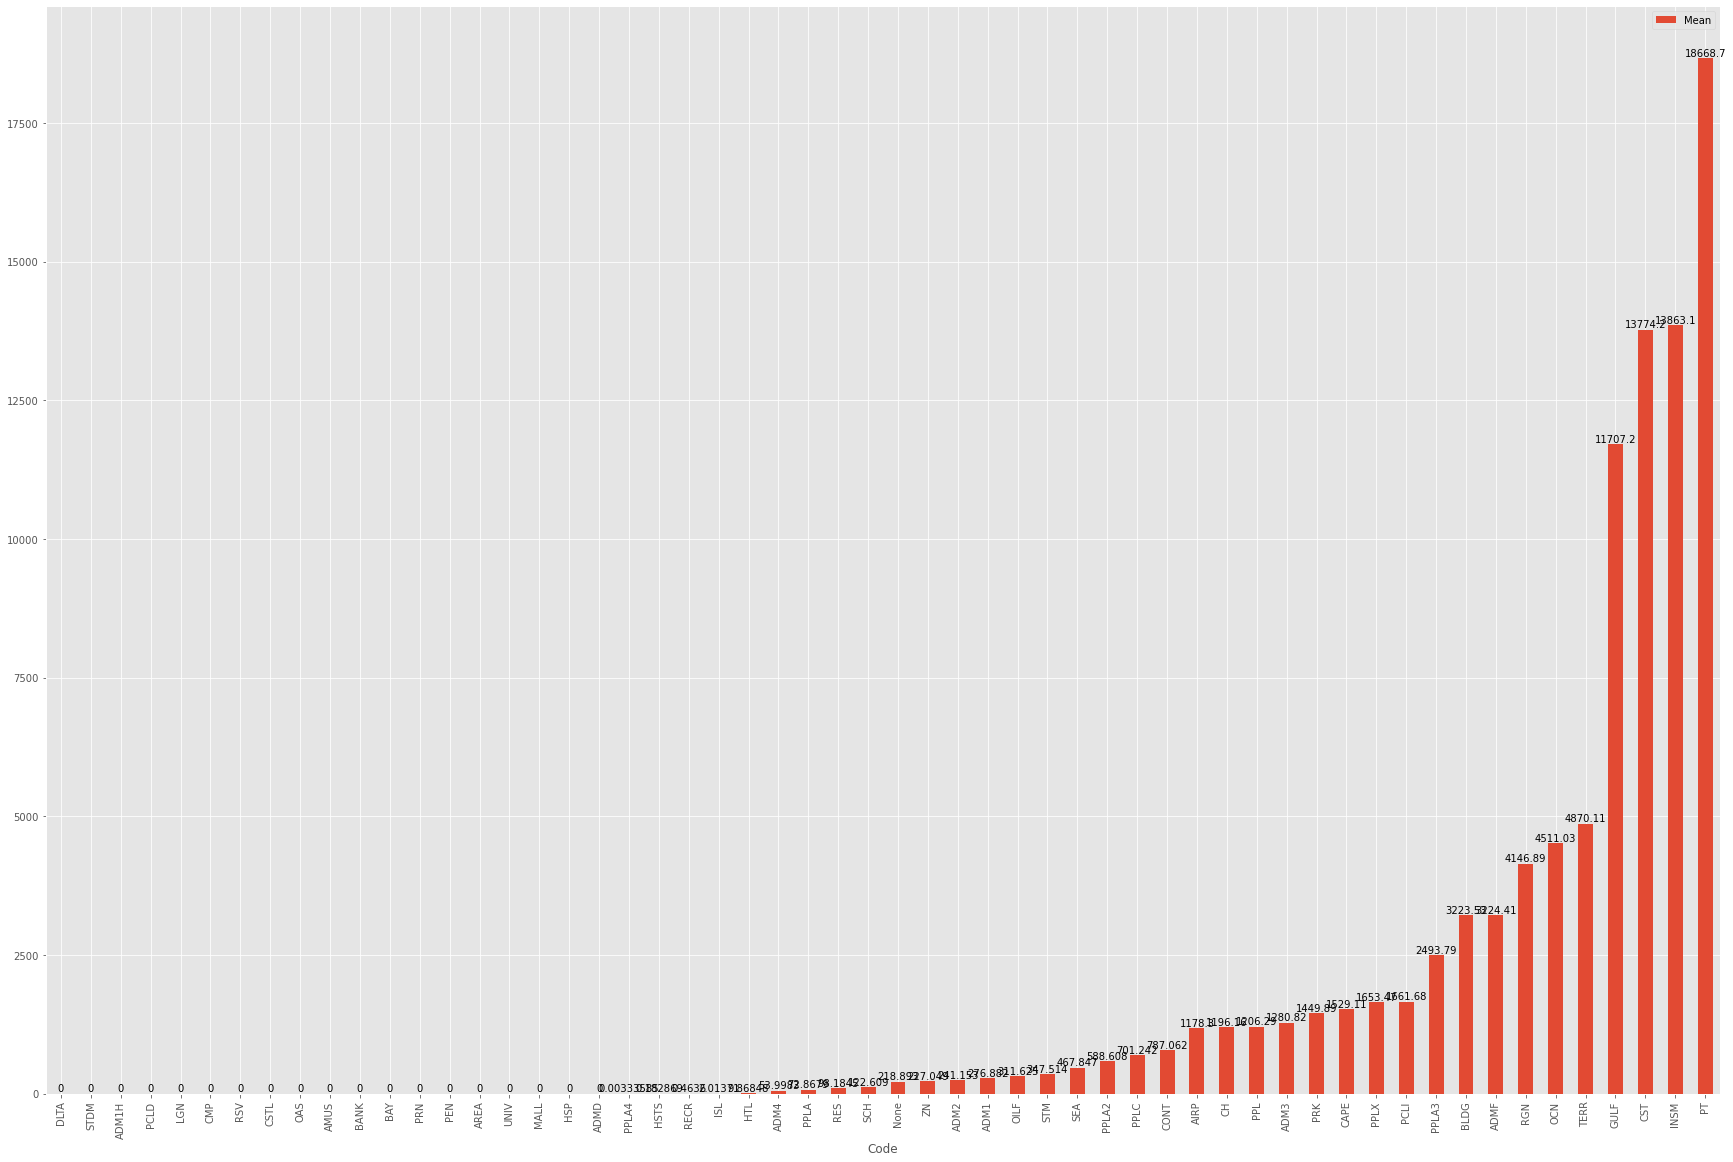

In [29]:
mean_errors_by_code = get_mean_error_by_feature_code(df_geocoded_camcoder, False)
ax = pd.DataFrame(mean_errors_by_code.items(), columns=['Code', 'Mean']).sort_values(by=['Mean']).plot.bar(x="Code", y="Mean", figsize=(30,20))
ax.bar_label(ax.containers[0])
print(mean_errors_by_code)

#### Erro por Feature Class

{'S': 1022.4469406920666, 'A': 1305.0120575471858, 'P': 757.8704670623363, 'L': 1456.464088463973, 'H': 2836.1635095169477, 'T': 2693.584191981208, None: 218.89303315694457}


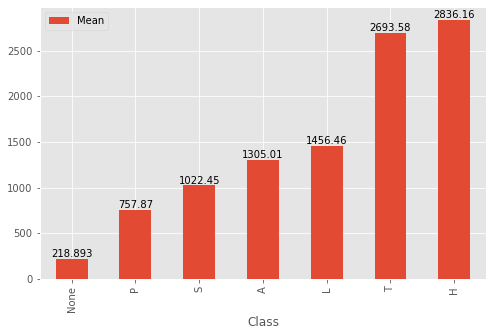

In [30]:
mean_errors_by_class = get_mean_error_by_feature_class(df_geocoded_camcoder, False)
ax = pd.DataFrame(mean_errors_by_class.items(), columns=['Class', 'Mean']).sort_values(by=['Mean']).plot.bar(x="Class", y="Mean", figsize=(8,5))
ax.bar_label(ax.containers[0])
print(mean_errors_by_class)

### HG

In [31]:
df_geocoded_hg = df_geowebnews[['file', 'text', 'toponyms']].copy()
df_geocoded_hg['geocoded'] = df_geocoded_hg.progress_apply(lambda row: geocode_toponyms(geoparser, row.toponyms, exact_matching=True, process_demonyms=False, bounding_box=None, k=1, minimum_score=0, sort_by="population", minimization_classes=[], minimization_strategy="sum_dist"), axis=1)

unified_geocoded =  df_geocoded_hg['geocoded'].apply(lambda x: [t for t in x if t[4] is not None]).tolist()
unified_geocoded = [i for j in unified_geocoded for i in j]
print(len(unified_geocoded))

df_metrics_geocoded = pd.DataFrame(df_geocoded_hg.apply(lambda row: metrics(row.geocoded, row.toponyms, False, 161), axis=1).tolist(), index=df_geocoded_hg.index, columns=['Geotag Precision', 'Geotag Recall', 'Geotag F1-Score', 'Geocode Mean Distance', ' Geocode Within Min Distance', '@161 km', 'AUC', 'Pct predicted'])
df_metrics_geocoded.describe()

Progress:   0%|          | 0/200 [00:00<?, ?it/s]

2106


,Geotag Precision,Geotag Recall,Geotag F1-Score,Geocode Mean Distance,Geocode Within Min Distance,@161 km,AUC,Pct predicted
count,199.0,199.0,199.0,196.000000,196.000000,196.000000,190.000000,199.000000
mean,1.0,1.0,1.0,1162.944522,0.771268,0.771268,0.204715,0.865168
std,0.0,0.0,0.0,1612.917557,0.251918,0.251918,0.177872,0.192001
min,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,1.0,1.0,1.406842,0.600000,0.600000,0.037822,0.771242
50%,1.0,1.0,1.0,374.636829,0.857143,0.857143,0.176096,0.953846
75%,1.0,1.0,1.0,1895.729480,1.000000,1.000000,0.321967,1.000000
max,1.0,1.0,1.0,7521.459917,1.000000,1.000000,0.859172,1.000000


#### Erro por Feature Code

{'ADM1': 378.35541573774776, 'PCLI': 1966.6032724244274, 'HSTS': 7.073240881894094e-13, 'PPLX': 1732.845218793279, 'PRK': 3187.0719389431074, 'CH': 1133.7280187760255, 'PPLC': 645.7880512485742, 'ADM2': 120.5075470006598, 'PPLA': 22.053857006756083, 'RSV': 0.0, 'PPL': 1449.0529643322354, 'AIRP': 2335.5048348174114, 'SCH': 101.91906807668589, 'CONT': 833.3260749269305, 'SEA': 759.2320849145984, 'ISL': 2.013713846455215, 'PPLA2': 417.43761776078463, 'RECR': 0.4635998893516881, 'CST': 13774.197279050024, 'OAS': 0.0, 'PCLD': 1.8342460361222026e-12, 'RGN': 4193.010879124662, 'BLDG': 5868.210326482537, 'PPLA3': 2493.79345534374, 'OCN': 3910.441120881665, 'STM': 1.2954756891516385e-12, 'HTL': 9.868477493462116, 'OILF': 1114.3640738098309, 'TERR': 17074.83847431701, 'GULF': 10799.11705745284, 'ADM3': 1280.8217069902382, 'DLTA': 0.0, 'ADM1H': 0.0, 'AREA': 6.885853888531454e-15, 'PEN': 0.0, 'BAY': 0.0, 'BANK': 1.7683102204735234e-12, 'AMUS': 5.458039627819612, 'CSTL': 7474.23456395642, 'CMP': 0.

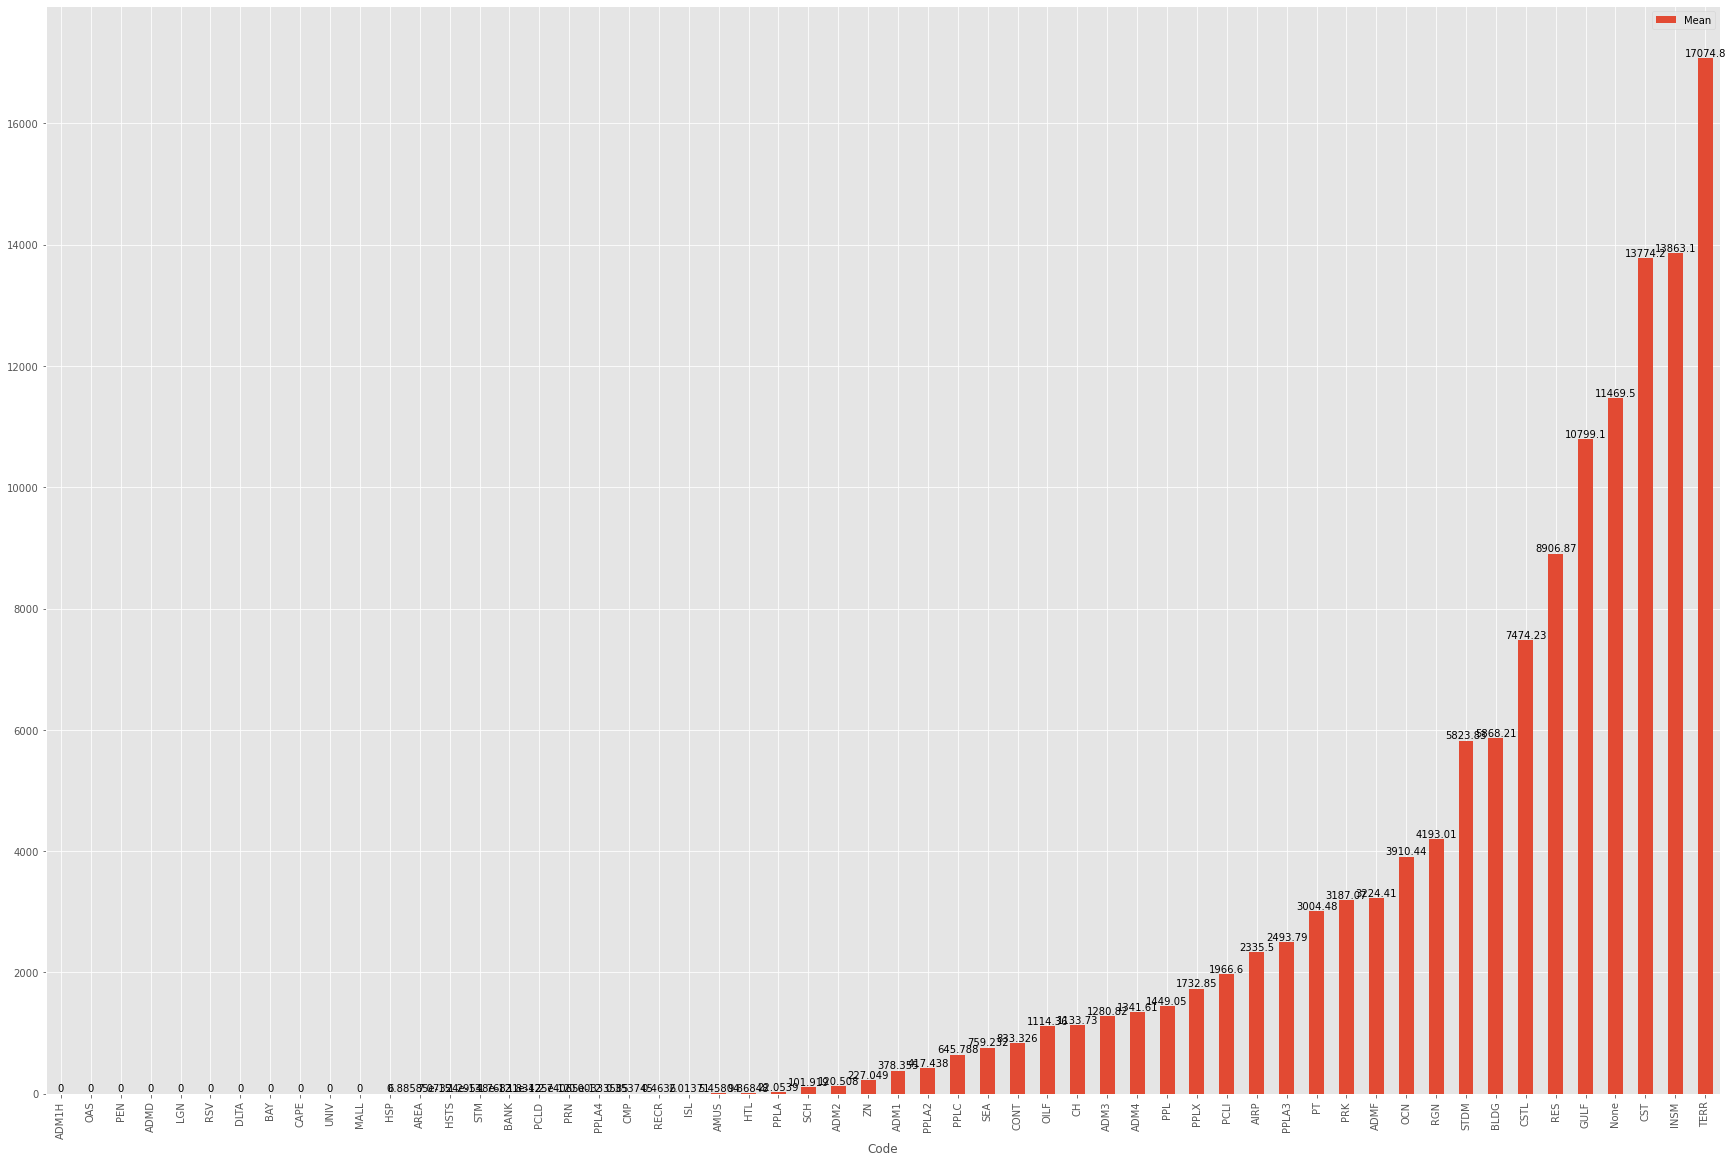

In [32]:
mean_errors_by_code = get_mean_error_by_feature_code(df_geocoded_hg, False)
ax = pd.DataFrame(mean_errors_by_code.items(), columns=['Code', 'Mean']).sort_values(by=['Mean']).plot.bar(x="Code", y="Mean", figsize=(30,20))
ax.bar_label(ax.containers[0])
print(mean_errors_by_code)

#### Erro por Feature Class

{'A': 1556.75546125112, 'S': 1925.1998863521003, 'P': 757.4956234817778, 'L': 1752.2386662795234, 'H': 2412.0718319073594, 'T': 401.1348797085766, None: 11469.506286630376}


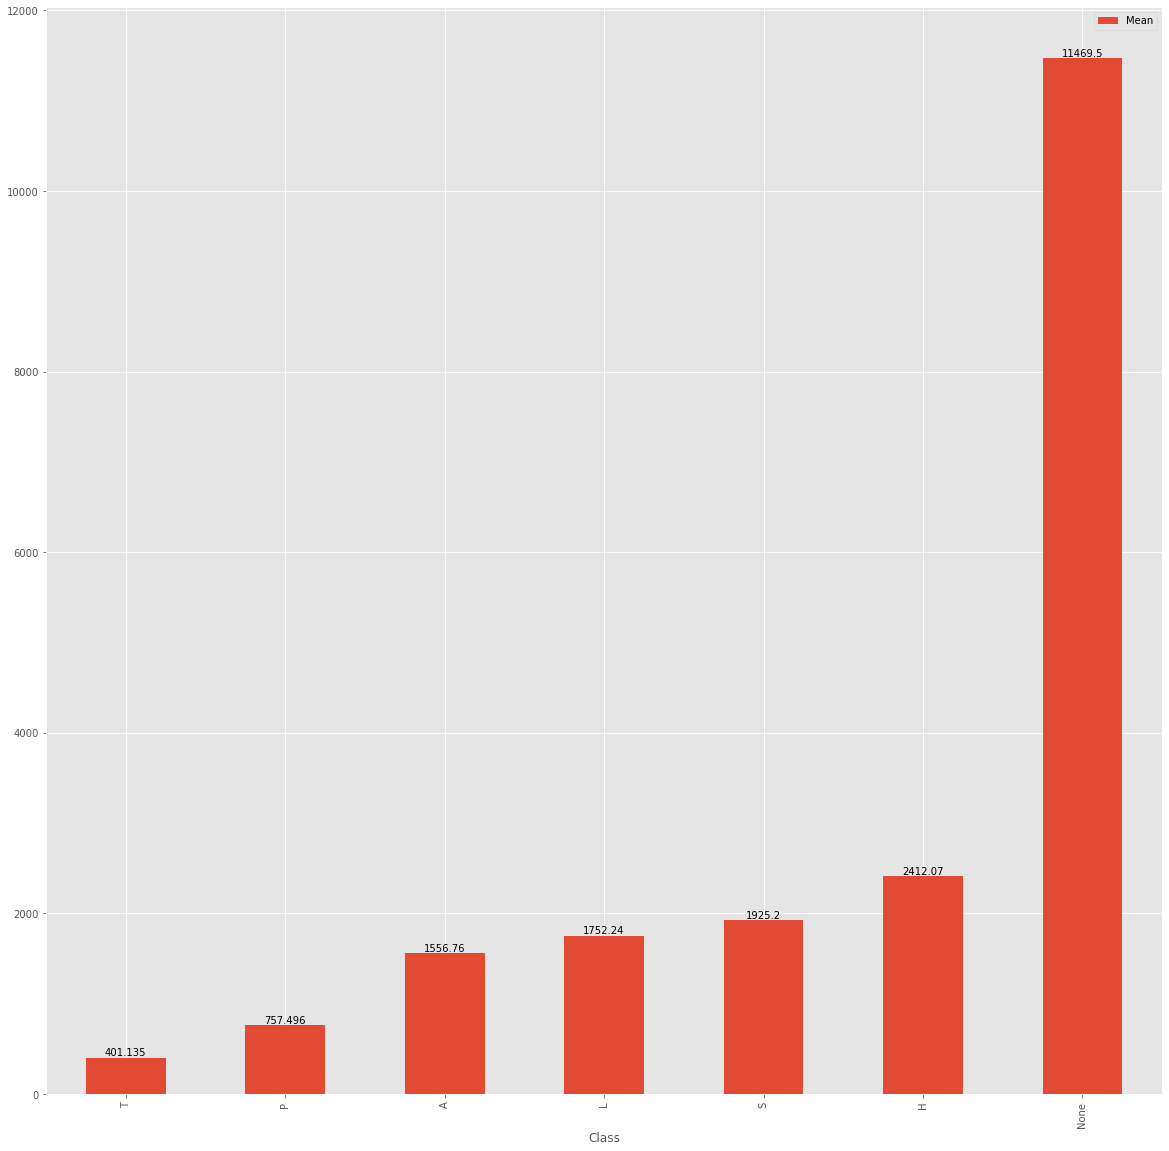

In [33]:
mean_errors_by_class = get_mean_error_by_feature_class(df_geocoded_hg, False)
ax = pd.DataFrame(mean_errors_by_class.items(), columns=['Class', 'Mean']).sort_values(by=['Mean']).plot.bar(x="Class", y="Mean", figsize=(20,20))
ax.bar_label(ax.containers[0])
print(mean_errors_by_class)

#### CamCoder vs HG

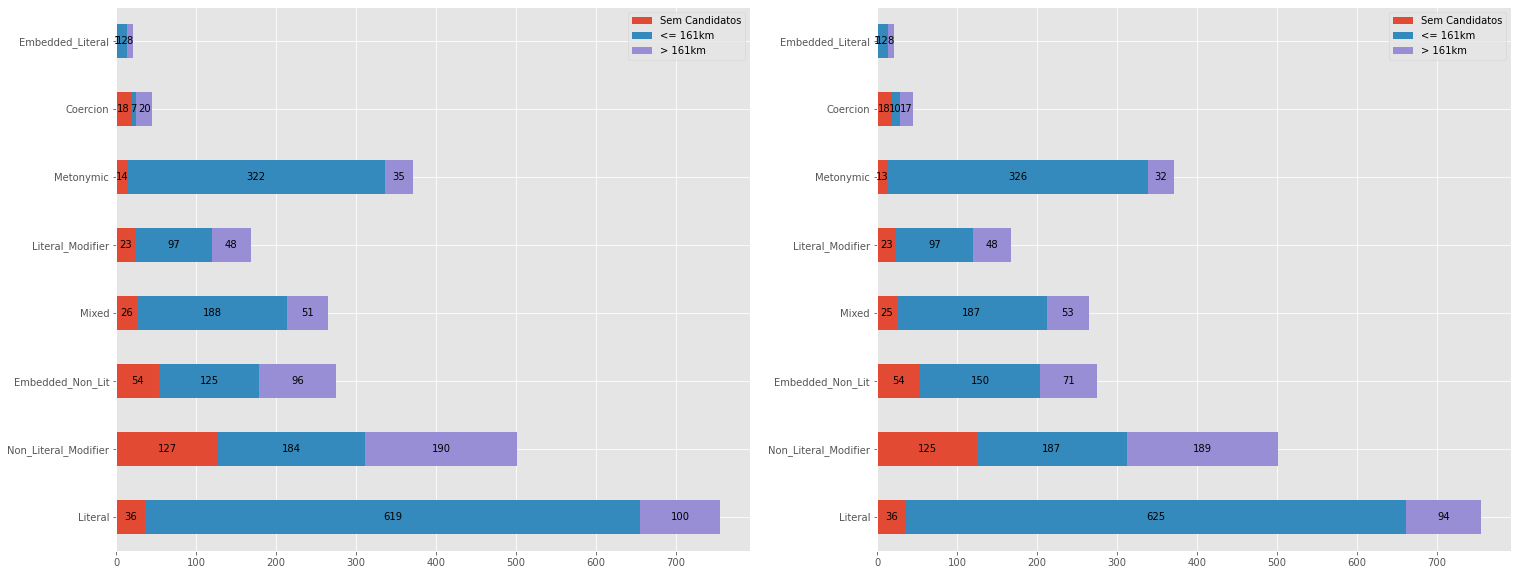

In [34]:
errors_by_type = count_errors_by_type(df_geocoded_hg)
df_errors_by_type_hg = pd.DataFrame(
    {key: pd.Series(value) for key, value in errors_by_type.items()})

plot_bars_stacked_diff(df_errors_by_type_camcoder, df_errors_by_type_hg)

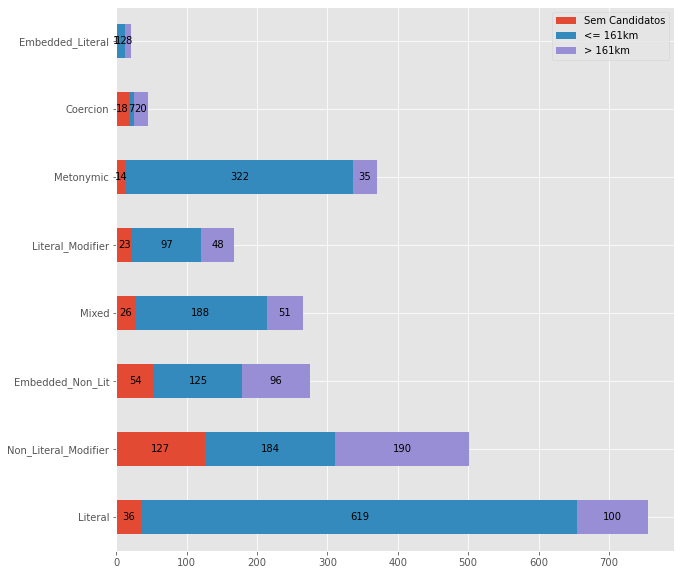

In [35]:
plot_bars_stacked(df_errors_by_type_camcoder)

### HG-A

In [36]:
df_geocoded_hga = df_geowebnews[['file', 'text', 'toponyms']].copy()
df_geocoded_hga['geocoded'] = df_geocoded_hga.progress_apply(lambda row: geocode_toponyms(geoparser, row.toponyms, exact_matching=True, process_demonyms=True, bounding_box=None, k=1, minimum_score=0, sort_by="population", minimization_classes=[], minimization_strategy="sum_dist"), axis=1)

unified_geocoded =  df_geocoded_hga['geocoded'].apply(lambda x: [t for t in x if t[4] is not None]).tolist()
unified_geocoded = [i for j in unified_geocoded for i in j]
print(len(unified_geocoded))

df_metrics_geocoded = pd.DataFrame(df_geocoded_hga.apply(lambda row: metrics(row.geocoded, row.toponyms, False, 161), axis=1).tolist(), index=df_geocoded_hga.index, columns=['Geotag Precision', 'Geotag Recall', 'Geotag F1-Score', 'Geocode Mean Distance', ' Geocode Within Min Distance', '@161 km', 'AUC', 'Pct predicted'])
df_metrics_geocoded.describe()

Progress:   0%|          | 0/200 [00:00<?, ?it/s]

2239


,Geotag Precision,Geotag Recall,Geotag F1-Score,Geocode Mean Distance,Geocode Within Min Distance,@161 km,AUC,Pct predicted
count,199.0,199.0,199.0,197.000000,197.000000,197.000000,191.000000,199.000000
mean,1.0,1.0,1.0,729.976503,0.818751,0.818751,0.163382,0.919988
std,0.0,0.0,0.0,1340.185650,0.241200,0.241200,0.165491,0.145839
min,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,1.0,1.0,0.283021,0.692308,0.692308,0.013102,0.875000
50%,1.0,1.0,1.0,60.508623,0.916667,0.916667,0.120312,1.000000
75%,1.0,1.0,1.0,954.246711,1.000000,1.000000,0.265173,1.000000
max,1.0,1.0,1.0,7474.234564,1.000000,1.000000,0.859172,1.000000


#### Erro por Feature Code

{'ADM1': 266.57599192639753, 'PCLI': 479.71135830166196, 'HSTS': 7.073240881894094e-13, 'PPLX': 1732.845218793279, 'PRK': 3187.0719389431074, 'CH': 1133.7280187760255, 'PPLC': 645.7880512485742, 'ADM2': 120.5075470006598, 'PPLA': 22.053857006756083, 'RSV': 0.0, 'PPL': 1449.0529643322354, 'AIRP': 2335.5048348174114, 'SCH': 101.91906807668589, 'CONT': 445.93074277524806, 'SEA': 759.2320849145984, 'ISL': 2.013713846455215, 'PPLA2': 417.43761776078463, 'RECR': 0.4635998893516881, 'CST': 13774.197279050024, 'OAS': 0.0, 'PCLD': 1.8342460361222026e-12, 'RGN': 4193.010879124662, 'BLDG': 5868.210326482537, 'PPLA3': 2493.79345534374, 'OCN': 3910.441120881665, 'STM': 1.2954756891516385e-12, 'HTL': 9.868477493462116, 'OILF': 1114.3640738098309, 'TERR': 17074.83847431701, 'GULF': 10799.11705745284, 'ADM3': 1280.8217069902382, 'DLTA': 0.0, 'ADM1H': 0.0, 'AREA': 6.885853888531454e-15, 'PEN': 0.0, 'BAY': 0.0, 'BANK': 1.7683102204735234e-12, 'AMUS': 5.458039627819612, 'CSTL': 7474.23456395642, 'CMP': 0

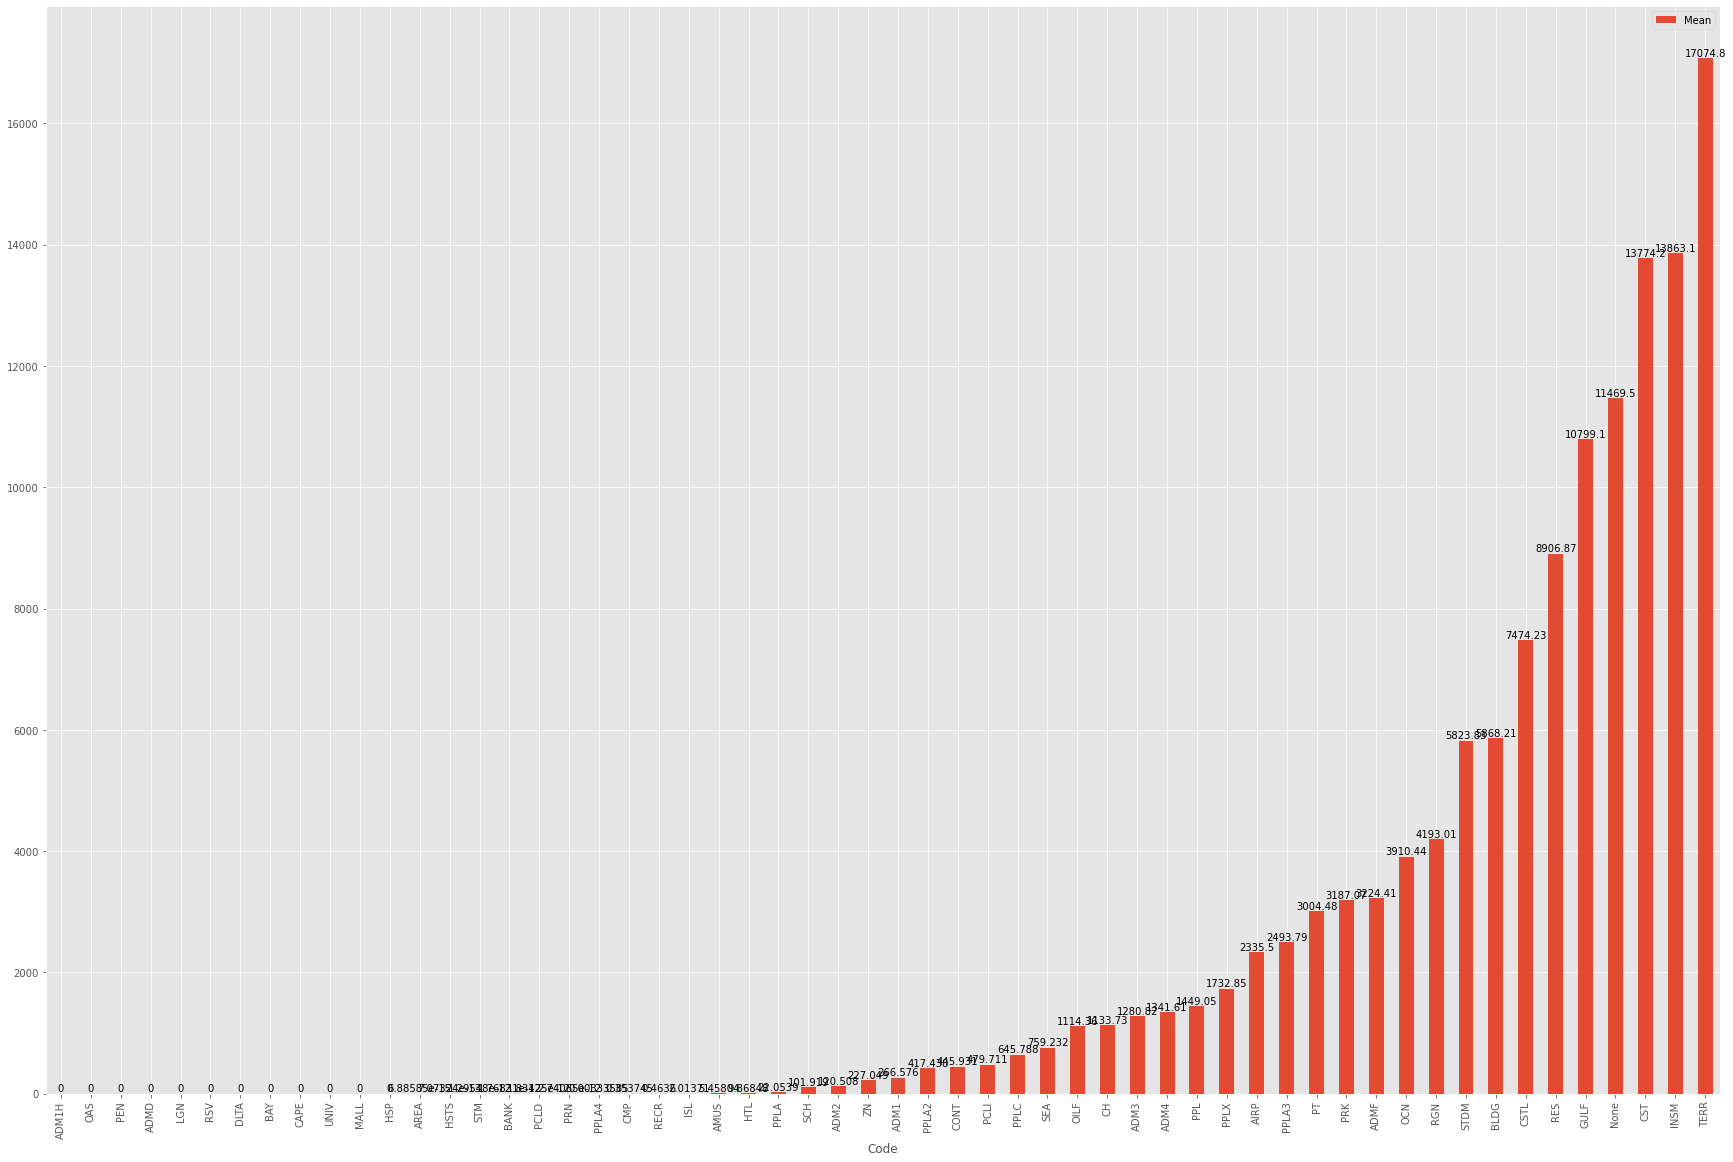

In [37]:
mean_errors_by_code = get_mean_error_by_feature_code(df_geocoded_hga, False)
ax = pd.DataFrame(mean_errors_by_code.items(), columns=['Code', 'Mean']).sort_values(by=['Mean']).plot.bar(x="Code", y="Mean", figsize=(30,20))
ax.bar_label(ax.containers[0])
print(mean_errors_by_code)

#### Erro por Feature Class

{'A': 439.9215112799454, 'S': 1925.1998863521003, 'P': 757.4956234817778, 'L': 1478.5102279927057, 'H': 2412.0718319073594, 'T': 401.1348797085766, None: 11469.506286630376}


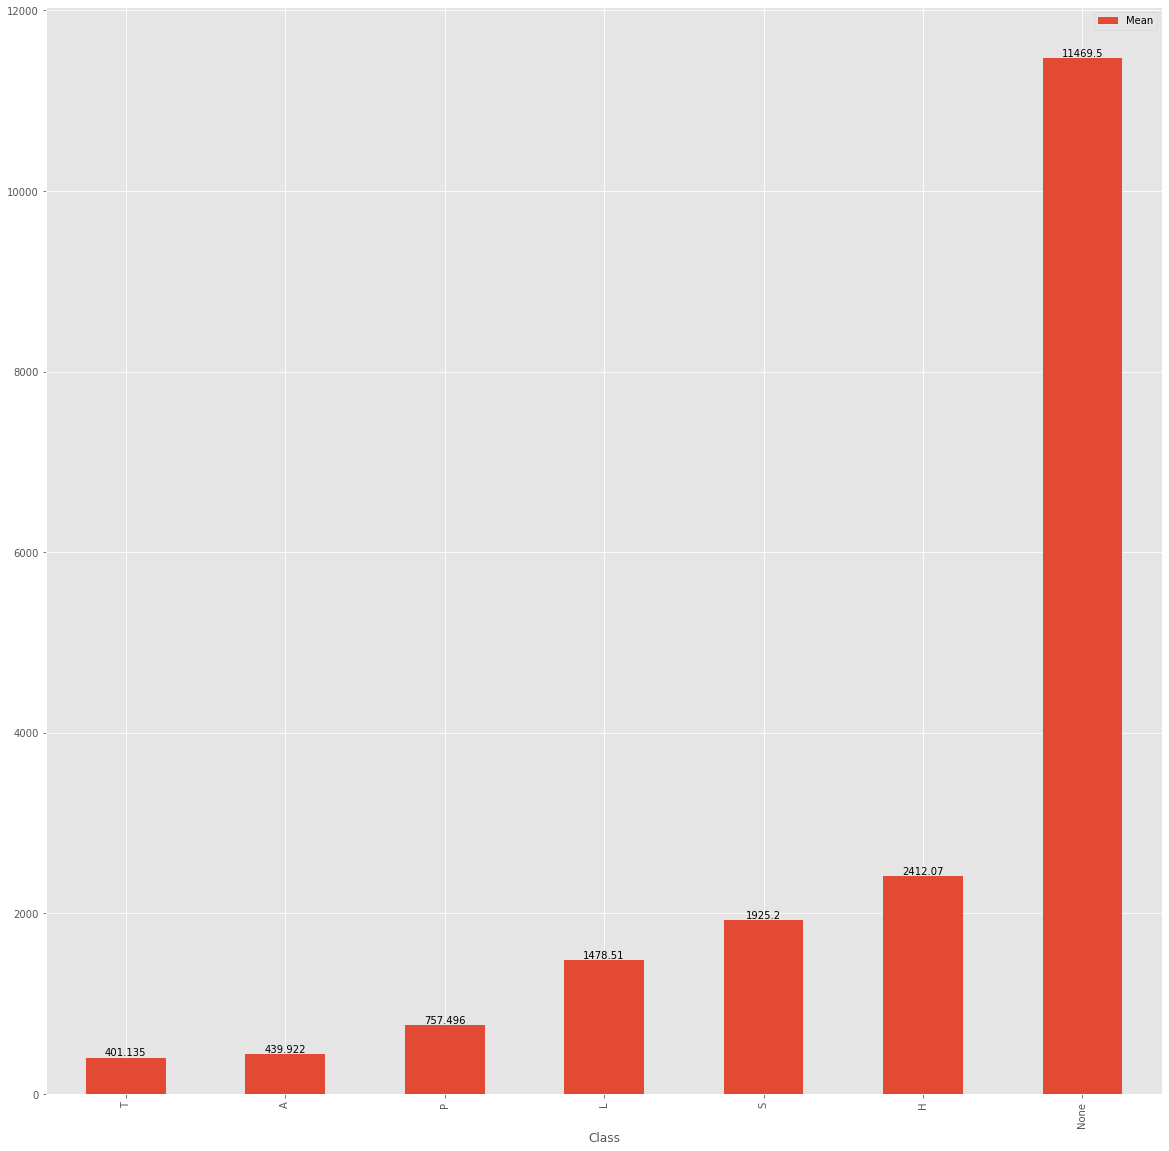

In [38]:
mean_errors_by_class = get_mean_error_by_feature_class(df_geocoded_hga, False)
ax = pd.DataFrame(mean_errors_by_class.items(), columns=['Class', 'Mean']).sort_values(by=['Mean']).plot.bar(x="Class", y="Mean", figsize=(20,20))
ax.bar_label(ax.containers[0])
print(mean_errors_by_class)

#### CamCoder vs HGA

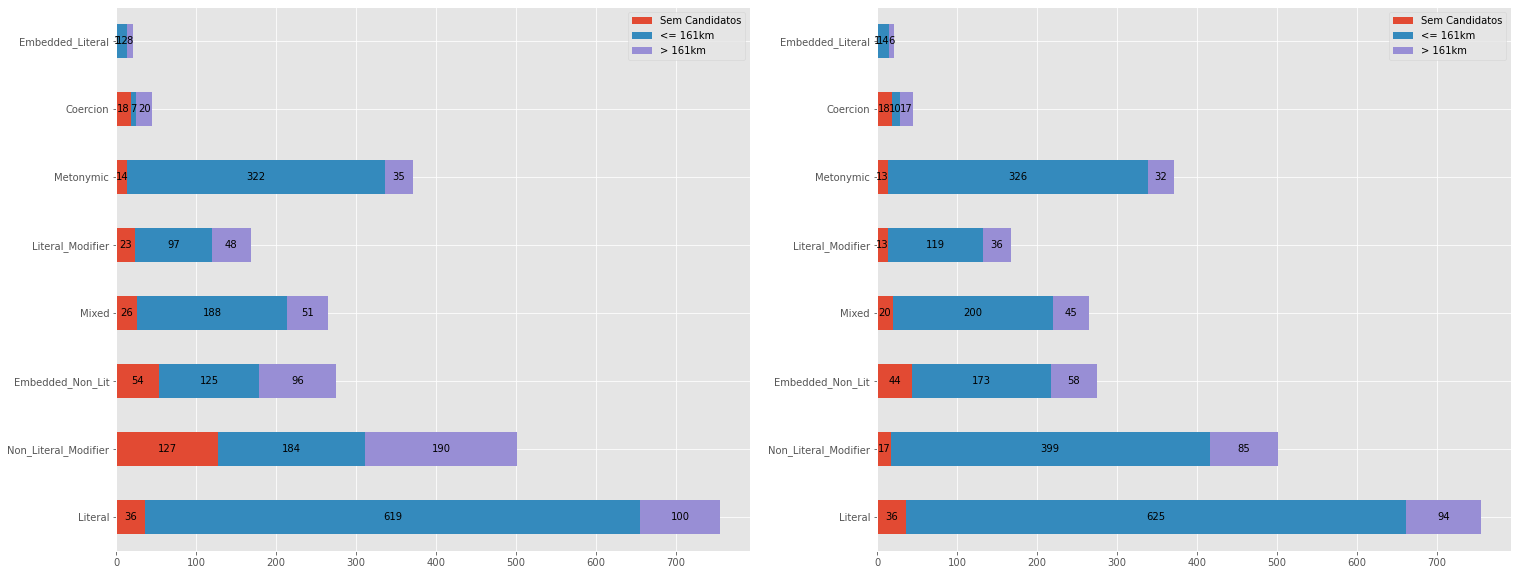

In [39]:
errors_by_type = count_errors_by_type(df_geocoded_hga)
df_errors_by_type_hga = pd.DataFrame(
    {key: pd.Series(value) for key, value in errors_by_type.items()})

plot_bars_stacked_diff(df_errors_by_type_camcoder, df_errors_by_type_hga)

### HG-T

In [40]:
df_geocoded_hgt = df_geowebnews[['file', 'text', 'toponyms']].copy()
df_geocoded_hgt['geocoded'] = df_geocoded_hgt.progress_apply(lambda row: geocode_toponyms(geoparser, row.toponyms, exact_matching=True, process_demonyms=False, bounding_box=None, k=5, minimum_score=0, sort_by="population", minimization_classes=["Literal", "Mixed", "Literal_Modifier", "Coercion", "Embedded_Literal"], minimization_strategy="pop_by_mean_dist"), axis=1)

unified_geocoded =  df_geocoded_hgt['geocoded'].apply(lambda x: [t for t in x if t[4] is not None]).tolist()
unified_geocoded = [i for j in unified_geocoded for i in j]
print(len(unified_geocoded))

df_metrics_geocoded = pd.DataFrame(df_geocoded_hgt.apply(lambda row: metrics(row.geocoded, row.toponyms, False, 161), axis=1).tolist(), index=df_geocoded_hgt.index, columns=['Geotag Precision', 'Geotag Recall', 'Geotag F1-Score', 'Geocode Mean Distance', ' Geocode Within Min Distance', '@161 km', 'AUC', 'Pct predicted'])
df_metrics_geocoded.describe()

Progress:   0%|          | 0/200 [00:00<?, ?it/s]

2106


,Geotag Precision,Geotag Recall,Geotag F1-Score,Geocode Mean Distance,Geocode Within Min Distance,@161 km,AUC,Pct predicted
count,199.0,199.0,199.0,196.000000,196.000000,196.000000,190.000000,199.000000
mean,1.0,1.0,1.0,1065.829266,0.777777,0.777777,0.198074,0.865168
std,0.0,0.0,0.0,1550.477554,0.249302,0.249302,0.174734,0.192001
min,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,1.0,1.0,1.406842,0.600000,0.600000,0.036395,0.771242
50%,1.0,1.0,1.0,339.793424,0.869318,0.869318,0.169274,0.953846
75%,1.0,1.0,1.0,1615.351345,1.000000,1.000000,0.310255,1.000000
max,1.0,1.0,1.0,7521.459917,1.000000,1.000000,0.859172,1.000000


#### Erro por Feature Code

{'ADM1': 285.2906151436677, 'PCLI': 1966.7079847506766, 'HSTS': 7.073240881894094e-13, 'PPLX': 1732.845218793279, 'PRK': 3187.0719389431074, 'CH': 1133.7280187760255, 'PPLC': 645.1508639376484, 'ADM2': 105.79548580468678, 'PPLA': 24.328554528521682, 'RSV': 0.0, 'PPL': 928.6825773136251, 'AIRP': 2335.5048348174114, 'SCH': 101.91906807668589, 'CONT': 833.3260749269305, 'SEA': 759.2320849145984, 'ISL': 11.475925586439926, 'PPLA2': 216.05988006437798, 'RECR': 0.4635998893516881, 'CST': 13774.197279050024, 'OAS': 0.0, 'PCLD': 1.8342460361222026e-12, 'RGN': 4193.010879124662, 'BLDG': 5868.210326482537, 'PPLA3': 2493.2889351076396, 'OCN': 3910.441120881665, 'STM': 1.2954756891516385e-12, 'HTL': 9.868477493462116, 'OILF': 1114.3640738098309, 'TERR': 17074.83847431701, 'GULF': 10799.11705745284, 'ADM3': 46.15111567832739, 'DLTA': 0.0, 'ADM1H': 0.0, 'AREA': 6.885853888531454e-15, 'PEN': 0.0, 'BAY': 0.0, 'BANK': 1.7683102204735234e-12, 'AMUS': 5.458039627819612, 'CSTL': 7474.23456395642, 'CMP': 0

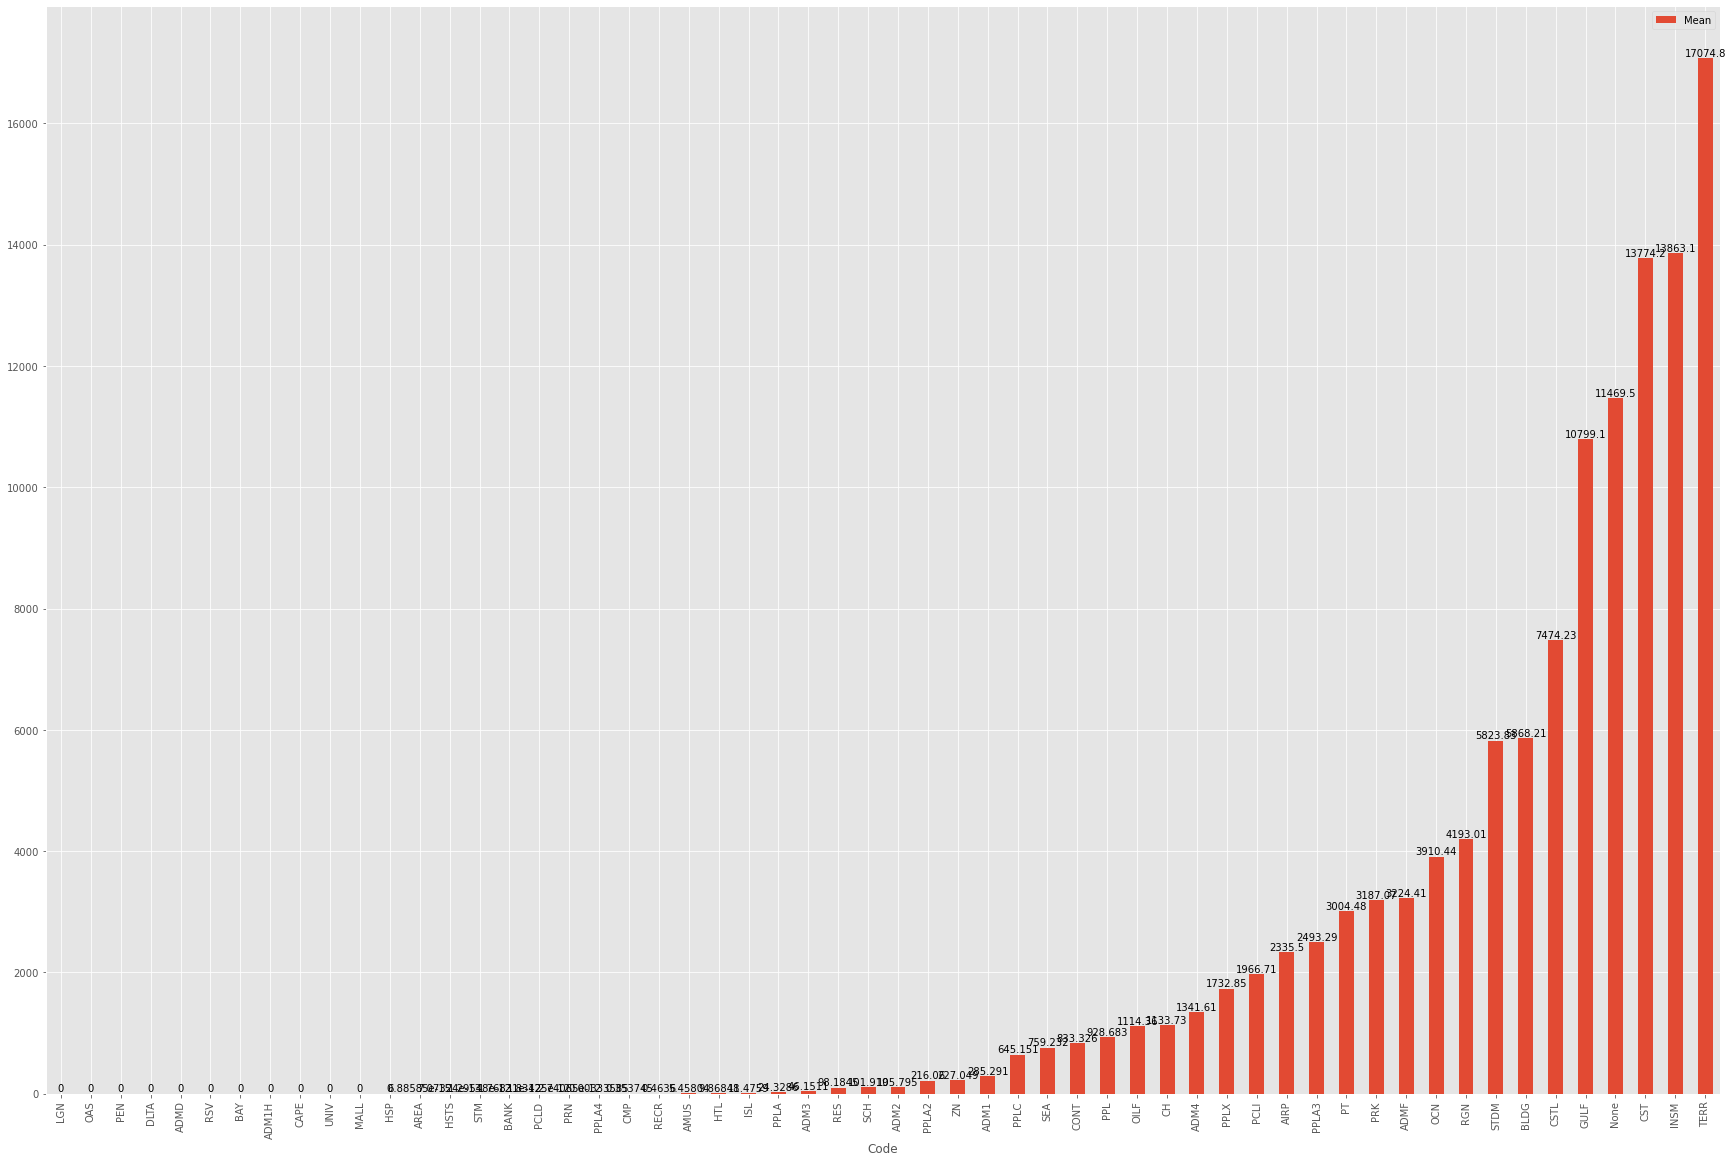

In [41]:
mean_errors_by_code = get_mean_error_by_feature_code(df_geocoded_hgt, False)
ax = pd.DataFrame(mean_errors_by_code.items(), columns=['Code', 'Mean']).sort_values(by=['Mean']).plot.bar(x="Code", y="Mean", figsize=(30,20))
ax.bar_label(ax.containers[0])
print(mean_errors_by_code)

#### Erro por Feature Class

{'A': 1533.4750295277568, 'S': 1925.1998863521003, 'P': 567.9719009813543, 'L': 1593.9988030453587, 'H': 2412.0718319073594, 'T': 403.6581361725725, None: 11469.506286630376}


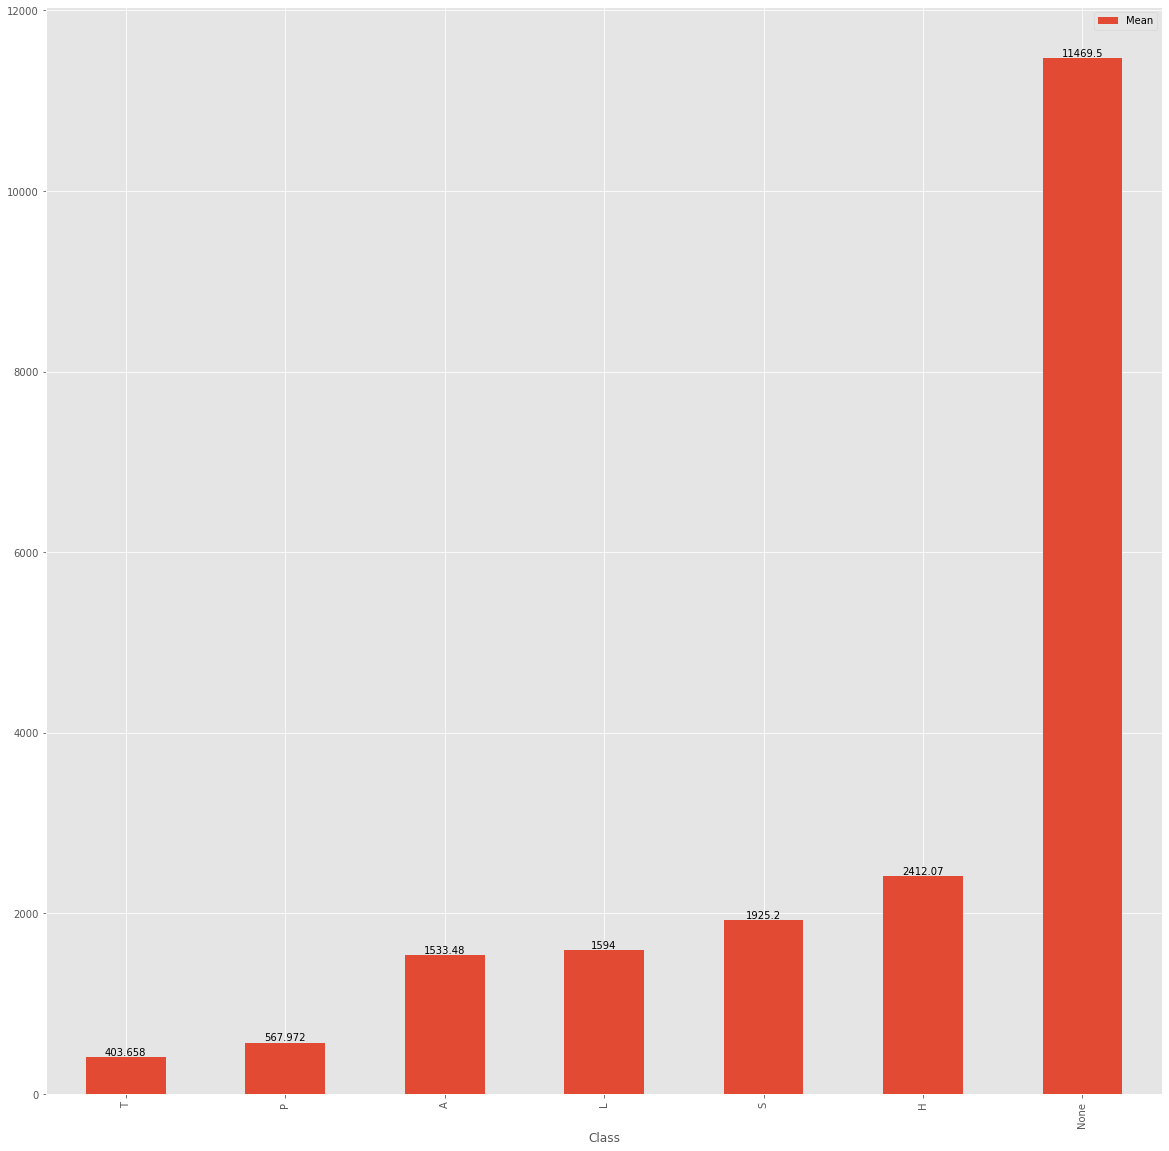

In [42]:
mean_errors_by_class = get_mean_error_by_feature_class(df_geocoded_hgt, False)
ax = pd.DataFrame(mean_errors_by_class.items(), columns=['Class', 'Mean']).sort_values(by=['Mean']).plot.bar(x="Class", y="Mean", figsize=(20,20))
ax.bar_label(ax.containers[0])
print(mean_errors_by_class)

#### CamCoder vs HGT

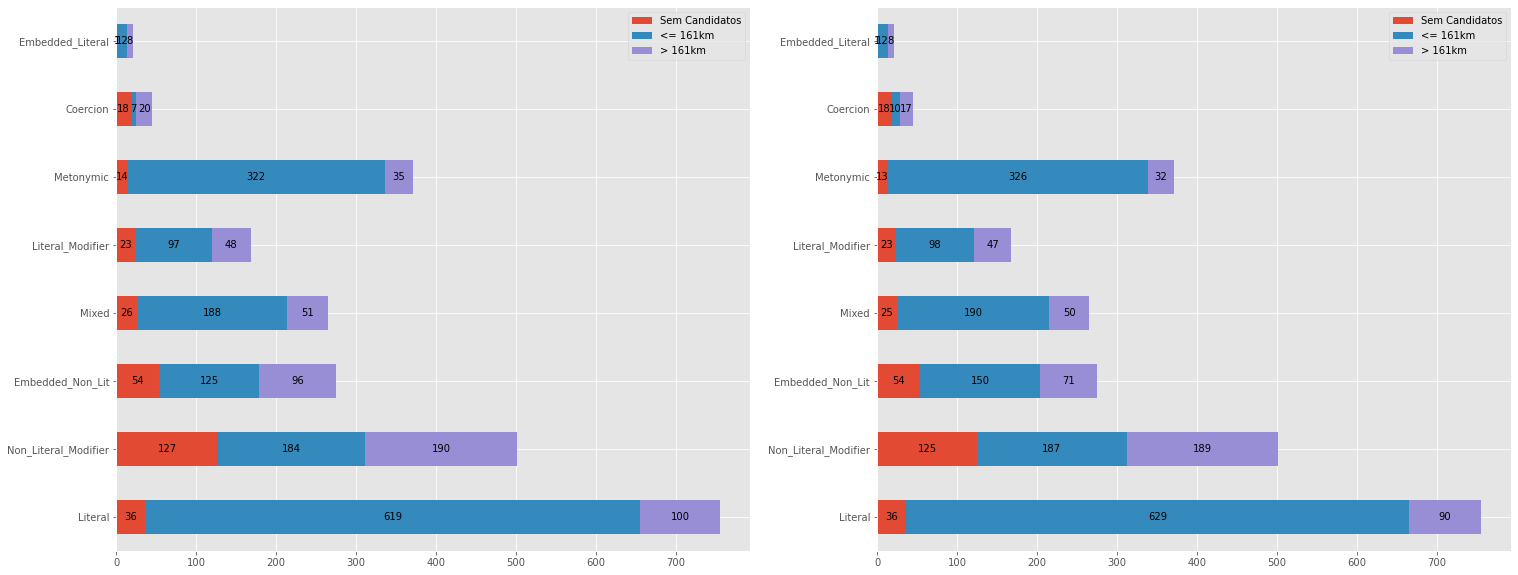

In [43]:
errors_by_type = count_errors_by_type(df_geocoded_hgt)
df_errors_by_type_hgt = pd.DataFrame(
    {key: pd.Series(value) for key, value in errors_by_type.items()})

plot_bars_stacked_diff(df_errors_by_type_camcoder, df_errors_by_type_hgt)

### HG-AT

In [44]:
df_geocoded_hgat = df_geowebnews[['file', 'text', 'toponyms']].copy()
df_geocoded_hgat['geocoded'] = df_geocoded_hgat.progress_apply(lambda row: geocode_toponyms(geoparser, row.toponyms, exact_matching=True, process_demonyms=True, bounding_box=None, k=5, minimum_score=0, sort_by="population", minimization_classes=["Literal", "Mixed", "Literal_Modifier", "Coercion", "Embedded_Literal"], minimization_strategy="pop_by_mean_dist"), axis=1)

unified_geocoded =  df_geocoded_hgat['geocoded'].apply(lambda x: [t for t in x if t[4] is not None]).tolist()
unified_geocoded = [i for j in unified_geocoded for i in j]
print(len(unified_geocoded))

df_metrics_geocoded = pd.DataFrame(df_geocoded_hgat.apply(lambda row: metrics(row.geocoded, row.toponyms, False, 161), axis=1).tolist(), index=df_geocoded_hgat.index, columns=['Geotag Precision', 'Geotag Recall', 'Geotag F1-Score', 'Geocode Mean Distance', ' Geocode Within Min Distance', '@161 km', 'AUC', 'Pct predicted'])
df_metrics_geocoded.describe()

Progress:   0%|          | 0/200 [00:00<?, ?it/s]

2239


,Geotag Precision,Geotag Recall,Geotag F1-Score,Geocode Mean Distance,Geocode Within Min Distance,@161 km,AUC,Pct predicted
count,199.0,199.0,199.0,197.000000,197.000000,197.000000,191.000000,199.000000
mean,1.0,1.0,1.0,633.379932,0.825252,0.825252,0.156947,0.919988
std,0.0,0.0,0.0,1231.057199,0.237108,0.237108,0.160361,0.145839
min,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,1.0,1.0,0.283021,0.714286,0.714286,0.013102,0.875000
50%,1.0,1.0,1.0,49.092268,0.923077,0.923077,0.120312,1.000000
75%,1.0,1.0,1.0,658.223281,1.000000,1.000000,0.247123,1.000000
max,1.0,1.0,1.0,7474.234564,1.000000,1.000000,0.859172,1.000000


#### Erro por Feature Code

{'ADM1': 173.51119133231748, 'PCLI': 479.80275634551066, 'HSTS': 7.073240881894094e-13, 'PPLX': 1732.845218793279, 'PRK': 3187.0719389431074, 'CH': 1133.7280187760255, 'PPLC': 645.760858919641, 'ADM2': 105.79548580468678, 'PPLA': 24.328554528521682, 'RSV': 0.0, 'PPL': 928.6912634327458, 'AIRP': 2335.5048348174114, 'SCH': 101.91906807668589, 'CONT': 445.93074277524806, 'SEA': 759.2320849145984, 'ISL': 11.475925586439926, 'PPLA2': 216.05988006437798, 'RECR': 0.4635998893516881, 'CST': 13774.197279050024, 'OAS': 0.0, 'PCLD': 1.8342460361222026e-12, 'RGN': 4193.010879124662, 'BLDG': 5868.210326482537, 'PPLA3': 2493.2889351076396, 'OCN': 3910.441120881665, 'STM': 1.2954756891516385e-12, 'HTL': 9.868477493462116, 'OILF': 1114.3640738098309, 'TERR': 17074.83847431701, 'GULF': 10799.11705745284, 'ADM3': 46.15111567832739, 'DLTA': 0.0, 'ADM1H': 0.0, 'AREA': 6.885853888531454e-15, 'PEN': 0.0, 'BAY': 0.0, 'BANK': 1.7683102204735234e-12, 'AMUS': 5.458039627819612, 'CSTL': 7474.23456395642, 'CMP': 

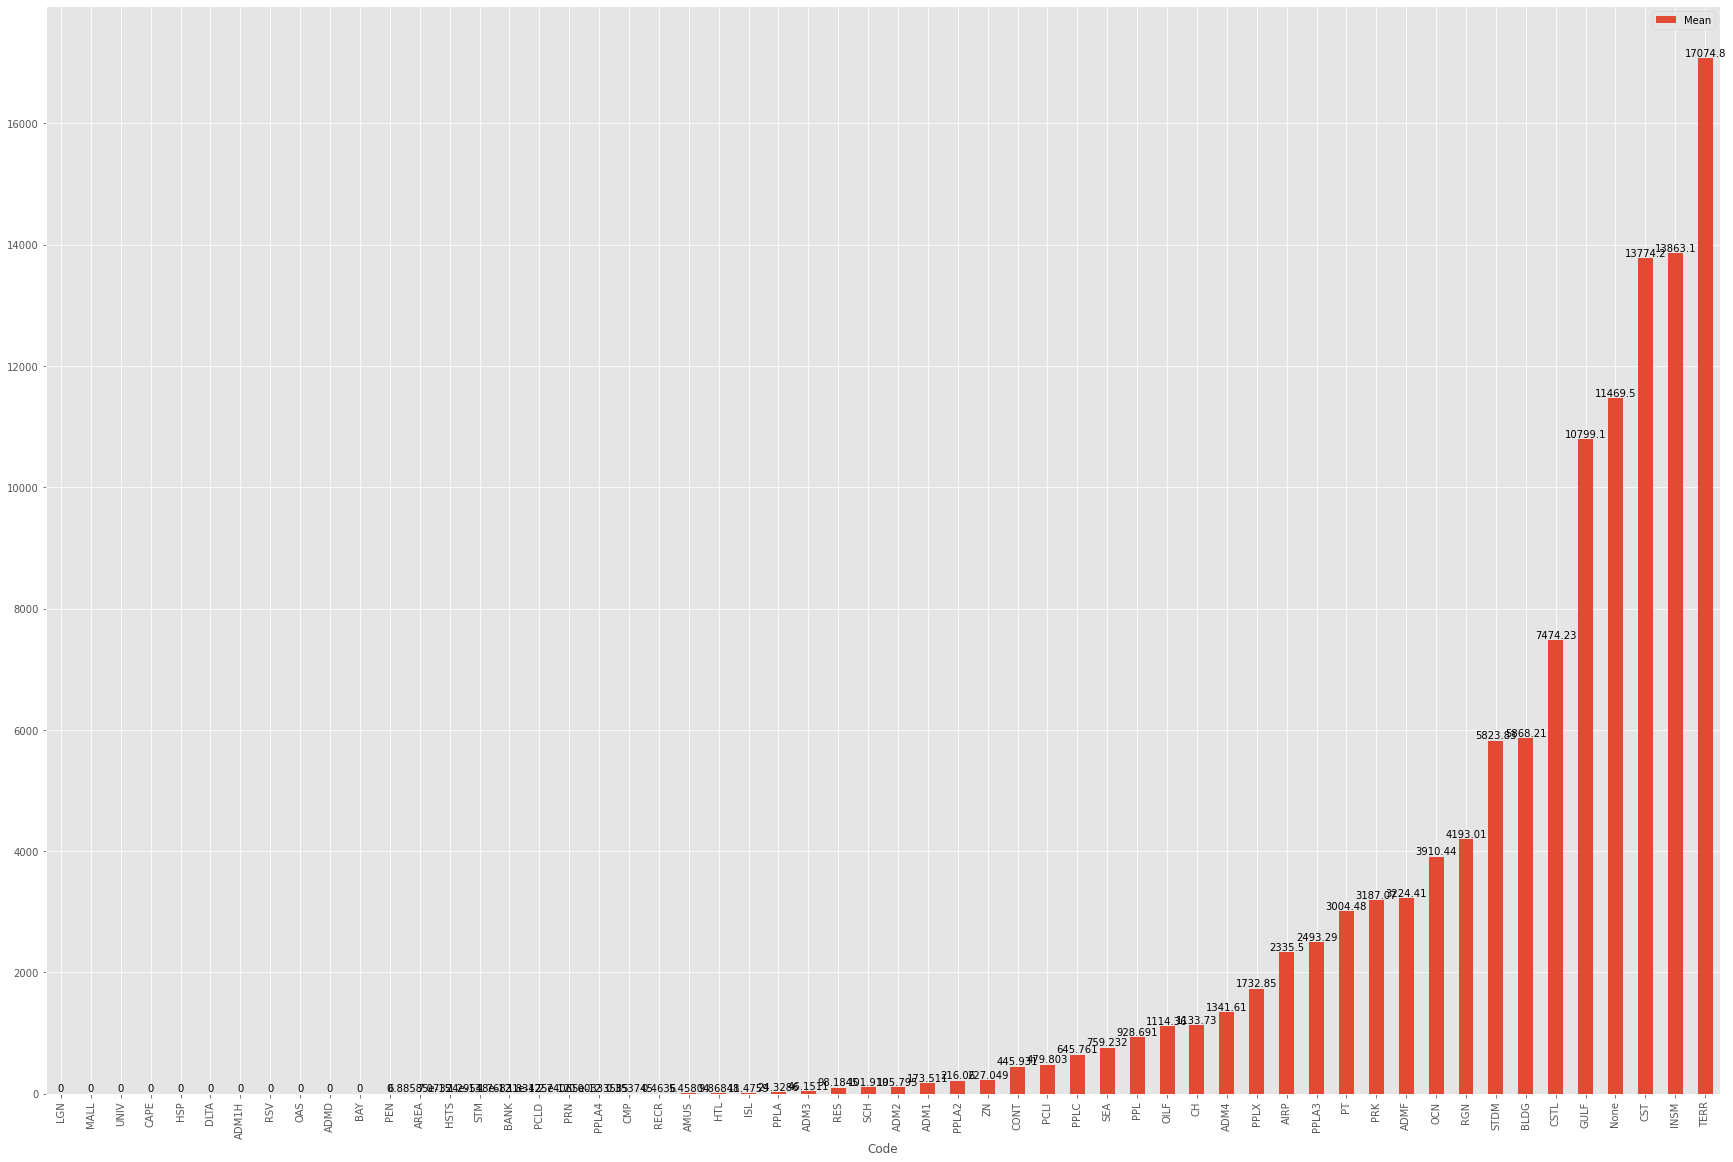

In [45]:
mean_errors_by_code = get_mean_error_by_feature_code(df_geocoded_hgat, False)
ax = pd.DataFrame(mean_errors_by_code.items(), columns=['Code', 'Mean']).sort_values(by=['Mean']).plot.bar(x="Code", y="Mean", figsize=(30,20))
ax.bar_label(ax.containers[0])
print(mean_errors_by_code)

#### Erro por Feature Class

{'A': 418.9061105874579, 'S': 1925.1998863521003, 'P': 568.1476102306586, 'L': 1320.270364758541, 'H': 2412.0718319073594, 'T': 403.6581361725725, None: 11469.506286630376}


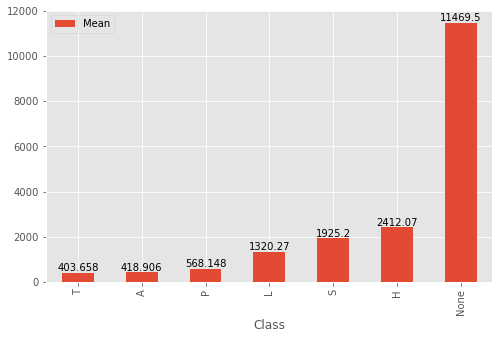

In [46]:
mean_errors_by_class = get_mean_error_by_feature_class(df_geocoded_hgat, False)
ax = pd.DataFrame(mean_errors_by_class.items(), columns=['Class', 'Mean']).sort_values(by=['Mean']).plot.bar(x="Class", y="Mean", figsize=(8,5))
ax.bar_label(ax.containers[0])
print(mean_errors_by_class)

#### CamCoder vs HGAT

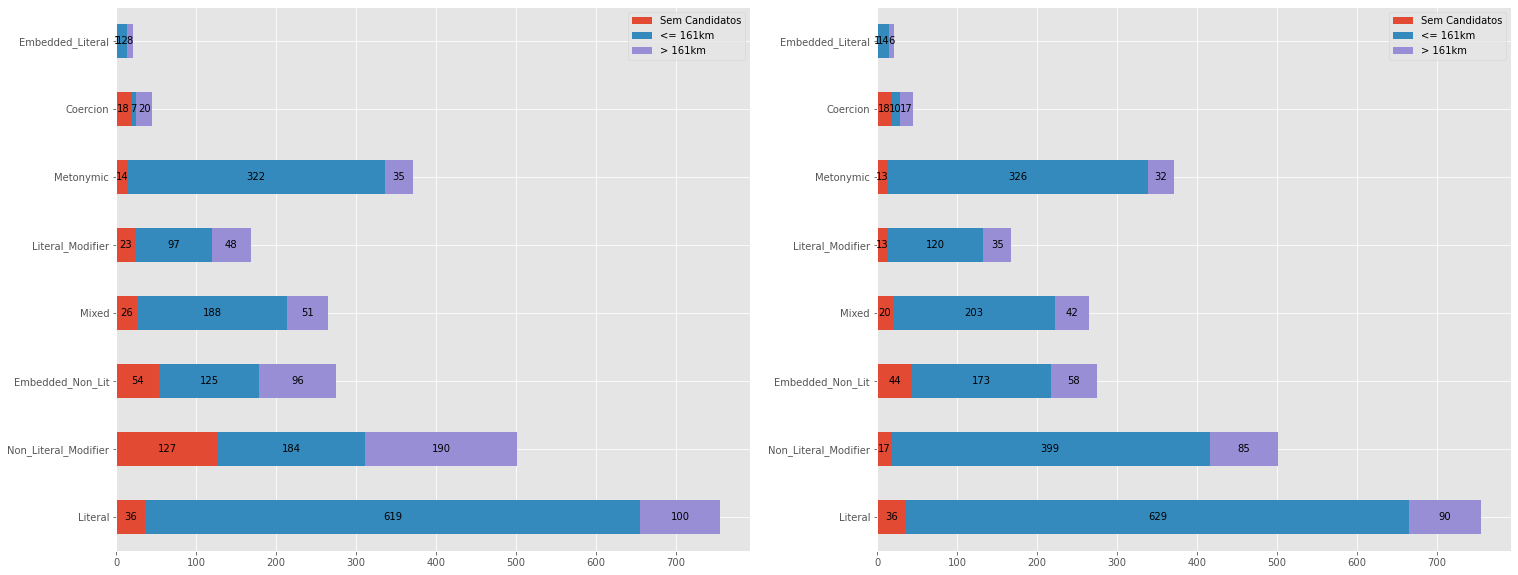

In [47]:
errors_by_type = count_errors_by_type(df_geocoded_hgat)
df_errors_by_type_hgat = pd.DataFrame(
    {key: pd.Series(value) for key, value in errors_by_type.items()})

plot_bars_stacked_diff(df_errors_by_type_camcoder, df_errors_by_type_hgat)

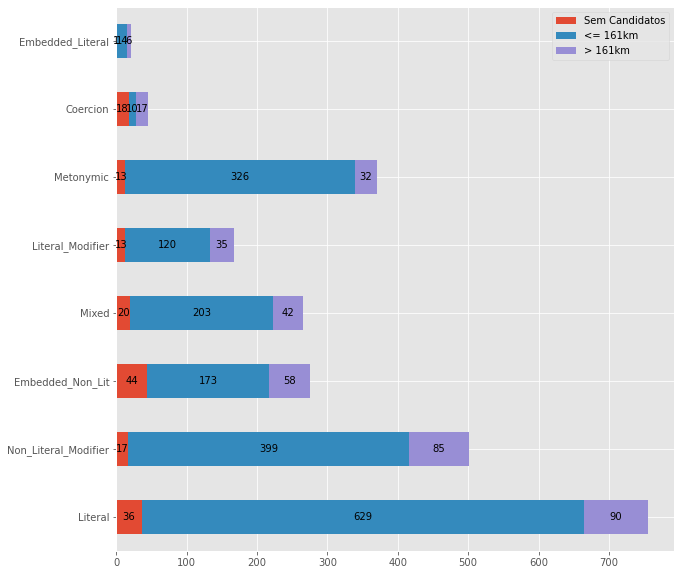

In [48]:
plot_bars_stacked(df_errors_by_type_hgat)

<AxesSubplot:>

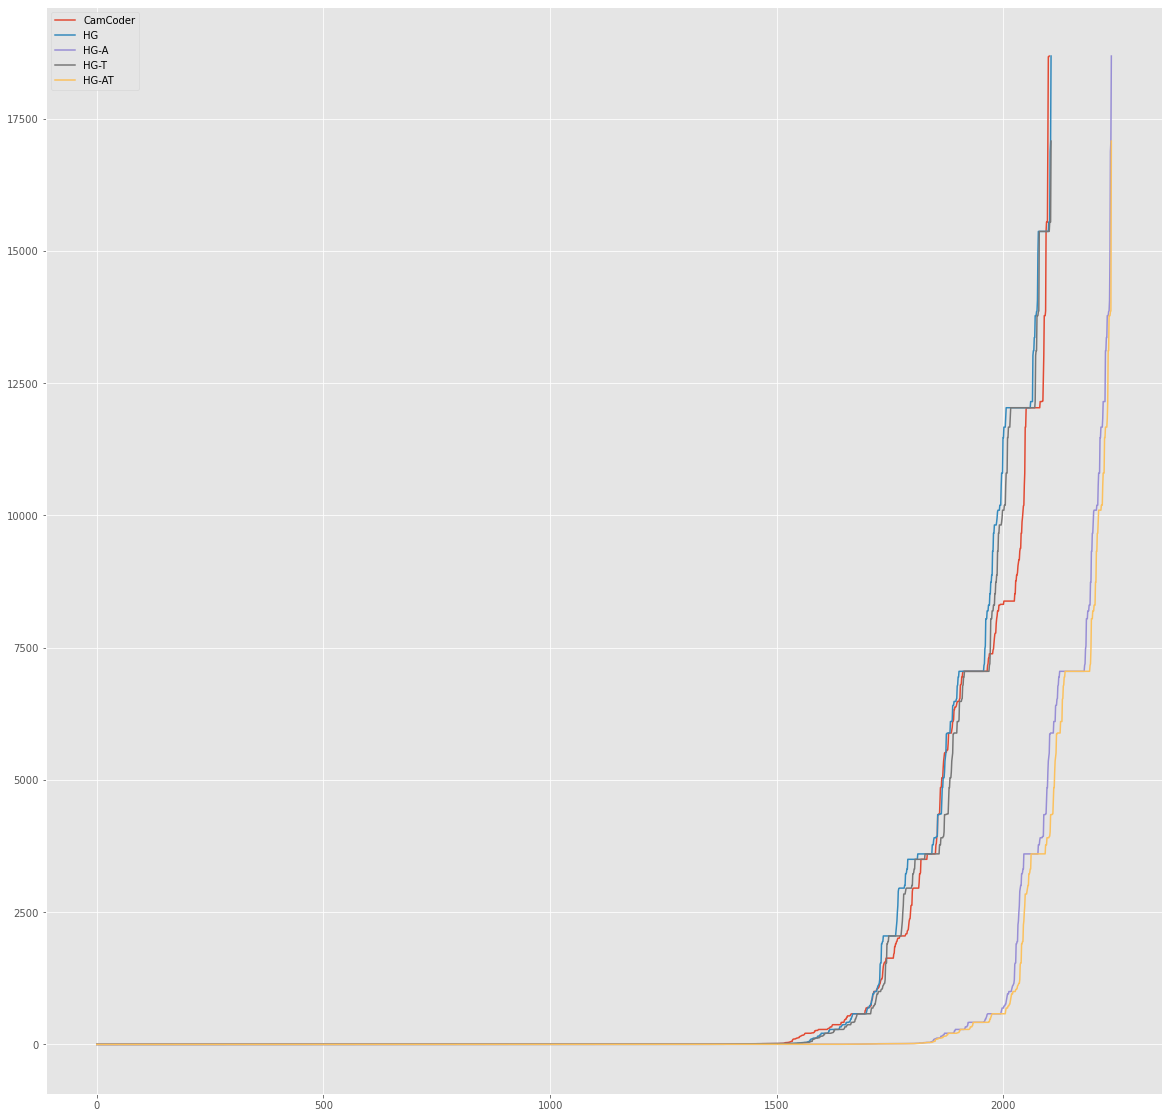

In [49]:
distances_camcoder = sorted([i for j in df_geocoded_camcoder.apply(lambda row: get_prediction_errors(row.geocoded, row.toponyms, False), axis=1).tolist() for i in j])
distances_hg = sorted([i for j in df_geocoded_hg.apply(lambda row: get_prediction_errors(row.geocoded, row.toponyms, False), axis=1).tolist() for i in j])
distances_hga = sorted([i for j in df_geocoded_hga.apply(lambda row: get_prediction_errors(row.geocoded, row.toponyms, False), axis=1).tolist() for i in j])
distances_hgt = sorted([i for j in df_geocoded_hgt.apply(lambda row: get_prediction_errors(row.geocoded, row.toponyms, False), axis=1).tolist() for i in j])
distances_hgat = sorted([i for j in df_geocoded_hgat.apply(lambda row: get_prediction_errors(row.geocoded, row.toponyms, False), axis=1).tolist() for i in j])
distances_dict = { "CamCoder": distances_camcoder, "HG": distances_hg, "HG-A": distances_hga, "HG-T": distances_hgt, "HG-AT": distances_hgat}
df_errors = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in distances_dict.items() ]))
df_errors[["CamCoder", "HG", "HG-A", "HG-T", "HG-AT"]].plot(figsize=(20,20))

### Mesmos Topônimos

In [50]:
toponyms_in = []
for (i, toponyms), (j, geocoded_hg), (k, geocoded_hga), (l, geocoded_hgt), (m, geocoded_hgat), (n, geocoded_cc) in zip(df_geowebnews[['toponyms']].iterrows(), df_geocoded_hg[["geocoded"]].iterrows(), df_geocoded_hga[["geocoded"]].iterrows(), df_geocoded_hgt[["geocoded"]].iterrows(), df_geocoded_hgat[["geocoded"]].iterrows(), df_geocoded_camcoder[["geocoded"]].iterrows()):
    found_hg = []
    truth = toponyms[0].copy()
    for pred in geocoded_hg[0]:
        for _, gt in enumerate(truth[:]):
            if ner_equal(pred, gt, exact_match=False) and pred[4] is not None:
                found_hg.append(gt)
                del truth[_]
                break
                
    found_hga = []
    truth = toponyms[0].copy()
    for pred in geocoded_hga[0]:
        for _, gt in enumerate(truth[:]):
            if ner_equal(pred, gt, exact_match=False) and pred[4] is not None:
                found_hga.append(gt)
                del truth[_]
                break
                
    found_hgt = []
    truth = toponyms[0].copy()
    for pred in geocoded_hgt[0]:
        for _, gt in enumerate(truth[:]):
            if ner_equal(pred, gt, exact_match=False) and pred[4] is not None:
                found_hgt.append(gt)
                del truth[_]
                break
                
    found_hgat = []
    truth = toponyms[0].copy()
    for pred in geocoded_hgat[0]:
        for _, gt in enumerate(truth[:]):
            if ner_equal(pred, gt, exact_match=False) and pred[4] is not None:
                found_hgat.append(gt)
                del truth[_]
                break
                
    found_cc = []
    truth = toponyms[0].copy()
    for pred in geocoded_cc[0]:
        for _, gt in enumerate(truth[:]):
            if ner_equal(pred, gt, exact_match=False) and pred[4] is not None:
                found_cc.append(gt)
                del truth[_]
                break
    
    found_in = set.intersection(*map(set, [found_hg, found_hga, found_hgt, found_hgat, found_cc]))
    toponyms_in.append(list(found_in))    

toponyms_in = pd.DataFrame({"toponyms_in": toponyms_in})

In [51]:
unified_geocoded =  toponyms_in["toponyms_in"].tolist()
unified_geocoded = [i for j in unified_geocoded for i in j]
print(len(unified_geocoded))

2102


#### HG

In [52]:
df_geocoded_hg["toponyms_in"] = toponyms_in
df_metrics_geocoded = pd.DataFrame(df_geocoded_hg.apply(lambda row: metrics(row.geocoded, row.toponyms_in, False, 161), axis=1).tolist(), index=df_geocoded_hg.index, columns=['Geotag Precision', 'Geotag Recall', 'Geotag F1-Score', 'Geocode Mean Distance', ' Geocode Within Min Distance', '@161 km', 'AUC', 'Pct predicted'])
df_metrics_geocoded.describe()

,Geotag Precision,Geotag Recall,Geotag F1-Score,Geocode Mean Distance,Geocode Within Min Distance,@161 km,AUC,Pct predicted
count,199.000000,196.0,196.000000,196.000000,196.000000,196.000000,190.000000,196.0
mean,0.863545,1.0,0.925237,1157.784200,0.771681,0.771681,0.204460,1.0
std,0.192605,0.0,0.107238,1606.077945,0.251716,0.251716,0.177653,0.0
min,0.000000,1.0,0.400000,0.000000,0.000000,0.000000,0.000000,1.0
25%,0.771242,1.0,0.875000,1.406842,0.600000,0.600000,0.037822,1.0
50%,0.947368,1.0,0.977078,374.636829,0.857143,0.857143,0.176096,1.0
75%,1.000000,1.0,1.000000,1895.729480,1.000000,1.000000,0.319624,1.0
max,1.000000,1.0,1.000000,7521.459917,1.000000,1.000000,0.859172,1.0


#### HG-A

In [53]:
df_geocoded_hga["toponyms_in"] = toponyms_in
df_metrics_geocoded = pd.DataFrame(df_geocoded_hga.apply(lambda row: metrics(row.geocoded, row.toponyms_in, False, 161), axis=1).tolist(), index=df_geocoded_hga.index, columns=['Geotag Precision', 'Geotag Recall', 'Geotag F1-Score', 'Geocode Mean Distance', ' Geocode Within Min Distance', '@161 km', 'AUC', 'Pct predicted'])
df_metrics_geocoded.describe()

,Geotag Precision,Geotag Recall,Geotag F1-Score,Geocode Mean Distance,Geocode Within Min Distance,@161 km,AUC,Pct predicted
count,199.000000,196.0,196.000000,196.000000,196.000000,196.000000,190.000000,196.0
mean,0.863545,1.0,0.925237,751.253401,0.813993,0.813993,0.167742,1.0
std,0.192605,0.0,0.107238,1358.503972,0.242896,0.242896,0.166071,0.0
min,0.000000,1.0,0.400000,0.000000,0.000000,0.000000,0.000000,1.0
25%,0.771242,1.0,0.875000,0.703164,0.685897,0.685897,0.015654,1.0
50%,0.947368,1.0,0.977078,64.197455,0.912879,0.912879,0.124951,1.0
75%,1.000000,1.0,1.000000,974.153806,1.000000,1.000000,0.272324,1.0
max,1.000000,1.0,1.000000,7474.234564,1.000000,1.000000,0.859172,1.0


#### HG-T

In [54]:
df_geocoded_hgt["toponyms_in"] = toponyms_in
df_metrics_geocoded = pd.DataFrame(df_geocoded_hgt.apply(lambda row: metrics(row.geocoded, row.toponyms_in, False, 161), axis=1).tolist(), index=df_geocoded_hgt.index, columns=['Geotag Precision', 'Geotag Recall', 'Geotag F1-Score', 'Geocode Mean Distance', ' Geocode Within Min Distance', '@161 km', 'AUC', 'Pct predicted'])
df_metrics_geocoded.describe()

,Geotag Precision,Geotag Recall,Geotag F1-Score,Geocode Mean Distance,Geocode Within Min Distance,@161 km,AUC,Pct predicted
count,199.000000,196.0,196.000000,196.000000,196.000000,196.000000,190.000000,196.0
mean,0.863545,1.0,0.925237,1060.668945,0.778190,0.778190,0.197818,1.0
std,0.192605,0.0,0.107238,1543.034846,0.249087,0.249087,0.174502,0.0
min,0.000000,1.0,0.400000,0.000000,0.000000,0.000000,0.000000,1.0
25%,0.771242,1.0,0.875000,1.406842,0.600000,0.600000,0.036395,1.0
50%,0.947368,1.0,0.977078,339.793424,0.865152,0.865152,0.169274,1.0
75%,1.000000,1.0,1.000000,1615.351345,1.000000,1.000000,0.308239,1.0
max,1.000000,1.0,1.000000,7521.459917,1.000000,1.000000,0.859172,1.0


#### HG-AT

In [55]:
df_geocoded_hgat["toponyms_in"] = toponyms_in
df_metrics_geocoded = pd.DataFrame(df_geocoded_hgat.apply(lambda row: metrics(row.geocoded, row.toponyms_in, False, 161), axis=1).tolist(), index=df_geocoded_hgat.index, columns=['Geotag Precision', 'Geotag Recall', 'Geotag F1-Score', 'Geocode Mean Distance', ' Geocode Within Min Distance', '@161 km', 'AUC', 'Pct predicted'])
df_metrics_geocoded.describe()

,Geotag Precision,Geotag Recall,Geotag F1-Score,Geocode Mean Distance,Geocode Within Min Distance,@161 km,AUC,Pct predicted
count,199.000000,196.0,196.000000,196.000000,196.000000,196.000000,190.000000,196.0
mean,0.863545,1.0,0.925237,654.168792,0.820503,0.820503,0.161272,1.0
std,0.192605,0.0,0.107238,1252.058028,0.239015,0.239015,0.161185,0.0
min,0.000000,1.0,0.400000,0.000000,0.000000,0.000000,0.000000,1.0
25%,0.771242,1.0,0.875000,0.603890,0.710714,0.710714,0.015227,1.0
50%,0.947368,1.0,0.977078,60.428401,0.916667,0.916667,0.124110,1.0
75%,1.000000,1.0,1.000000,696.646250,1.000000,1.000000,0.251073,1.0
max,1.000000,1.0,1.000000,7474.234564,1.000000,1.000000,0.859172,1.0


{'A': 459.8105198788287, 'S': 1925.1998863521003, 'P': 568.1476102306586, 'L': 1320.270364758541, 'H': 2412.0718319073594, 'T': 403.6581361725725, None: 11469.506286630376}


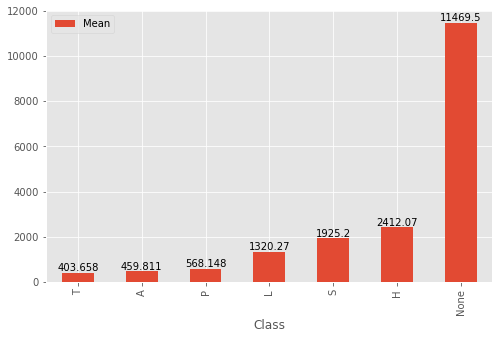

In [56]:
mean_errors_by_class = get_mean_error_by_feature_class_intersection(df_geocoded_hgat, False)
ax = pd.DataFrame(mean_errors_by_class.items(), columns=['Class', 'Mean']).sort_values(by=['Mean']).plot.bar(x="Class", y="Mean", figsize=(8,5))
ax.bar_label(ax.containers[0])
print(mean_errors_by_class)

#### CamCoder

In [57]:
df_geocoded_camcoder["toponyms_in"] = toponyms_in
df_metrics_geocoded = pd.DataFrame(df_geocoded_camcoder.apply(lambda row: metrics(row.geocoded, row.toponyms_in, False, 161), axis=1).tolist(), index=df_geocoded_camcoder.index, columns=['Geotag Precision', 'Geotag Recall', 'Geotag F1-Score', 'Geocode Mean Distance', ' Geocode Within Min Distance', '@161 km', 'AUC', 'Pct predicted'])
df_metrics_geocoded.describe()

,Geotag Precision,Geotag Recall,Geotag F1-Score,Geocode Mean Distance,Geocode Within Min Distance,@161 km,AUC,Pct predicted
count,196.0,196.0,196.0,196.000000,196.000000,196.000000,190.000000,196.0
mean,1.0,1.0,1.0,1037.378719,0.752997,0.752997,0.206935,1.0
std,0.0,0.0,0.0,1514.639870,0.267948,0.267948,0.188238,0.0
min,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,1.0
25%,1.0,1.0,1.0,3.022824,0.571429,0.571429,0.037822,1.0
50%,1.0,1.0,1.0,265.453456,0.839744,0.839744,0.159288,1.0
75%,1.0,1.0,1.0,1649.408525,1.000000,1.000000,0.336338,1.0
max,1.0,1.0,1.0,8439.783708,1.000000,1.000000,0.883678,1.0


{'S': 1022.4469406920666, 'A': 1305.0120575471858, 'P': 757.8704670623363, 'L': 1456.464088463973, 'H': 2836.1635095169477, 'T': 2693.584191981208, None: 218.89303315694457}


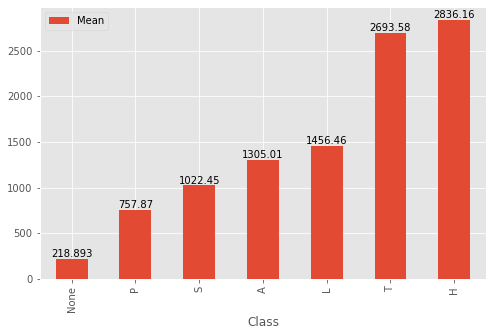

In [58]:
mean_errors_by_class = get_mean_error_by_feature_class_intersection(df_geocoded_camcoder, False)
ax = pd.DataFrame(mean_errors_by_class.items(), columns=['Class', 'Mean']).sort_values(by=['Mean']).plot.bar(x="Class", y="Mean", figsize=(8,5))
ax.bar_label(ax.containers[0])
print(mean_errors_by_class)

#### CamCoder vs HG-AT

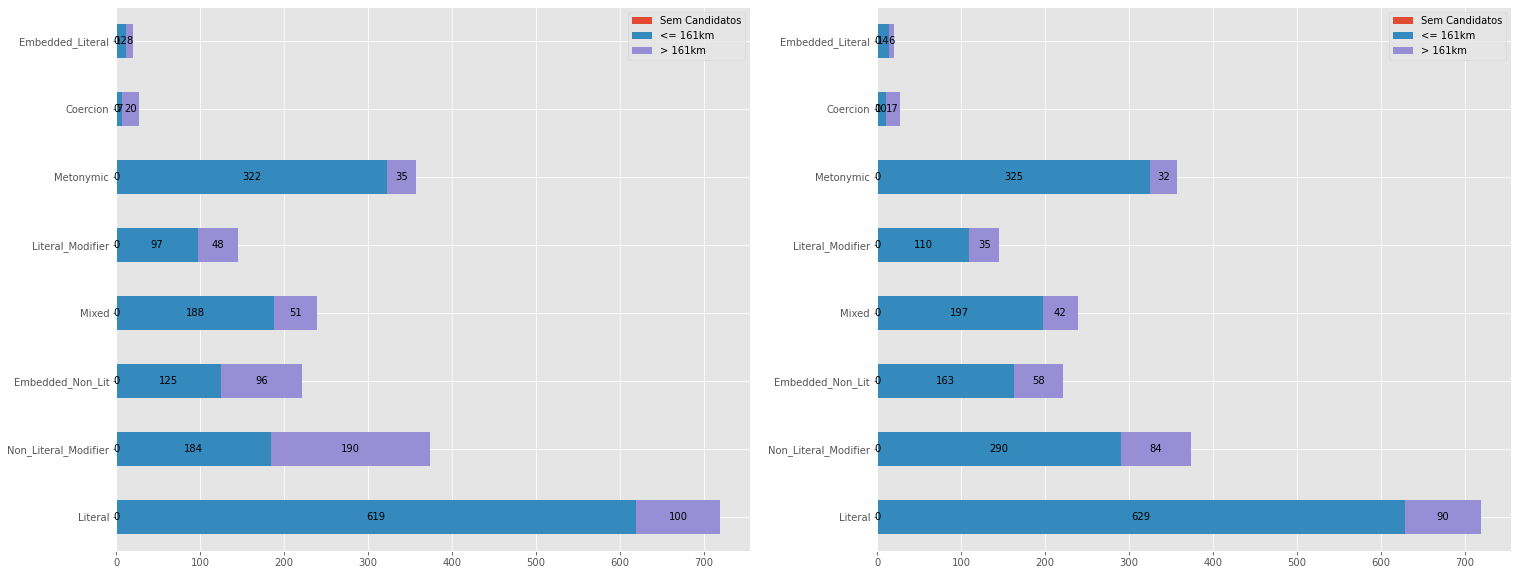

In [59]:
errors_by_type = count_errors_by_type_intersection(df_geocoded_hgat)
df_errors_by_type_hgat_in = pd.DataFrame(
    {key: pd.Series(value) for key, value in errors_by_type.items()})

errors_by_type = count_errors_by_type_intersection(df_geocoded_camcoder)
df_errors_by_type_camcoder_in = pd.DataFrame(
    {key: pd.Series(value) for key, value in errors_by_type.items()})

plot_bars_stacked_diff(df_errors_by_type_camcoder_in, df_errors_by_type_hgat_in)

<AxesSubplot:>

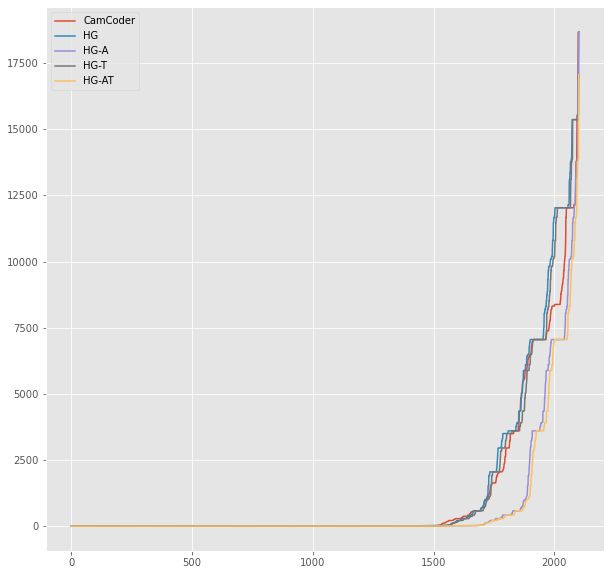

In [60]:
distances_camcoder = sorted([i for j in df_geocoded_camcoder.apply(lambda row: get_prediction_errors(row.geocoded, row.toponyms_in, False), axis=1).tolist() for i in j])
distances_hg = sorted([i for j in df_geocoded_hg.apply(lambda row: get_prediction_errors(row.geocoded, row.toponyms_in, False), axis=1).tolist() for i in j])
distances_hga = sorted([i for j in df_geocoded_hga.apply(lambda row: get_prediction_errors(row.geocoded, row.toponyms_in, False), axis=1).tolist() for i in j])
distances_hgt = sorted([i for j in df_geocoded_hgt.apply(lambda row: get_prediction_errors(row.geocoded, row.toponyms_in, False), axis=1).tolist() for i in j])
distances_hgat = sorted([i for j in df_geocoded_hgat.apply(lambda row: get_prediction_errors(row.geocoded, row.toponyms_in, False), axis=1).tolist() for i in j])
distances_dict = { "Count": [np.exp((i+ 1)/len(distances_camcoder)) - 1  for i in range(len(distances_camcoder))], "CamCoder": distances_camcoder, "HG": distances_hg, "HG-A": distances_hga, "HG-T": distances_hgt, "HG-AT": distances_hgat}
df_errors = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in distances_dict.items() ]))
df_errors[["CamCoder", "HG", "HG-A", "HG-T", "HG-AT"]].plot(figsize=(10,10))

<AxesSubplot:xlabel='Count'>

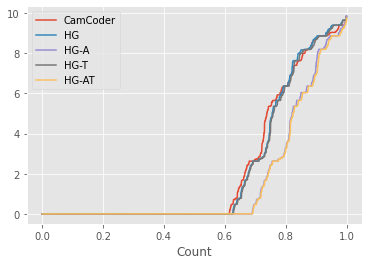

In [61]:
np.log(df_errors + 1).plot(x="Count")

In [62]:
#assert False

## TR-News

In [63]:
#df_trnews = pd.read_csv('../EUPEG-datasets/TR-News.csv')
df_trnews = pd.read_csv('../EUPEG-datasets/TR-News_with_featurecodes.csv')
df_trnews['toponyms'] = df_trnews.apply(
    lambda row: ast.literal_eval(row.toponyms), axis=1)

df_trnews['toponyms'] = df_trnews['toponyms'].apply(
    lambda x: [t for t in x if t[6] is not None])

df_trnews

,file,link,title,text,toponyms
0,0,\n http://news.nationalpost.com/new...,Policeman shot dead after assassinating Russia...,A Turkish policeman fatally shot Russia’s amba...,"[(2, 9, Turkish, Turkey, LOC, None, 298795, 39..."
1,1,http://www.cnn.com/2015/01/02/us/wv-officers-s...,Slain N.C. couple mourned; bodies found in tru...,"That's how Judy Law of Oxford, North Carolina,...","[(31, 45, North Carolina, North Carolina, LOC,..."
2,2,http://www.cnn.com/2015/01/01/us/transgender-q...,"The transgender life: What to know, say and un...",Ohio sparked an intensely emotional reaction a...,"[(0, 4, Ohio, Ohio, LOC, None, 5165418, 40.250..."
3,3,http://www.cnn.com/2015/01/01/us/mario-cuomo-d...,Former New York Gov. Mario Cuomo dies at 82; w...,Former New York Gov. Mario Cuomo -- who rose f...,"[(80, 86, Queens, Queens, LOC, None, 5133273, ..."
4,4,http://www.cnn.com/2013/06/14/us/thanksgiving-...,Thanksgiving Day Fast Facts,"Here's a look at Thanksgiving Day, celebrated ...","[(53, 66, United States, United States, LOC, N..."
...,...,...,...,...,...
113,113,http://www.bbc.com/news/world-middle-east-1922...,Iran earthquakes leave scores dead in Tabriz r...,Two strong earthquakes have struck north-weste...,"[(155, 161, Tabriz, Tabriz, LOC, None, 113646,..."
114,114,http://www.reuters.com/article/us-iran-blast-s...,Starbucks to own 100% of its China stores afte...,LONDON (Reuters) - An explosion in a supermark...,"[(0, 6, LONDON, London, LOC, None, 2643743, 51..."
115,115,http://www.nlhnews.co.uk/article.cfm?id=119605,Aspiring student from Enfield selected for Chi...,An aspiring 23-year-old graduate from Edmonton...,"[(38, 46, Edmonton, Edmonton, LOC, None, 26502..."
116,116,http://www.nlhnews.co.uk/article.cfm?id=119700,Edmonton man jailed after “vicious assault” wh...,AN Edmonton man who carried out a “vicious ass...,"[(3, 11, Edmonton, Edmonton, LOC, None, 265020..."


### CamCoder

In [64]:
df_trnews_camcoder = pd.read_csv('../EUPEG-datasets/Outputs/TR-News_CamCoder_geocoded.csv')
df_trnews_camcoder['Y'] = df_trnews_camcoder["Y"].apply(
    lambda x: ast.literal_eval(x))
df_trnews_camcoder['Best Candidate'] = df_trnews_camcoder['Best Candidate'].apply(
    lambda x: ast.literal_eval(x))


df_geocoded_camcoder = df_trnews[['file', 'text', 'toponyms']].copy()

df_geocoded_camcoder['geocoded'] = df_geocoded_camcoder.progress_apply(lambda row: get_camcoder_geocoded(df_trnews_camcoder, row.file), axis=1)


unified_geocoded =  df_geocoded_camcoder['geocoded'].apply(lambda x: [t for t in x if t[4] is not None]).tolist()
unified_geocoded = [i for j in unified_geocoded for i in j]
print(len(unified_geocoded))

df_metrics_geocoded = pd.DataFrame(df_geocoded_camcoder.apply(lambda row: metrics(row.geocoded, row.toponyms, False, 161), axis=1).tolist(), index=df_geocoded_camcoder.index, columns=['Geotag Precision', 'Geotag Recall', 'Geotag F1-Score', 'Geocode Mean Distance', ' Geocode Within Min Distance', '@161 km', 'AUC', 'Pct predicted'])
df_metrics_geocoded.describe()

Progress:   0%|          | 0/118 [00:00<?, ?it/s]

1165


,Geotag Precision,Geotag Recall,Geotag F1-Score,Geocode Mean Distance,Geocode Within Min Distance,@161 km,AUC,Pct predicted
count,118.0,118.000000,118.000000,118.000000,118.000000,118.000000,115.000000,118.000000
mean,1.0,0.939356,0.963980,1140.507819,0.793848,0.792638,0.200976,0.939356
std,0.0,0.120906,0.077289,1576.841230,0.240413,0.240452,0.198811,0.120906
min,1.0,0.363636,0.533333,0.000000,0.000000,0.000000,0.000000,0.363636
25%,1.0,0.917500,0.956975,0.796178,0.666667,0.666667,0.037715,0.917500
50%,1.0,1.000000,1.000000,323.172682,0.857143,0.857143,0.149097,1.000000
75%,1.0,1.000000,1.000000,1759.256469,1.000000,1.000000,0.302444,1.000000
max,1.0,1.000000,1.000000,5865.009455,1.000000,1.000000,0.875977,1.000000


In [65]:
errors_by_type = count_errors_by_type(df_geocoded_camcoder, classes=["LOC"])
df_errors_by_type_camcoder = pd.DataFrame(
    {key: pd.Series(value) for key, value in errors_by_type.items()})

#### Erro por Feature Code

{'PCLI': 1895.98425791485, 'PPLA': 520.1049208562109, 'PPLC': 568.5181092934855, 'ADM1': 137.3895605534624, 'PPLA2': 1243.7282293202838, 'PPL': 2265.026170765939, 'PRK': 91.29986798424089, 'SCH': 0.0, 'CONT': 730.3861113081431, 'AIRP': 0.0, 'RGN': 2273.2545193667747, 'ADM3': 6.096868821392117, 'PPLA3': 3252.243885770224, 'PPLX': 711.6993760999585, 'OCN': 7338.469207058983, 'ADM2': 491.09250188624736, 'ADMD': 0.0, 'HSP': 0.0, 'STDM': 0.0, 'BLDG': 6102.877210734988, 'CH': 506.5686856906013, 'MUS': 0.0, 'AREA': 64.01643099883837, 'HTL': 59.92957963898484, 'MTRO': 393.4030936664177, 'STM': 167.99970700710134, 'ST': 0.0, 'PCLIX': 0.0, 'PCLD': 0.0, 'PCLS': 0.0, 'PPLQ': 19.073654088094234}


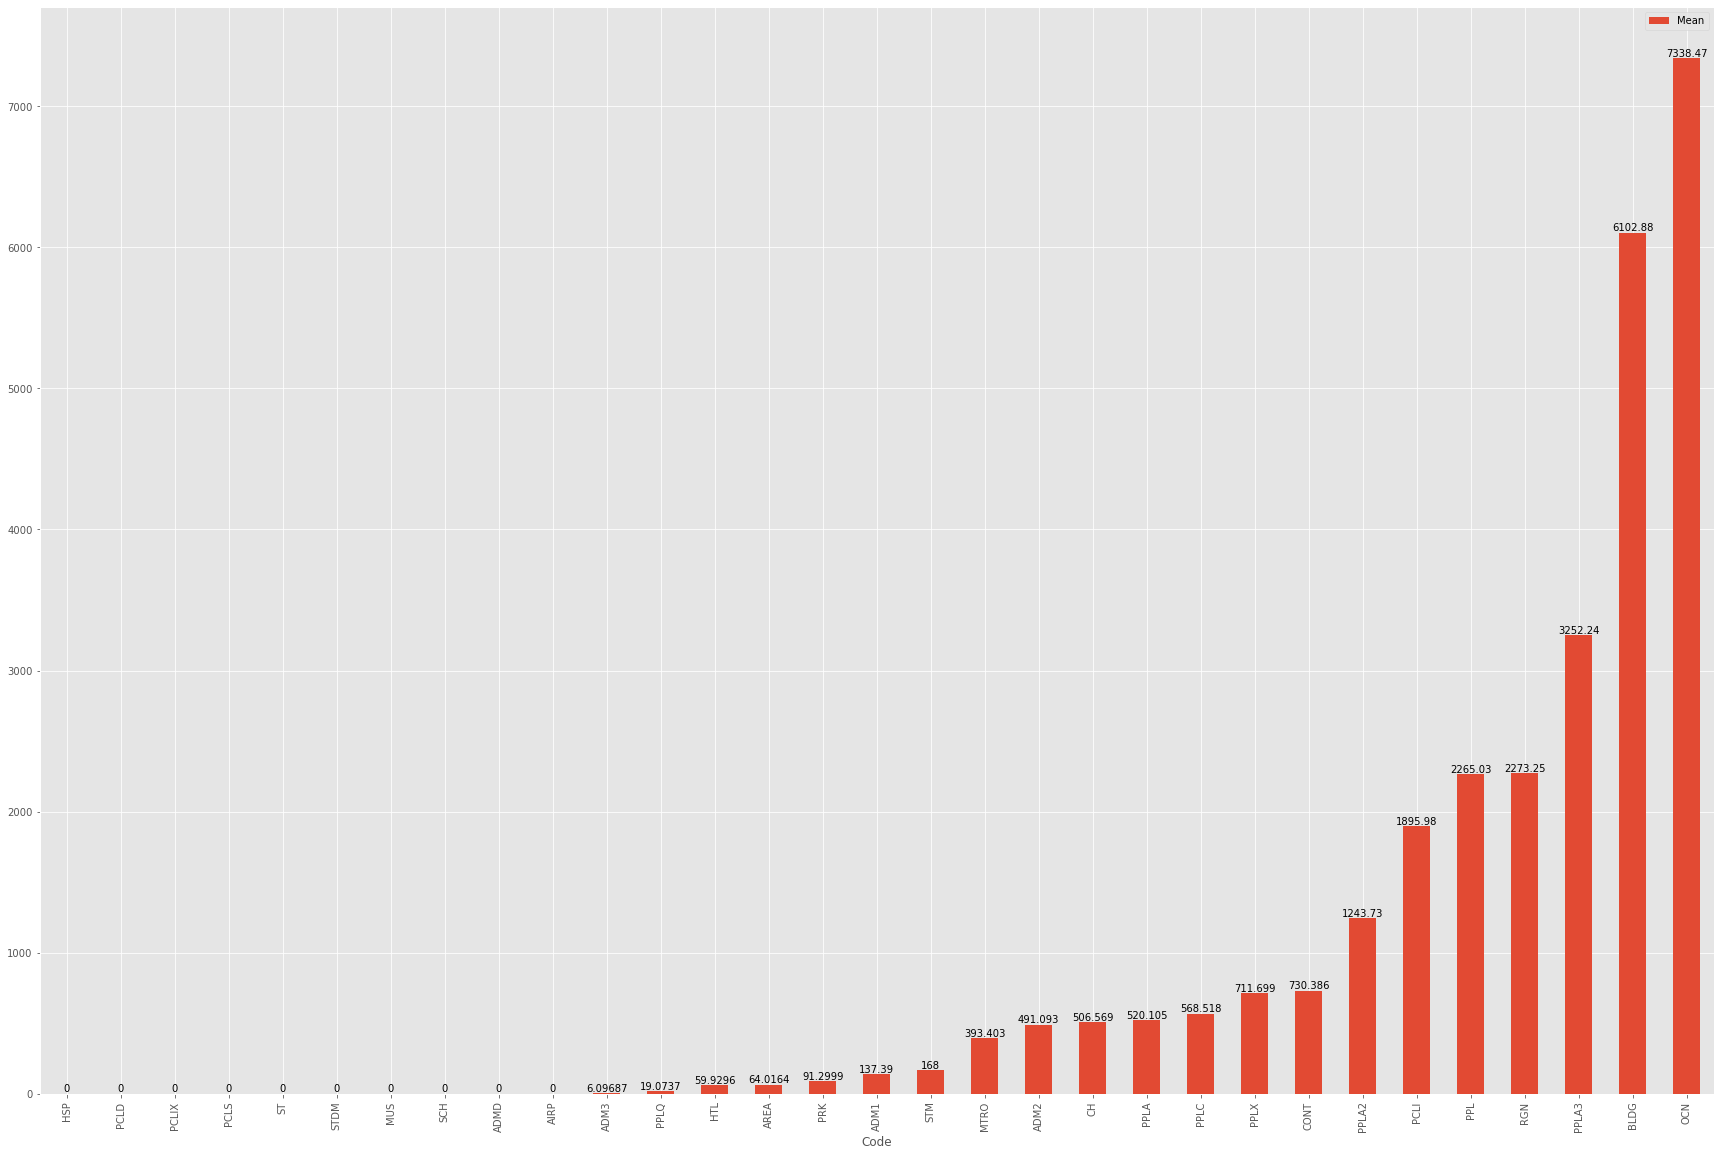

In [66]:
mean_errors_by_code = get_mean_error_by_feature_code(df_geocoded_camcoder, False)
ax = pd.DataFrame(mean_errors_by_code.items(), columns=['Code', 'Mean']).sort_values(by=['Mean']).plot.bar(x="Code", y="Mean", figsize=(30,20))
ax.bar_label(ax.containers[0])
print(mean_errors_by_code)

#### Erro por Feature Class

{'A': 1131.817271529418, 'P': 1278.2149189636696, 'L': 973.9371037539529, 'S': 366.1526864142649, 'H': 3753.2344570330424, 'R': 0.0}


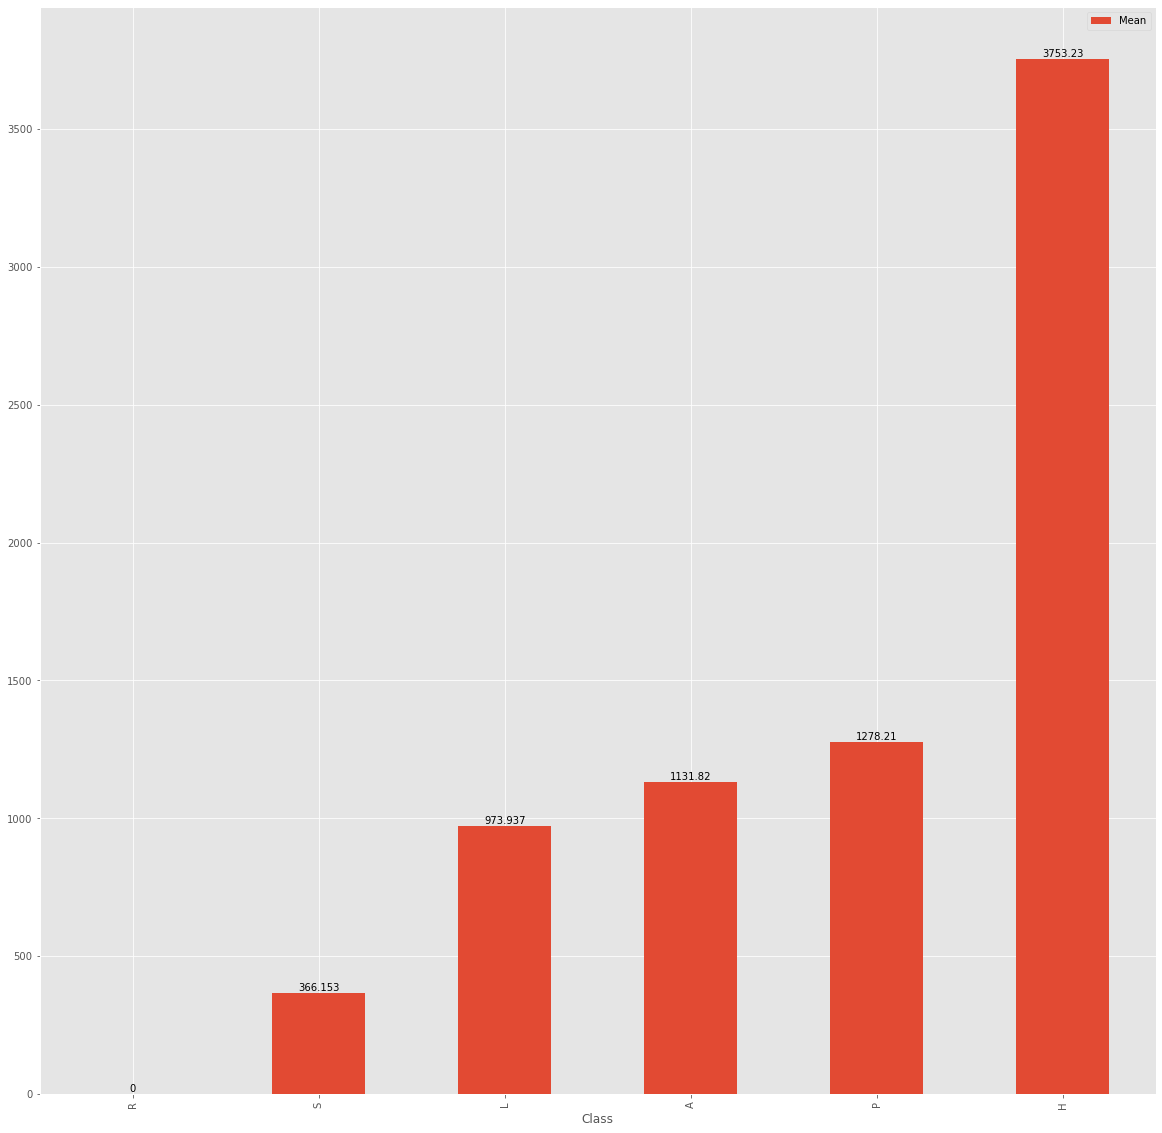

In [67]:
mean_errors_by_class = get_mean_error_by_feature_class(df_geocoded_camcoder, False)
ax = pd.DataFrame(mean_errors_by_class.items(), columns=['Class', 'Mean']).sort_values(by=['Mean']).plot.bar(x="Class", y="Mean", figsize=(20,20))
ax.bar_label(ax.containers[0])
print(mean_errors_by_class)

### HG

In [68]:
df_geocoded_hg = df_trnews[['file', 'text', 'toponyms']].copy()
df_geocoded_hg['geocoded'] = df_geocoded_hg.progress_apply(lambda row: geocode_toponyms(geoparser, row.toponyms, exact_matching=True, process_demonyms=False, bounding_box=None, k=1, minimum_score=0, sort_by="population", minimization_classes=[], minimization_strategy="sum_dist"), axis=1)

unified_geocoded =  df_geocoded_hg['geocoded'].apply(lambda x: [t for t in x if t[4] is not None]).tolist()
unified_geocoded = [i for j in unified_geocoded for i in j]
print(len(unified_geocoded))

df_metrics_geocoded = pd.DataFrame(df_geocoded_hg.apply(lambda row: metrics(row.geocoded, row.toponyms, False, 161), axis=1).tolist(), index=df_geocoded_hg.index, columns=['Geotag Precision', 'Geotag Recall', 'Geotag F1-Score', 'Geocode Mean Distance', ' Geocode Within Min Distance', '@161 km', 'AUC', 'Pct predicted'])
df_metrics_geocoded.describe()

Progress:   0%|          | 0/118 [00:00<?, ?it/s]

1200


,Geotag Precision,Geotag Recall,Geotag F1-Score,Geocode Mean Distance,Geocode Within Min Distance,@161 km,AUC,Pct predicted
count,118.0,118.0,118.0,118.000000,118.000000,118.000000,115.000000,118.000000
mean,1.0,1.0,1.0,1600.961821,0.747020,0.747020,0.240401,0.959597
std,0.0,0.0,0.0,1727.851786,0.251949,0.251949,0.207897,0.086125
min,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.600000
25%,1.0,1.0,1.0,14.132130,0.578571,0.578571,0.081005,1.000000
50%,1.0,1.0,1.0,1066.374862,0.809091,0.809091,0.196515,1.000000
75%,1.0,1.0,1.0,2728.645615,1.000000,1.000000,0.375989,1.000000
max,1.0,1.0,1.0,6453.013561,1.000000,1.000000,0.875977,1.000000


#### Erro por Feature Code

{'PCLI': 1921.2885620065942, 'PPLA': 100.3972417464803, 'PPLC': 291.85418963364043, 'ADM1': 78.70569955873648, 'PPLA2': 2967.5795506867466, 'PPL': 3548.0197187315, 'PRK': 9344.520264097016, 'SCH': 3.536620440947047e-13, 'CONT': 651.9757709015876, 'AIRP': 5554.581888219704, 'RGN': 1403.507629639282, 'ADM3': 127.67761903762825, 'PPLA3': 1.9438956211089522, 'OCN': 7338.4692070589845, 'PPLX': 5454.7075479256555, 'ADM2': 418.65490078639783, 'ADMD': 0.0, 'HSP': 558.0504294514465, 'STDM': 1.0609861322841142e-12, 'BLDG': 6102.877210734988, 'CH': 9033.232162514698, 'MUS': 0.0, 'AREA': 64.01643099883891, 'HTL': 7544.881001387094, 'MTRO': 0.0, 'STM': 167.99970700709977, 'ST': 0.0, 'PCLIX': 1.7683102204735235e-13, 'PCLD': 0.0, 'PCLS': 0.0, 'PPLQ': 19.073654088094234}


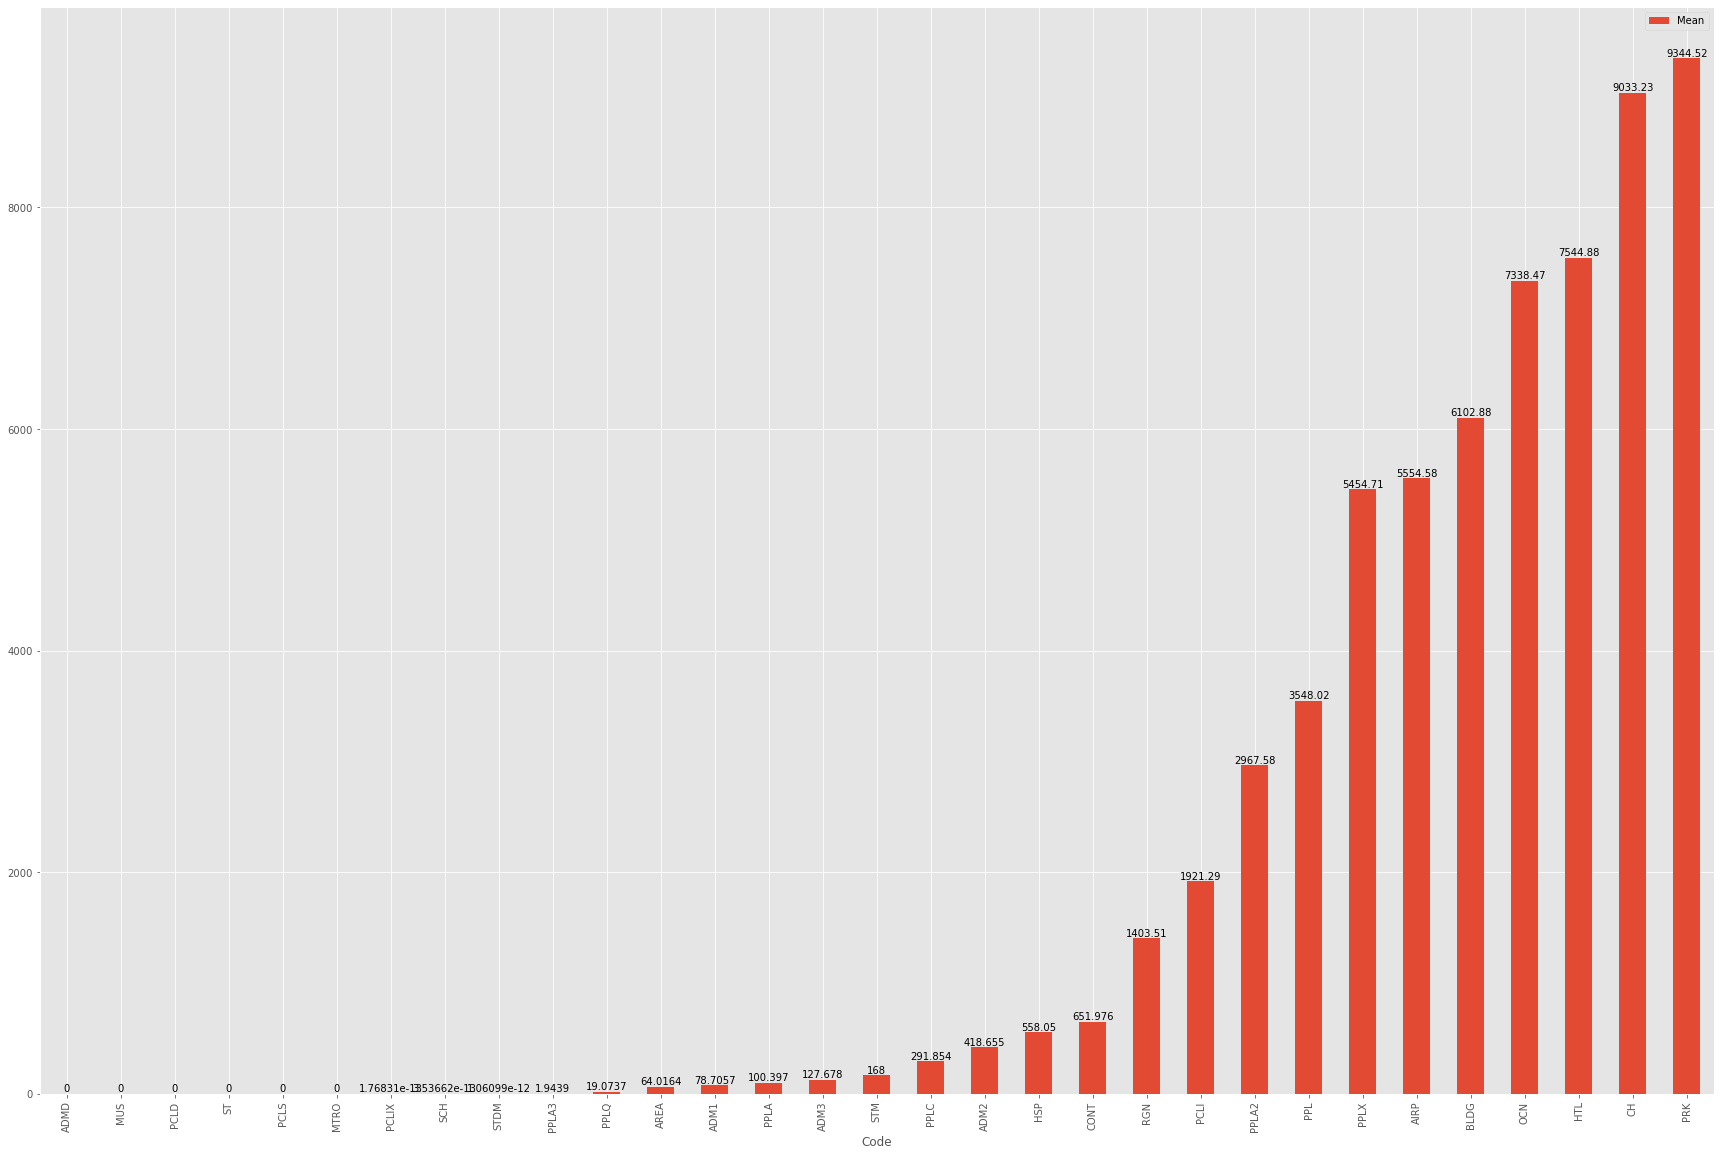

In [69]:
mean_errors_by_code = get_mean_error_by_feature_code(df_geocoded_hg, False)
ax = pd.DataFrame(mean_errors_by_code.items(), columns=['Code', 'Mean']).sort_values(by=['Mean']).plot.bar(x="Code", y="Mean", figsize=(30,20))
ax.bar_label(ax.containers[0])
print(mean_errors_by_code)

#### Erro por Feature Class

{'A': 1122.9805090131667, 'P': 2065.454901765384, 'L': 1565.9890378999103, 'S': 3631.0021556846914, 'H': 3753.2344570330424, 'R': 0.0}


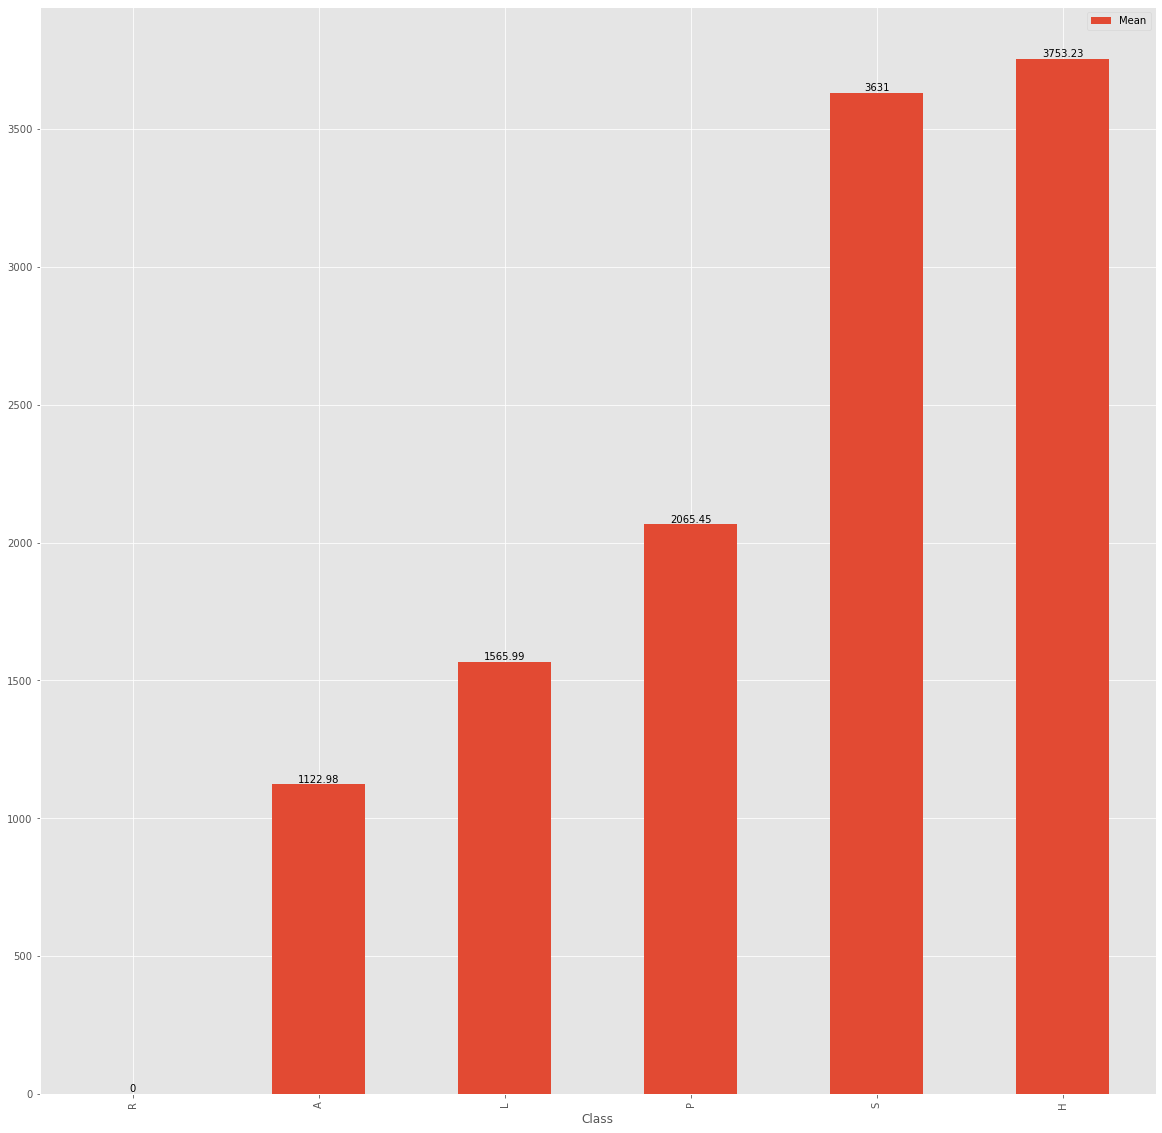

In [70]:
mean_errors_by_class = get_mean_error_by_feature_class(df_geocoded_hg, False)
ax = pd.DataFrame(mean_errors_by_class.items(), columns=['Class', 'Mean']).sort_values(by=['Mean']).plot.bar(x="Class", y="Mean", figsize=(20,20))
ax.bar_label(ax.containers[0])
print(mean_errors_by_class)

#### CamCoder vs HG

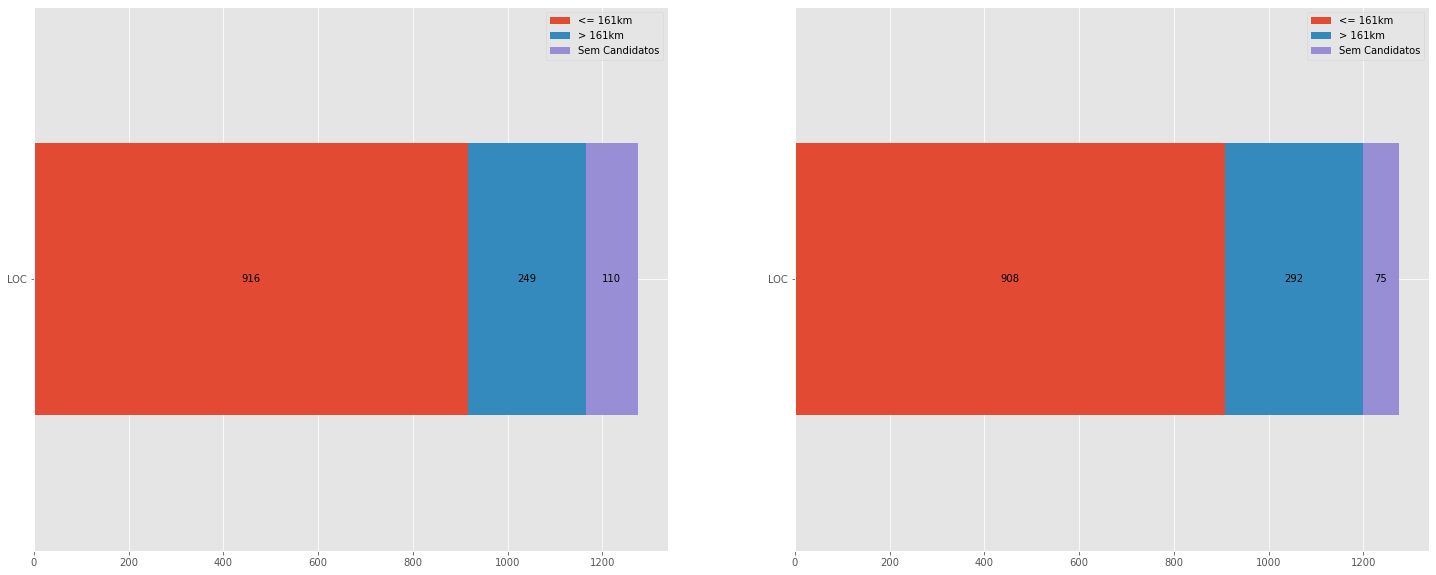

In [71]:
errors_by_type = count_errors_by_type(df_geocoded_hg, classes=["LOC"])
df_errors_by_type_hg = pd.DataFrame(
    {key: pd.Series(value) for key, value in errors_by_type.items()})

plot_bars_stacked_diff(df_errors_by_type_camcoder, df_errors_by_type_hg)

### HG-A

In [72]:
df_geocoded_hga = df_trnews[['file', 'text', 'toponyms']].copy()
df_geocoded_hga['geocoded'] = df_geocoded_hga.progress_apply(lambda row: geocode_toponyms(geoparser, row.toponyms, exact_matching=True, process_demonyms=True, bounding_box=None, k=1, minimum_score=0, sort_by="population", minimization_classes=[], minimization_strategy="sum_dist"), axis=1)

unified_geocoded =  df_geocoded_hga['geocoded'].apply(lambda x: [t for t in x if t[4] is not None]).tolist()
unified_geocoded = [i for j in unified_geocoded for i in j]
print(len(unified_geocoded))

df_metrics_geocoded = pd.DataFrame(df_geocoded_hga.apply(lambda row: metrics(row.geocoded, row.toponyms, False, 161), axis=1).tolist(), index=df_geocoded_hga.index, columns=['Geotag Precision', 'Geotag Recall', 'Geotag F1-Score', 'Geocode Mean Distance', ' Geocode Within Min Distance', '@161 km', 'AUC', 'Pct predicted'])
df_metrics_geocoded.describe()

Progress:   0%|          | 0/118 [00:00<?, ?it/s]

1245


,Geotag Precision,Geotag Recall,Geotag F1-Score,Geocode Mean Distance,Geocode Within Min Distance,@161 km,AUC,Pct predicted
count,118.0,118.0,118.0,118.000000,118.000000,118.000000,115.000000,118.000000
mean,1.0,1.0,1.0,1250.090958,0.803426,0.803426,0.192425,0.975218
std,0.0,0.0,0.0,1597.009169,0.237952,0.237952,0.198230,0.065521
min,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.600000
25%,1.0,1.0,1.0,1.021087,0.675000,0.675000,0.037715,1.000000
50%,1.0,1.0,1.0,466.049509,0.888889,0.888889,0.124973,1.000000
75%,1.0,1.0,1.0,2025.381101,1.000000,1.000000,0.303995,1.000000
max,1.0,1.0,1.0,6453.013561,1.000000,1.000000,0.875977,1.000000


#### Erro por Feature Code

{'PCLI': 406.00161216005824, 'PPLA': 100.3972417464803, 'PPLC': 291.85418963364043, 'ADM1': 78.70569955873648, 'PPLA2': 2967.5795506867466, 'PPL': 3548.0197187315, 'PRK': 9344.520264097016, 'SCH': 3.536620440947047e-13, 'CONT': 418.747968891901, 'AIRP': 5554.581888219704, 'RGN': 1403.507629639282, 'ADM3': 127.67761903762825, 'PPLA3': 1.9438956211089522, 'OCN': 7338.4692070589845, 'PPLX': 5454.7075479256555, 'ADM2': 418.65490078639783, 'ADMD': 0.0, 'HSP': 558.0504294514465, 'STDM': 1.0609861322841142e-12, 'BLDG': 6102.877210734988, 'CH': 9033.232162514698, 'MUS': 0.0, 'AREA': 64.01643099883891, 'HTL': 7544.881001387094, 'MTRO': 0.0, 'STM': 167.99970700709977, 'ST': 0.0, 'PCLIX': 1.7683102204735235e-13, 'PCLD': 0.0, 'PCLS': 0.0, 'PPLQ': 19.073654088094234}


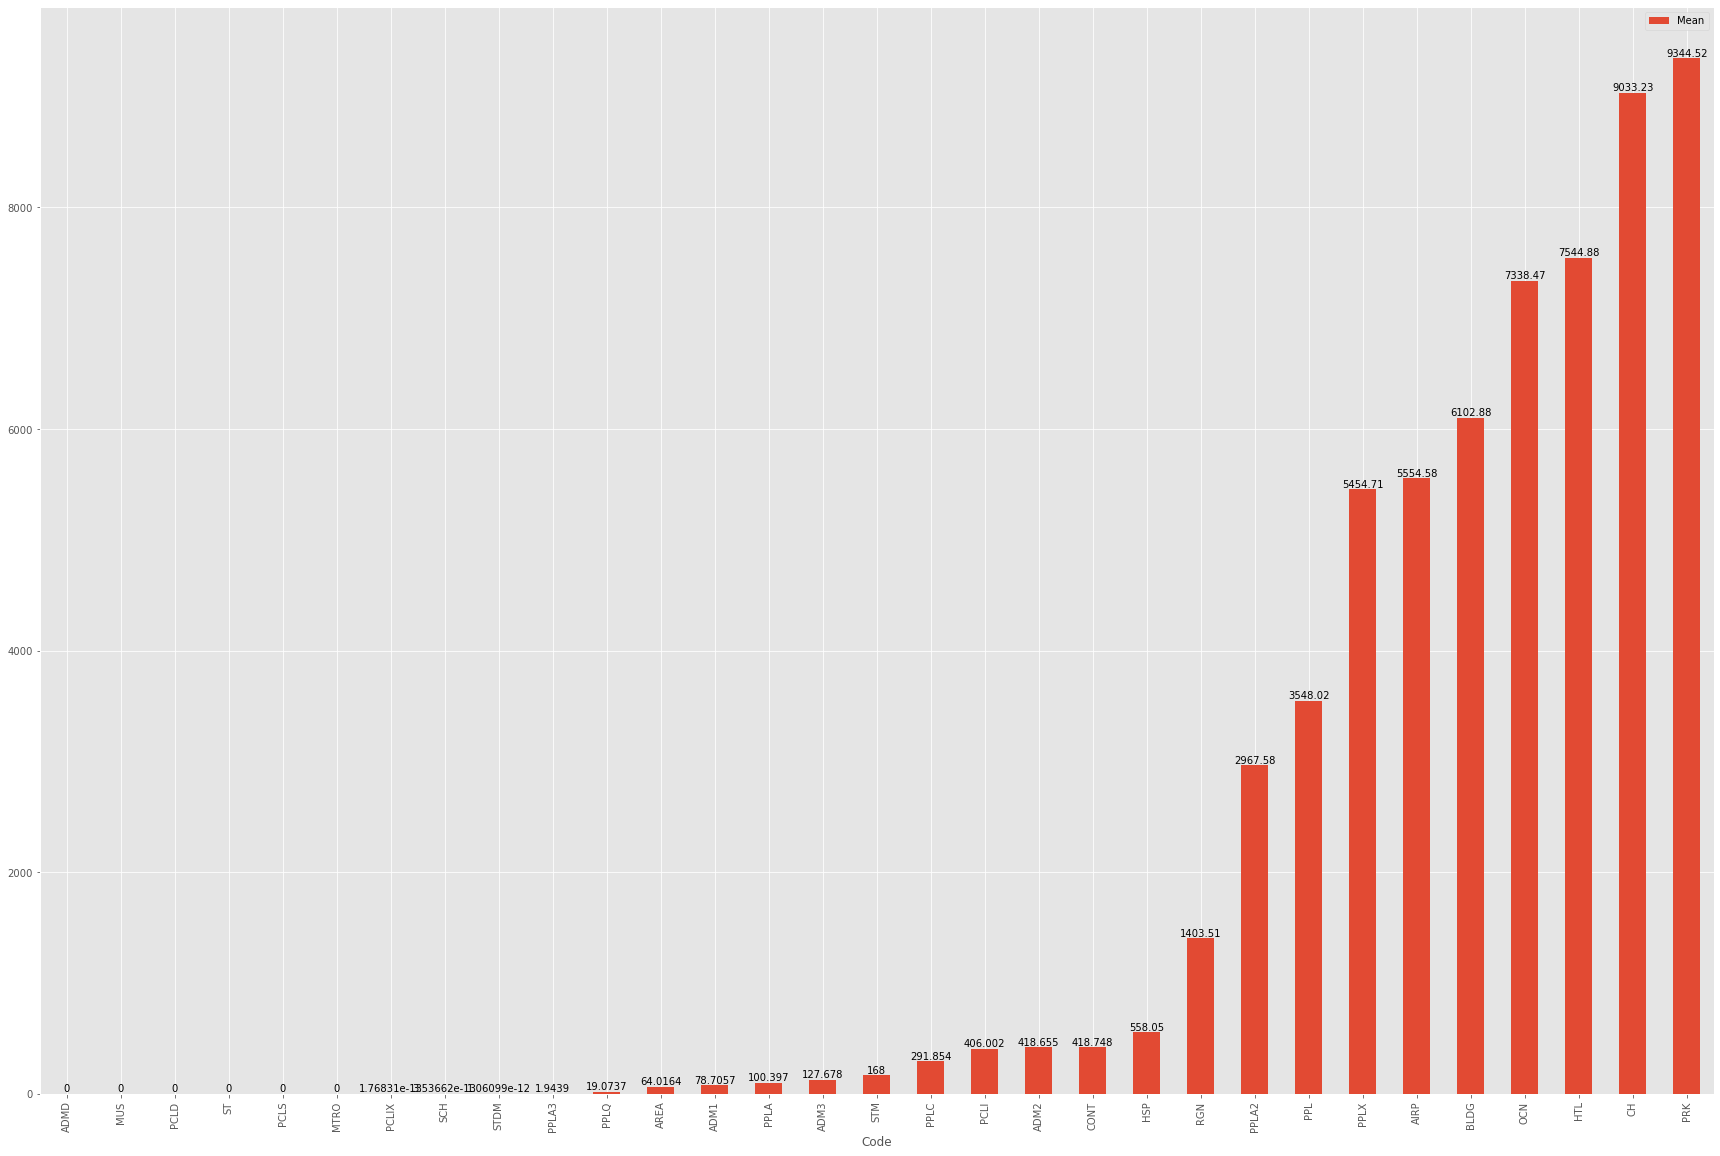

In [73]:
mean_errors_by_code = get_mean_error_by_feature_code(df_geocoded_hga, False)
ax = pd.DataFrame(mean_errors_by_code.items(), columns=['Code', 'Mean']).sort_values(by=['Mean']).plot.bar(x="Code", y="Mean", figsize=(30,20))
ax.bar_label(ax.containers[0])
print(mean_errors_by_code)

#### Erro por Feature Class

{'A': 292.0123829336844, 'P': 2065.454901765384, 'L': 1417.571345711928, 'S': 3631.0021556846914, 'H': 3753.2344570330424, 'R': 0.0}


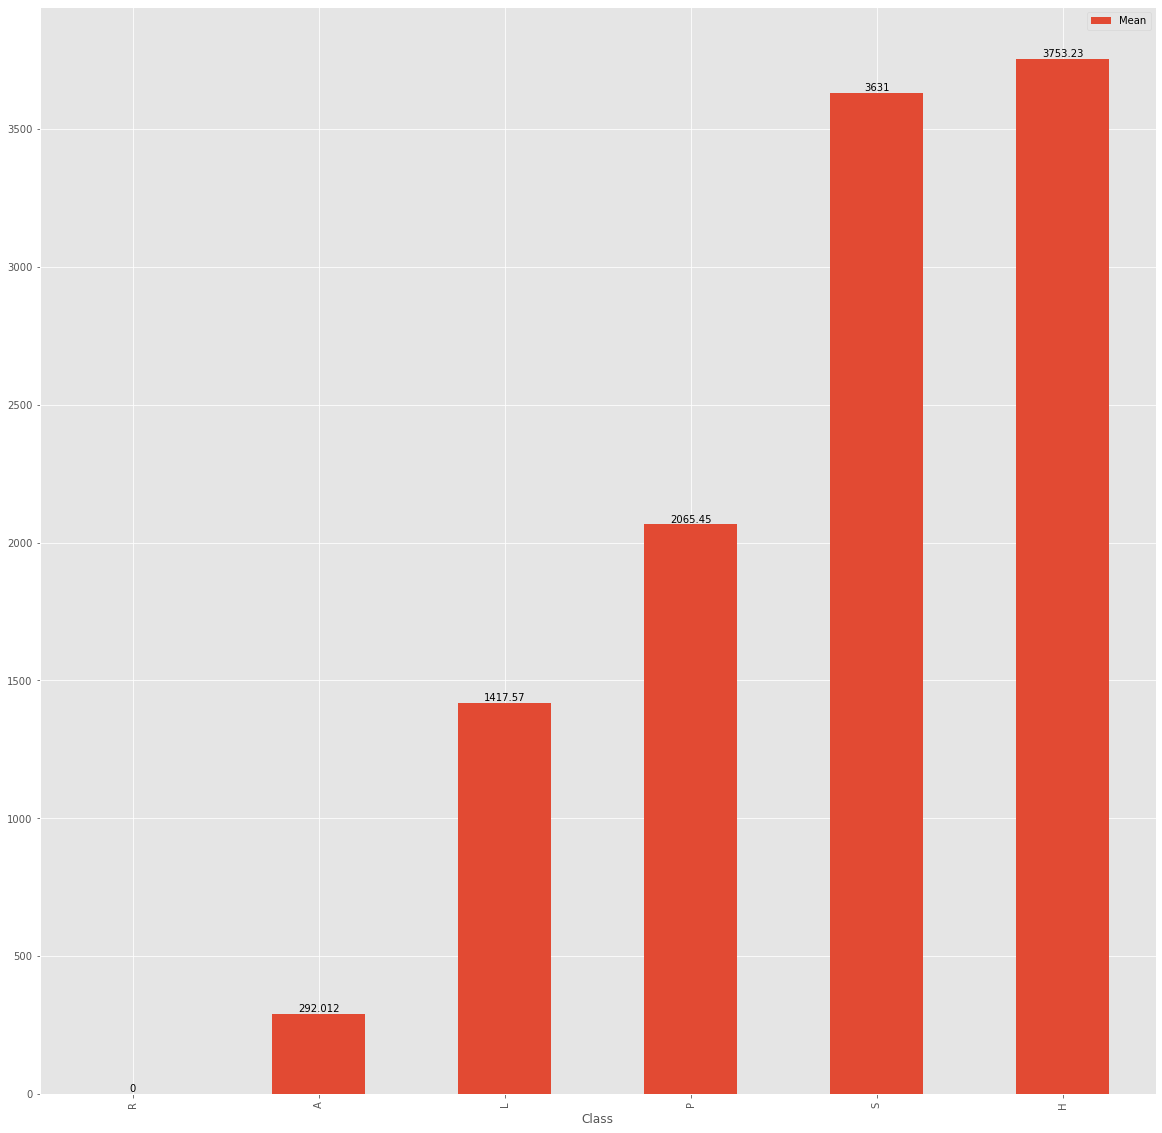

In [74]:
mean_errors_by_class = get_mean_error_by_feature_class(df_geocoded_hga, False)
ax = pd.DataFrame(mean_errors_by_class.items(), columns=['Class', 'Mean']).sort_values(by=['Mean']).plot.bar(x="Class", y="Mean", figsize=(20,20))
ax.bar_label(ax.containers[0])
print(mean_errors_by_class)

#### CamCoder vs HGA

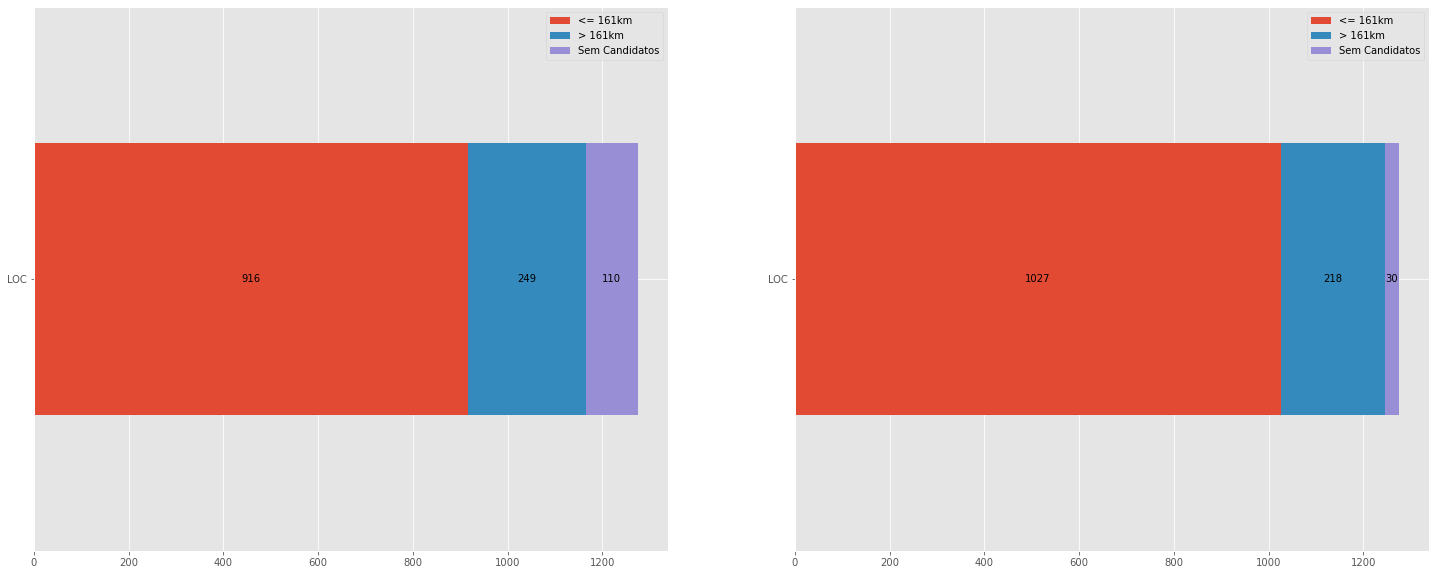

In [75]:
errors_by_type = count_errors_by_type(df_geocoded_hga, classes=["LOC"])
df_errors_by_type_hga = pd.DataFrame(
    {key: pd.Series(value) for key, value in errors_by_type.items()})

plot_bars_stacked_diff(df_errors_by_type_camcoder, df_errors_by_type_hga)

### HG-T

In [76]:
df_geocoded_hgt = df_trnews[['file', 'text', 'toponyms']].copy()
df_geocoded_hgt['geocoded'] = df_geocoded_hgt.progress_apply(lambda row: geocode_toponyms(geoparser, row.toponyms, exact_matching=True, process_demonyms=False, bounding_box=None, k=5, minimum_score=0, sort_by="population", minimization_classes=["LOC"], minimization_strategy="pop_by_mean_dist"), axis=1)

unified_geocoded =  df_geocoded_hgt['geocoded'].apply(lambda x: [t for t in x if t[4] is not None]).tolist()
unified_geocoded = [i for j in unified_geocoded for i in j]
print(len(unified_geocoded))

df_metrics_geocoded = pd.DataFrame(df_geocoded_hgt.apply(lambda row: metrics(row.geocoded, row.toponyms, False, 161), axis=1).tolist(), index=df_geocoded_hgt.index, columns=['Geotag Precision', 'Geotag Recall', 'Geotag F1-Score', 'Geocode Mean Distance', ' Geocode Within Min Distance', '@161 km', 'AUC', 'Pct predicted'])
df_metrics_geocoded.describe()

Progress:   0%|          | 0/118 [00:00<?, ?it/s]

1200


,Geotag Precision,Geotag Recall,Geotag F1-Score,Geocode Mean Distance,Geocode Within Min Distance,@161 km,AUC,Pct predicted
count,118.0,118.0,118.0,118.000000,118.000000,118.000000,115.000000,118.000000
mean,1.0,1.0,1.0,1513.268402,0.758852,0.758852,0.230948,0.959597
std,0.0,0.0,0.0,1681.162054,0.252310,0.252310,0.206495,0.086125
min,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.600000
25%,1.0,1.0,1.0,3.722738,0.606250,0.606250,0.070542,1.000000
50%,1.0,1.0,1.0,875.388564,0.841667,0.841667,0.167407,1.000000
75%,1.0,1.0,1.0,2614.083859,1.000000,1.000000,0.372357,1.000000
max,1.0,1.0,1.0,5865.009455,1.000000,1.000000,0.875977,1.000000


#### Erro por Feature Code

{'PCLI': 1921.2885620065942, 'PPLA': 100.85277329664018, 'PPLC': 291.85418963364043, 'ADM1': 48.24620587055122, 'PPLA2': 2681.936301951299, 'PPL': 3485.6707019357787, 'PRK': 9344.520264097016, 'SCH': 3.536620440947047e-13, 'CONT': 651.9757709015876, 'AIRP': 5554.581888219704, 'RGN': 1403.507629639282, 'ADM3': 127.67761903762825, 'PPLA3': 1.9438956211089522, 'OCN': 8720.98907227317, 'PPLX': 5454.7075479256555, 'ADM2': 418.65490078639783, 'ADMD': 0.0, 'HSP': 558.0504294514465, 'STDM': 1.0609861322841142e-12, 'BLDG': 6102.877210734988, 'CH': 9033.232162514698, 'MUS': 0.0, 'AREA': 64.01643099883891, 'HTL': 7544.881001387094, 'MTRO': 0.0, 'STM': 167.99970700709977, 'ST': 0.0, 'PCLIX': 1.7683102204735235e-13, 'PCLD': 0.0, 'PCLS': 0.0, 'PPLQ': 19.073654088094234}


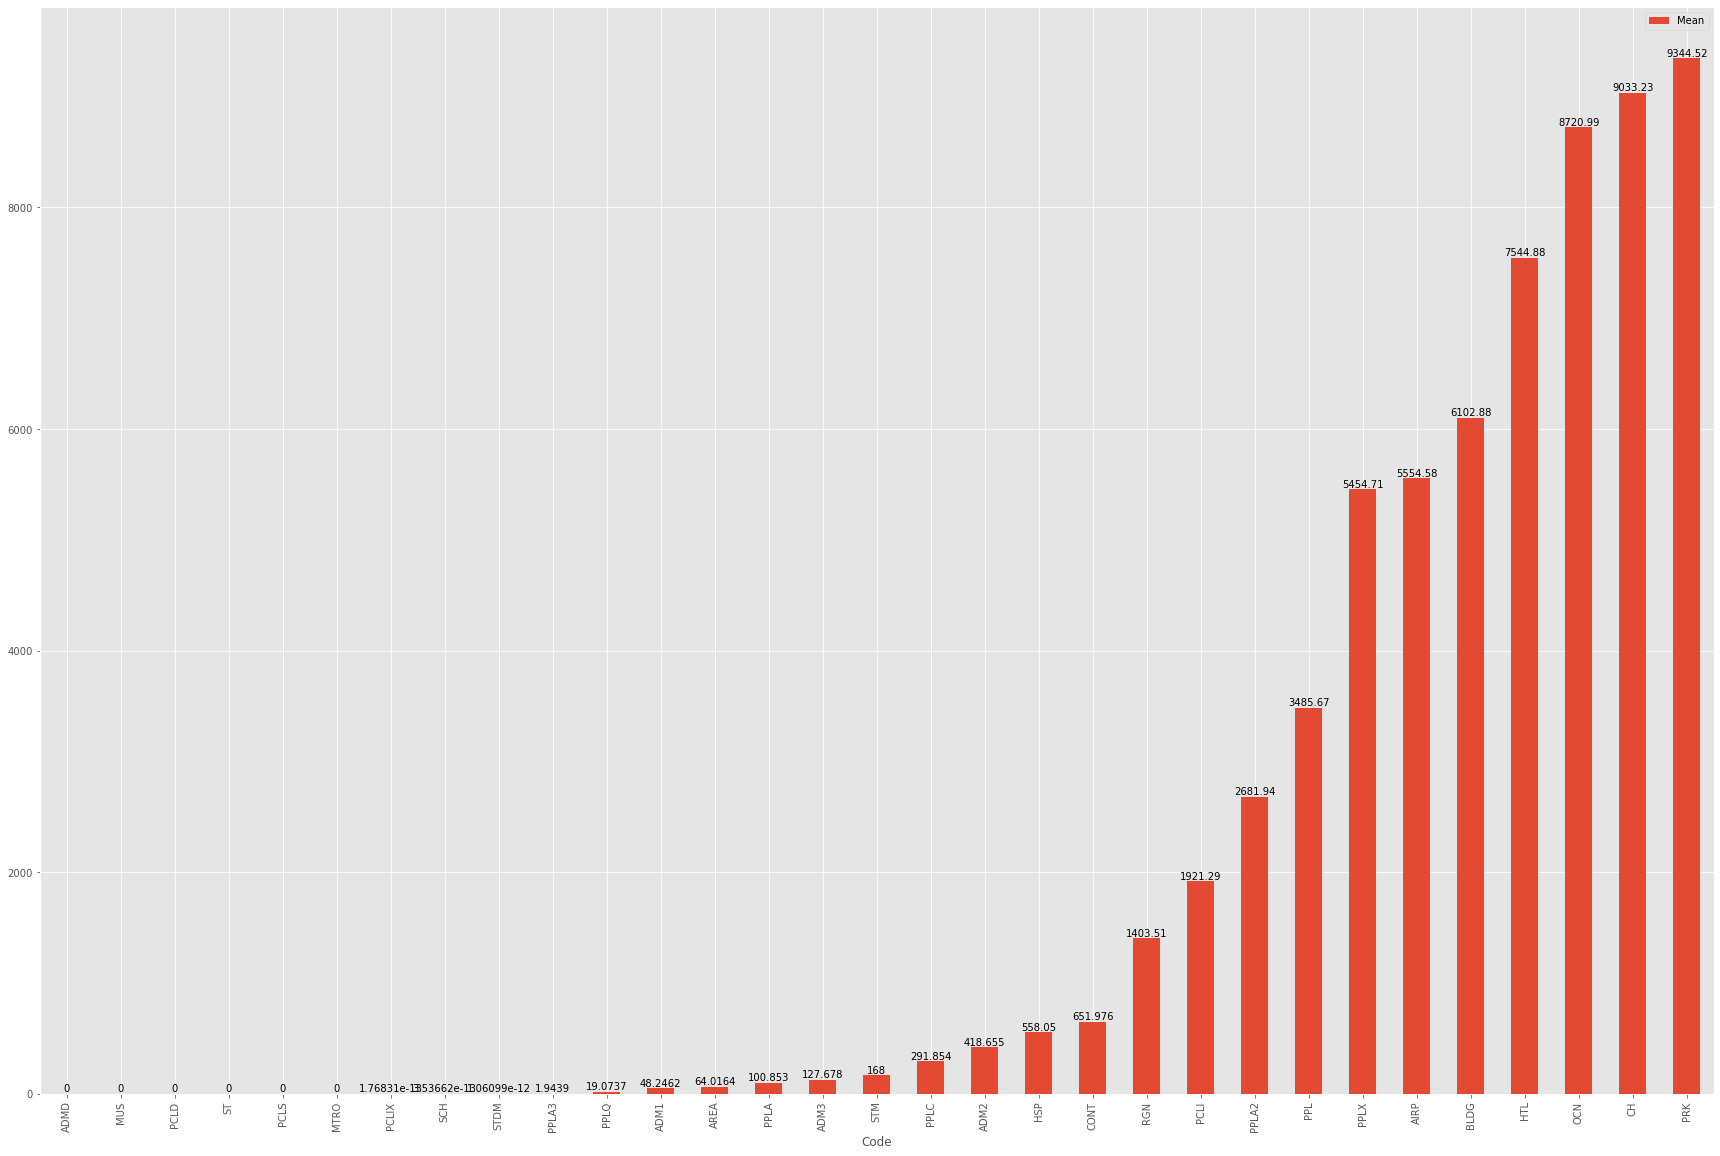

In [77]:
mean_errors_by_code = get_mean_error_by_feature_code(df_geocoded_hgt, False)
ax = pd.DataFrame(mean_errors_by_code.items(), columns=['Code', 'Mean']).sort_values(by=['Mean']).plot.bar(x="Code", y="Mean", figsize=(30,20))
ax.bar_label(ax.containers[0])
print(mean_errors_by_code)

#### Erro por Feature Class

{'A': 1112.0892063739195, 'P': 1984.2600029783864, 'L': 1565.9890378999103, 'S': 3631.0021556846914, 'H': 4444.4943896401355, 'R': 0.0}


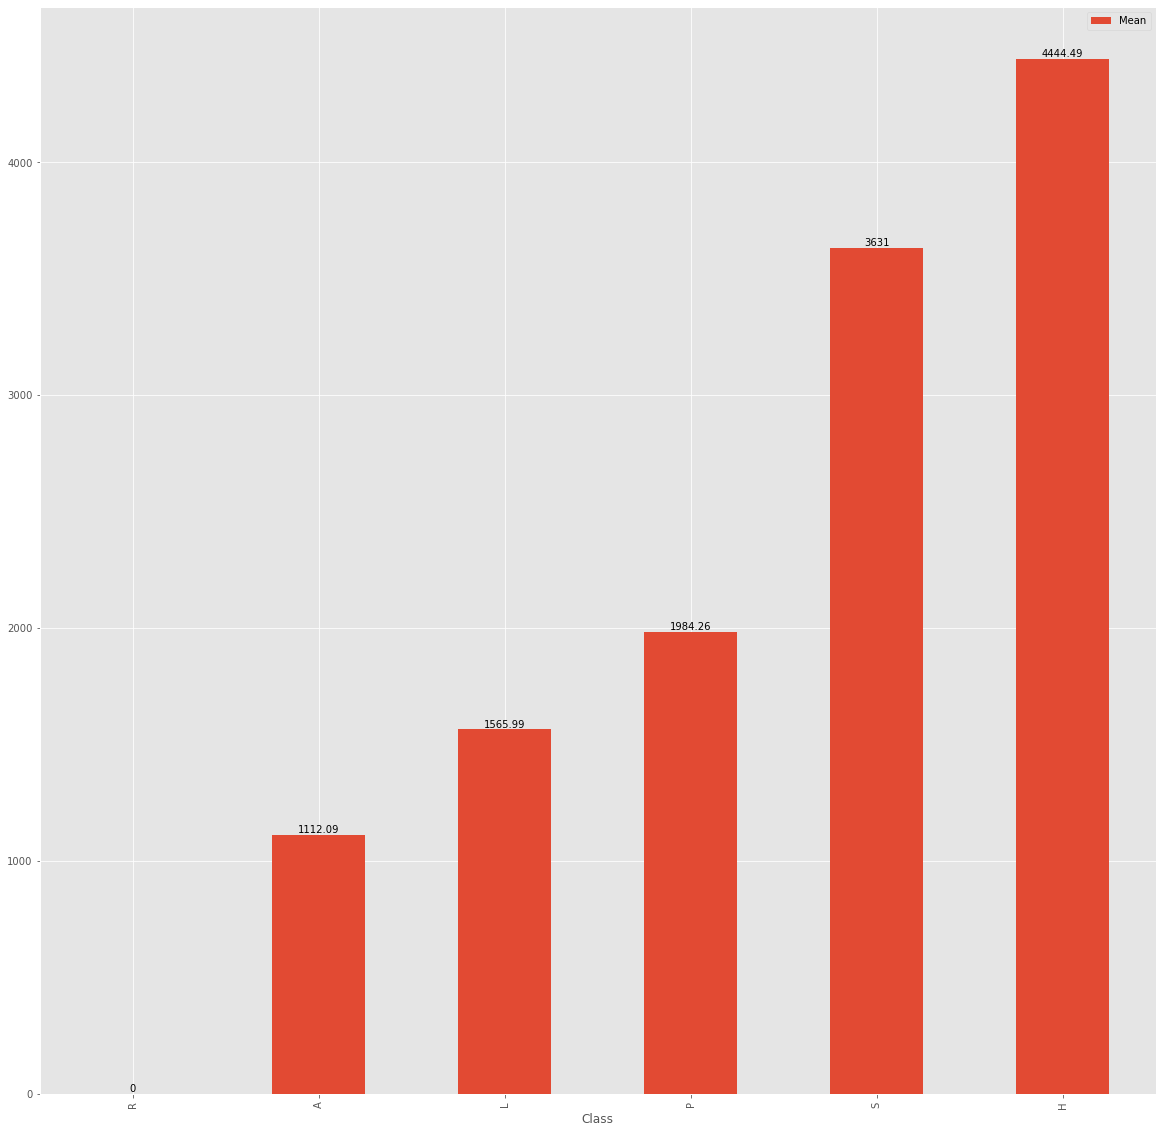

In [78]:
mean_errors_by_class = get_mean_error_by_feature_class(df_geocoded_hgt, False)
ax = pd.DataFrame(mean_errors_by_class.items(), columns=['Class', 'Mean']).sort_values(by=['Mean']).plot.bar(x="Class", y="Mean", figsize=(20,20))
ax.bar_label(ax.containers[0])
print(mean_errors_by_class)

#### CamCoder vs HGT

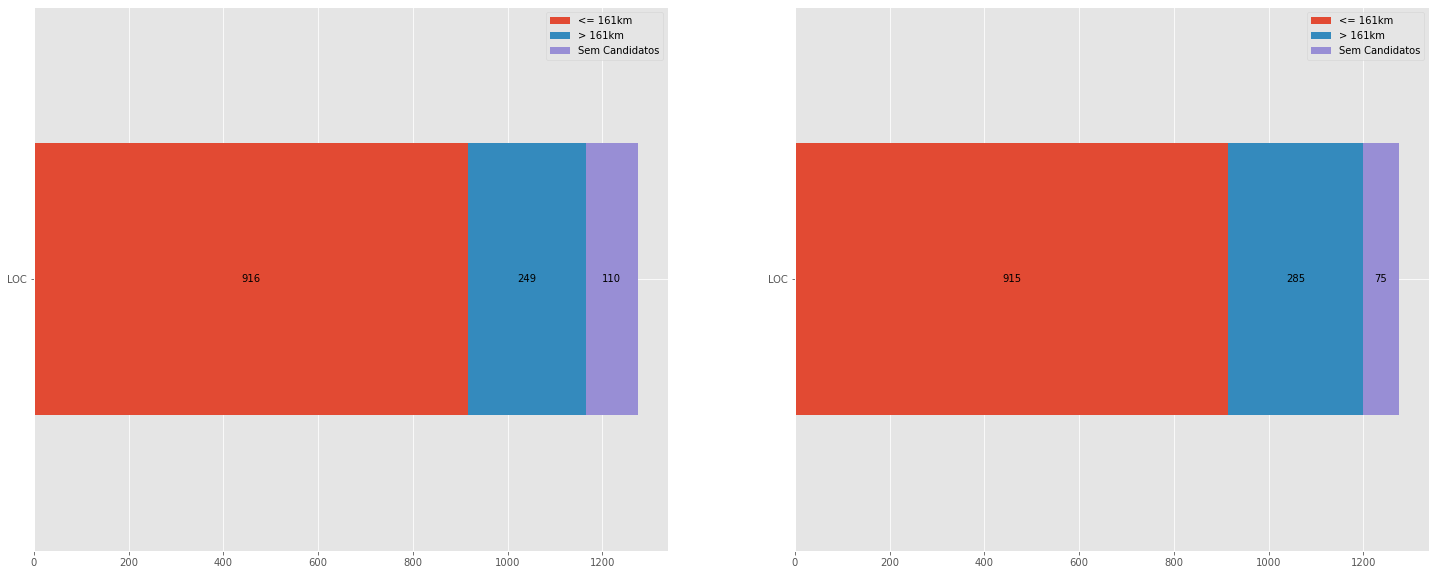

In [79]:
errors_by_type = count_errors_by_type(df_geocoded_hgt, classes=["LOC"])
df_errors_by_type_hgt = pd.DataFrame(
    {key: pd.Series(value) for key, value in errors_by_type.items()})

plot_bars_stacked_diff(df_errors_by_type_camcoder, df_errors_by_type_hgt)

### HG-AT

In [80]:
df_geocoded_hgat = df_trnews[['file', 'text', 'toponyms']].copy()
df_geocoded_hgat['geocoded'] = df_geocoded_hgat.progress_apply(lambda row: geocode_toponyms(geoparser, row.toponyms, exact_matching=True, process_demonyms=True, bounding_box=None, k=5, minimum_score=0, sort_by="population", minimization_classes=["LOC"], minimization_strategy="pop_by_mean_dist"), axis=1)

unified_geocoded =  df_geocoded_hgat['geocoded'].apply(lambda x: [t for t in x if t[4] is not None]).tolist()
unified_geocoded = [i for j in unified_geocoded for i in j]
print(len(unified_geocoded))

df_metrics_geocoded = pd.DataFrame(df_geocoded_hgat.apply(lambda row: metrics(row.geocoded, row.toponyms, False, 161), axis=1).tolist(), index=df_geocoded_hgat.index, columns=['Geotag Precision', 'Geotag Recall', 'Geotag F1-Score', 'Geocode Mean Distance', ' Geocode Within Min Distance', '@161 km', 'AUC', 'Pct predicted'])
df_metrics_geocoded.describe()

Progress:   0%|          | 0/118 [00:00<?, ?it/s]

1245


,Geotag Precision,Geotag Recall,Geotag F1-Score,Geocode Mean Distance,Geocode Within Min Distance,@161 km,AUC,Pct predicted
count,118.0,118.0,118.0,118.000000,118.000000,118.000000,115.000000,118.000000
mean,1.0,1.0,1.0,1162.391805,0.815258,0.815258,0.182969,0.975218
std,0.0,0.0,0.0,1526.622529,0.235708,0.235708,0.194414,0.065521
min,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.600000
25%,1.0,1.0,1.0,0.511612,0.703571,0.703571,0.030274,1.000000
50%,1.0,1.0,1.0,365.218239,0.900000,0.900000,0.113949,1.000000
75%,1.0,1.0,1.0,1934.189673,1.000000,1.000000,0.296978,1.000000
max,1.0,1.0,1.0,5865.009455,1.000000,1.000000,0.875977,1.000000


#### Erro por Feature Code

{'PCLI': 406.00161216005824, 'PPLA': 100.85277329664018, 'PPLC': 291.8583397643627, 'ADM1': 48.24620587055122, 'PPLA2': 2681.936301951299, 'PPL': 3485.6707019357787, 'PRK': 9344.520264097016, 'SCH': 3.536620440947047e-13, 'CONT': 418.747968891901, 'AIRP': 5554.581888219704, 'RGN': 1403.507629639282, 'ADM3': 127.67761903762825, 'PPLA3': 1.9438956211089522, 'OCN': 8720.98907227317, 'PPLX': 5454.7075479256555, 'ADM2': 418.65490078639783, 'ADMD': 0.0, 'HSP': 558.0504294514465, 'STDM': 1.0609861322841142e-12, 'BLDG': 6102.877210734988, 'CH': 9033.232162514698, 'MUS': 0.0, 'AREA': 64.01643099883891, 'HTL': 7544.881001387094, 'MTRO': 0.0, 'STM': 167.99970700709977, 'ST': 0.0, 'PCLIX': 1.7683102204735235e-13, 'PCLD': 0.0, 'PCLS': 0.0, 'PPLQ': 19.073654088094234}


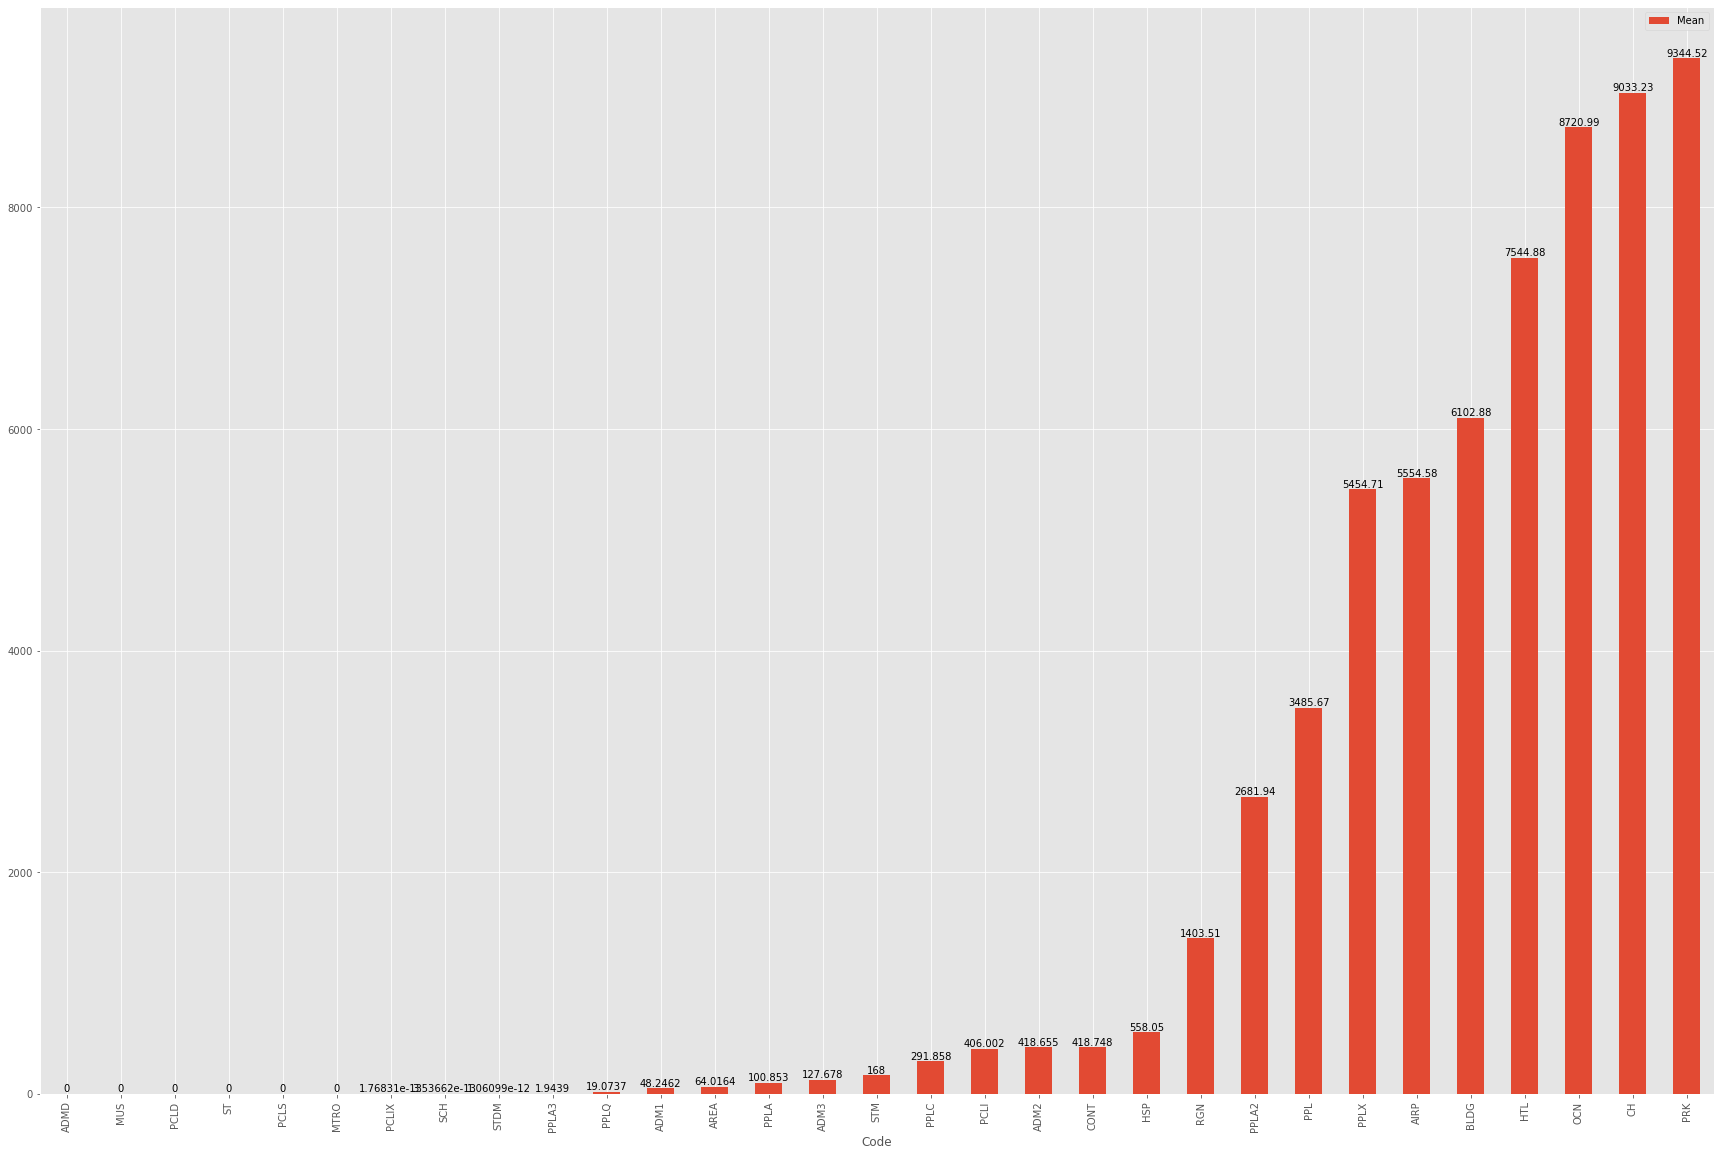

In [81]:
mean_errors_by_code = get_mean_error_by_feature_code(df_geocoded_hgat, False)
ax = pd.DataFrame(mean_errors_by_code.items(), columns=['Code', 'Mean']).sort_values(by=['Mean']).plot.bar(x="Code", y="Mean", figsize=(30,20))
ax.bar_label(ax.containers[0])
print(mean_errors_by_code)

#### Erro por Feature Class

{'A': 281.80273344988376, 'P': 1984.2606709178801, 'L': 1417.571345711928, 'S': 3631.0021556846914, 'H': 4444.4943896401355, 'R': 0.0}


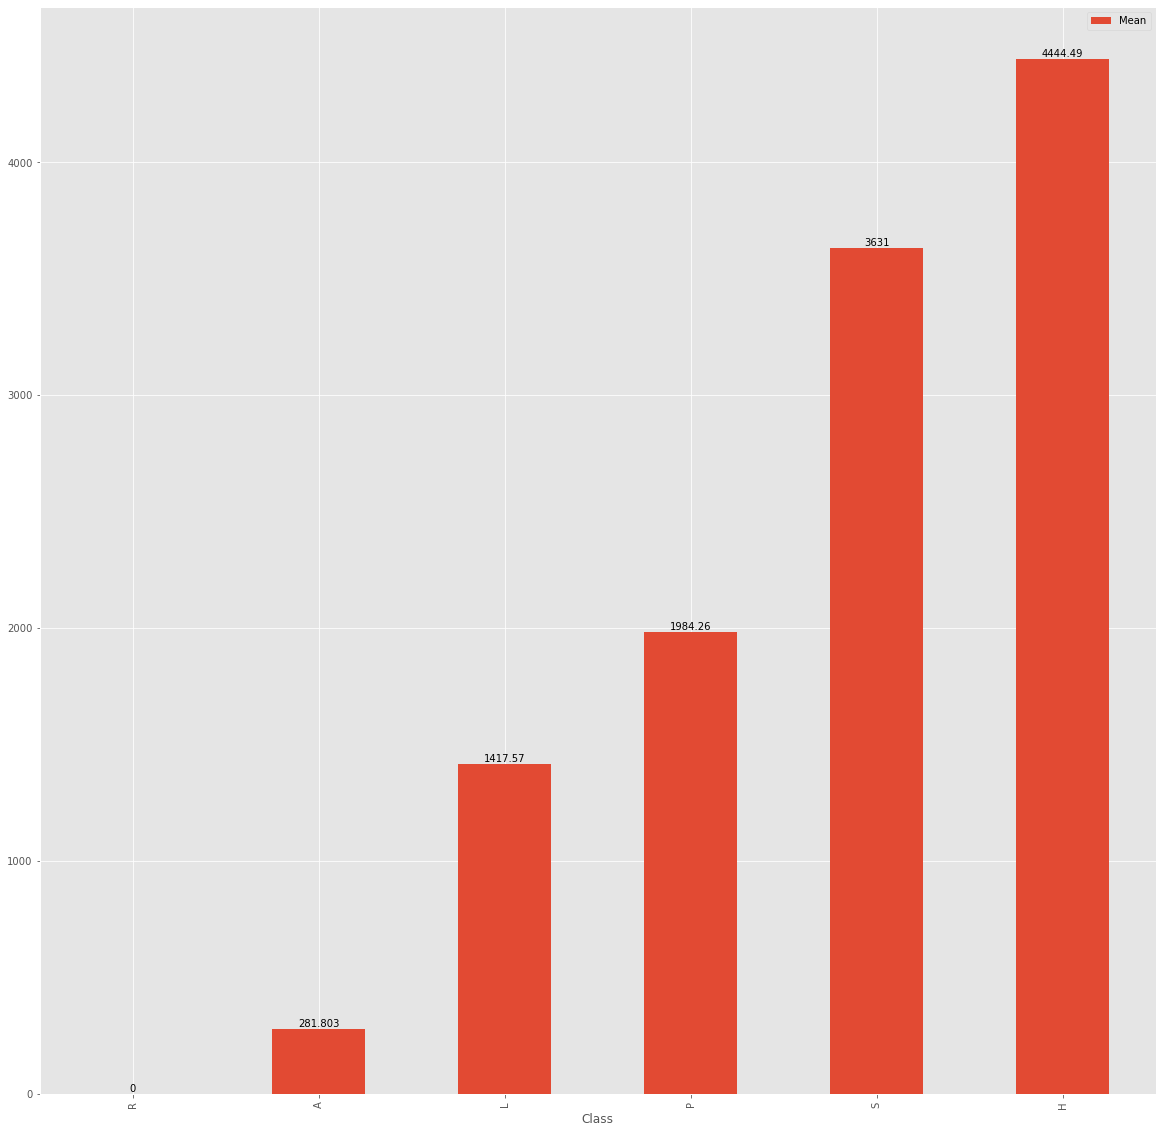

In [82]:
mean_errors_by_class = get_mean_error_by_feature_class(df_geocoded_hgat, False)
ax = pd.DataFrame(mean_errors_by_class.items(), columns=['Class', 'Mean']).sort_values(by=['Mean']).plot.bar(x="Class", y="Mean", figsize=(20,20))
ax.bar_label(ax.containers[0])
print(mean_errors_by_class)

#### CamCoder vs HGAT

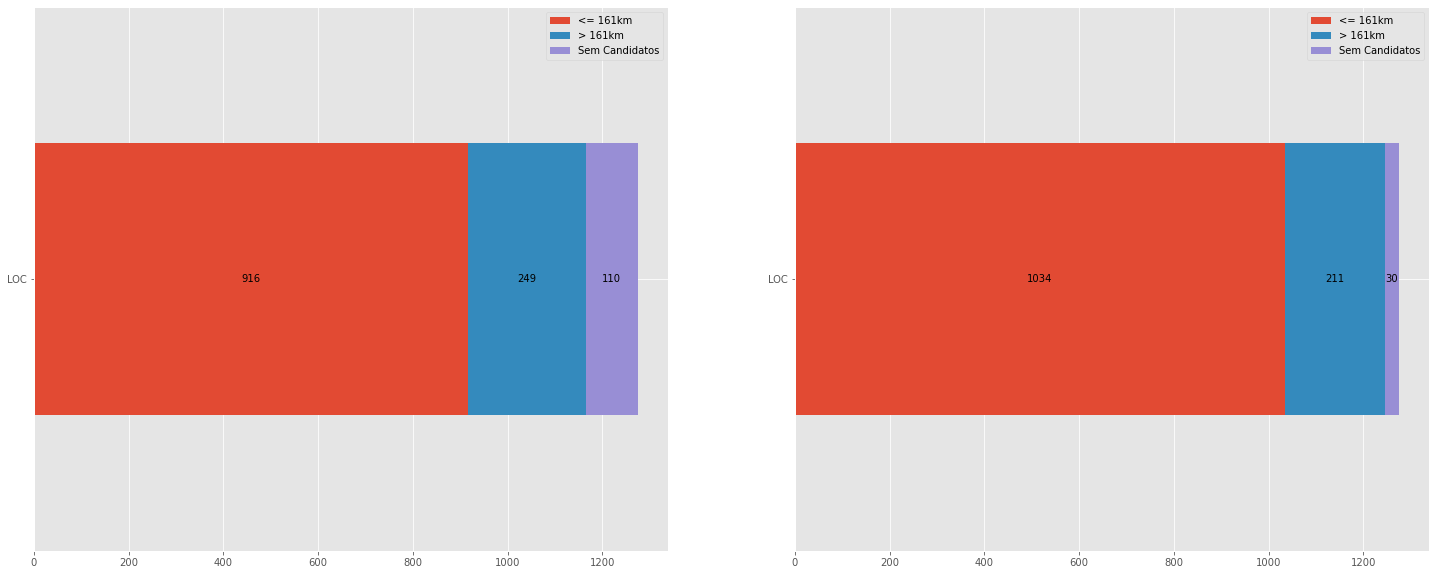

In [83]:
errors_by_type = count_errors_by_type(df_geocoded_hgat, classes=["LOC"])
df_errors_by_type_hgat = pd.DataFrame(
    {key: pd.Series(value) for key, value in errors_by_type.items()})

plot_bars_stacked_diff(df_errors_by_type_camcoder, df_errors_by_type_hgat)

<AxesSubplot:>

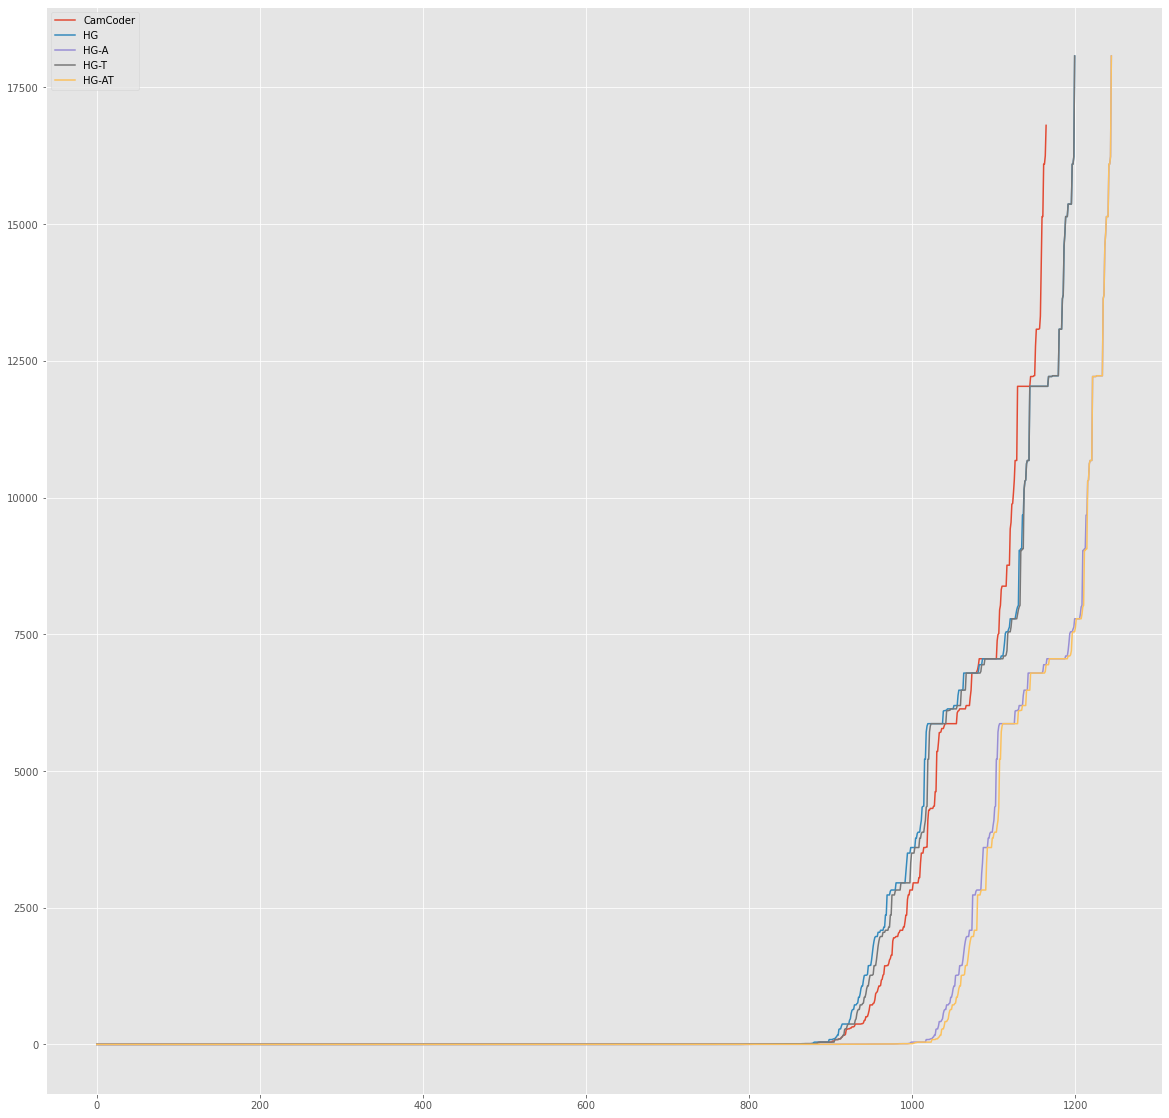

In [84]:
distances_camcoder = sorted([i for j in df_geocoded_camcoder.apply(lambda row: get_prediction_errors(row.geocoded, row.toponyms, False), axis=1).tolist() for i in j])
distances_hg = sorted([i for j in df_geocoded_hg.apply(lambda row: get_prediction_errors(row.geocoded, row.toponyms, False), axis=1).tolist() for i in j])
distances_hga = sorted([i for j in df_geocoded_hga.apply(lambda row: get_prediction_errors(row.geocoded, row.toponyms, False), axis=1).tolist() for i in j])
distances_hgt = sorted([i for j in df_geocoded_hgt.apply(lambda row: get_prediction_errors(row.geocoded, row.toponyms, False), axis=1).tolist() for i in j])
distances_hgat = sorted([i for j in df_geocoded_hgat.apply(lambda row: get_prediction_errors(row.geocoded, row.toponyms, False), axis=1).tolist() for i in j])
distances_dict = { "CamCoder": distances_camcoder, "HG": distances_hg, "HG-A": distances_hga, "HG-T": distances_hgt, "HG-AT": distances_hgat}
df_errors = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in distances_dict.items() ]))
df_errors[["CamCoder", "HG", "HG-A", "HG-T", "HG-AT"]].plot(figsize=(20,20))

### Mesmos Topônimos

In [85]:
toponyms_in = []
for (i, toponyms), (j, geocoded_hg), (k, geocoded_hga), (l, geocoded_hgt), (m, geocoded_hgat), (n, geocoded_cc) in zip(df_trnews[['toponyms']].iterrows(), df_geocoded_hg[["geocoded"]].iterrows(), df_geocoded_hga[["geocoded"]].iterrows(), df_geocoded_hgt[["geocoded"]].iterrows(), df_geocoded_hgat[["geocoded"]].iterrows(), df_geocoded_camcoder[["geocoded"]].iterrows()):
    found_hg = []
    truth = toponyms[0].copy()
    for pred in geocoded_hg[0]:
        for _, gt in enumerate(truth[:]):
            if ner_equal(pred, gt, exact_match=False) and pred[4] is not None:
                found_hg.append(gt)
                del truth[_]
                break
                
                
    found_hga = []
    truth = toponyms[0].copy()
    for pred in geocoded_hga[0]:
        for _, gt in enumerate(truth[:]):
            if ner_equal(pred, gt, exact_match=False) and pred[4] is not None:
                found_hga.append(gt)
                del truth[_]
                break
                
    found_hgt = []
    truth = toponyms[0].copy()
    for pred in geocoded_hgt[0]:
        for _, gt in enumerate(truth[:]):
            if ner_equal(pred, gt, exact_match=False) and pred[4] is not None:
                found_hgt.append(gt)
                del truth[_]
                break
                
    found_hgat = []
    truth = toponyms[0].copy()
    for pred in geocoded_hgat[0]:
        for _, gt in enumerate(truth[:]):
            if ner_equal(pred, gt, exact_match=False) and pred[4] is not None:
                found_hgat.append(gt)
                del truth[_]
                break
                
    found_cc = []
    truth = toponyms[0].copy()
    for pred in geocoded_cc[0]:
        for _, gt in enumerate(truth[:]):
            if ner_equal(pred, gt, exact_match=False) and pred[4] is not None:
                found_cc.append(gt)
                del truth[_]
                break
    
    found_in = set.intersection(*map(set, [found_hg, found_hga, found_hgt, found_hgat, found_cc]))
    toponyms_in.append(list(found_in))    

toponyms_in = pd.DataFrame({"toponyms_in": toponyms_in})

In [86]:
unified_geocoded =  toponyms_in["toponyms_in"].tolist()
unified_geocoded = [i for j in unified_geocoded for i in j]
print(len(unified_geocoded))

1165


#### HG

In [87]:
df_geocoded_hg["toponyms_in"] = toponyms_in
df_metrics_geocoded = pd.DataFrame(df_geocoded_hg.apply(lambda row: metrics(row.geocoded, row.toponyms_in, False, 161), axis=1).tolist(), index=df_geocoded_hg.index, columns=['Geotag Precision', 'Geotag Recall', 'Geotag F1-Score', 'Geocode Mean Distance', ' Geocode Within Min Distance', '@161 km', 'AUC', 'Pct predicted'])
df_metrics_geocoded.describe()

,Geotag Precision,Geotag Recall,Geotag F1-Score,Geocode Mean Distance,Geocode Within Min Distance,@161 km,AUC,Pct predicted
count,118.000000,118.0,118.000000,118.000000,118.000000,118.000000,115.000000,118.0
mean,0.939356,1.0,0.963980,1599.020475,0.748029,0.748029,0.240451,1.0
std,0.120906,0.0,0.077289,1734.902402,0.251475,0.251475,0.207461,0.0
min,0.363636,1.0,0.533333,0.000000,0.000000,0.000000,0.000000,1.0
25%,0.917500,1.0,0.956975,14.132130,0.606250,0.606250,0.080448,1.0
50%,1.000000,1.0,1.000000,1009.997896,0.809091,0.809091,0.196515,1.0
75%,1.000000,1.0,1.000000,2728.645615,1.000000,1.000000,0.380033,1.0
max,1.000000,1.0,1.000000,6453.013561,1.000000,1.000000,0.875977,1.0


#### HG-A

In [88]:
df_geocoded_hga["toponyms_in"] = toponyms_in
df_metrics_geocoded = pd.DataFrame(df_geocoded_hga.apply(lambda row: metrics(row.geocoded, row.toponyms_in, False, 161), axis=1).tolist(), index=df_geocoded_hga.index, columns=['Geotag Precision', 'Geotag Recall', 'Geotag F1-Score', 'Geocode Mean Distance', ' Geocode Within Min Distance', '@161 km', 'AUC', 'Pct predicted'])
df_metrics_geocoded.describe()

,Geotag Precision,Geotag Recall,Geotag F1-Score,Geocode Mean Distance,Geocode Within Min Distance,@161 km,AUC,Pct predicted
count,118.000000,118.0,118.000000,118.000000,118.000000,118.000000,115.000000,118.0
mean,0.939356,1.0,0.963980,1264.822263,0.800616,0.800616,0.195440,1.0
std,0.120906,0.0,0.077289,1605.746453,0.239104,0.239104,0.198440,0.0
min,0.363636,1.0,0.533333,0.000000,0.000000,0.000000,0.000000,1.0
25%,0.917500,1.0,0.956975,0.994923,0.675000,0.675000,0.039613,1.0
50%,1.000000,1.0,1.000000,484.709913,0.881944,0.881944,0.130967,1.0
75%,1.000000,1.0,1.000000,2025.381101,1.000000,1.000000,0.303995,1.0
max,1.000000,1.0,1.000000,6453.013561,1.000000,1.000000,0.875977,1.0


#### HG-T

In [89]:
df_geocoded_hgt["toponyms_in"] = toponyms_in
df_metrics_geocoded = pd.DataFrame(df_geocoded_hgt.apply(lambda row: metrics(row.geocoded, row.toponyms_in, False, 161), axis=1).tolist(), index=df_geocoded_hgt.index, columns=['Geotag Precision', 'Geotag Recall', 'Geotag F1-Score', 'Geocode Mean Distance', ' Geocode Within Min Distance', '@161 km', 'AUC', 'Pct predicted'])
df_metrics_geocoded.describe()

,Geotag Precision,Geotag Recall,Geotag F1-Score,Geocode Mean Distance,Geocode Within Min Distance,@161 km,AUC,Pct predicted
count,118.000000,118.0,118.000000,118.000000,118.000000,118.000000,115.000000,118.0
mean,0.939356,1.0,0.963980,1511.327056,0.759861,0.759861,0.230999,1.0
std,0.120906,0.0,0.077289,1688.305957,0.251789,0.251789,0.206058,0.0
min,0.363636,1.0,0.533333,0.000000,0.000000,0.000000,0.000000,1.0
25%,0.917500,1.0,0.956975,3.722738,0.629464,0.629464,0.070542,1.0
50%,1.000000,1.0,1.000000,875.388564,0.841667,0.841667,0.170065,1.0
75%,1.000000,1.0,1.000000,2614.083859,1.000000,1.000000,0.375989,1.0
max,1.000000,1.0,1.000000,5865.009455,1.000000,1.000000,0.875977,1.0


#### HG-AT

In [90]:
df_geocoded_hgat["toponyms_in"] = toponyms_in
df_metrics_geocoded = pd.DataFrame(df_geocoded_hgat.apply(lambda row: metrics(row.geocoded, row.toponyms_in, False, 161), axis=1).tolist(), index=df_geocoded_hgat.index, columns=['Geotag Precision', 'Geotag Recall', 'Geotag F1-Score', 'Geocode Mean Distance', ' Geocode Within Min Distance', '@161 km', 'AUC', 'Pct predicted'])
df_metrics_geocoded.describe()

,Geotag Precision,Geotag Recall,Geotag F1-Score,Geocode Mean Distance,Geocode Within Min Distance,@161 km,AUC,Pct predicted
count,118.000000,118.0,118.000000,118.000000,118.000000,118.000000,115.000000,118.0
mean,0.939356,1.0,0.963980,1177.129504,0.812449,0.812449,0.186023,1.0
std,0.120906,0.0,0.077289,1536.615613,0.237012,0.237012,0.194835,0.0
min,0.363636,1.0,0.533333,0.000000,0.000000,0.000000,0.000000,1.0
25%,0.917500,1.0,0.956975,0.708192,0.703571,0.703571,0.032184,1.0
50%,1.000000,1.0,1.000000,372.349823,0.900000,0.900000,0.115060,1.0
75%,1.000000,1.0,1.000000,1934.189673,1.000000,1.000000,0.296978,1.0
max,1.000000,1.0,1.000000,5865.009455,1.000000,1.000000,0.875977,1.0


{'A': 309.81065038297623, 'P': 2041.1643195564843, 'L': 1509.0275615643106, 'S': 3631.0021556846914, 'H': 4444.4943896401355, 'R': 0.0}


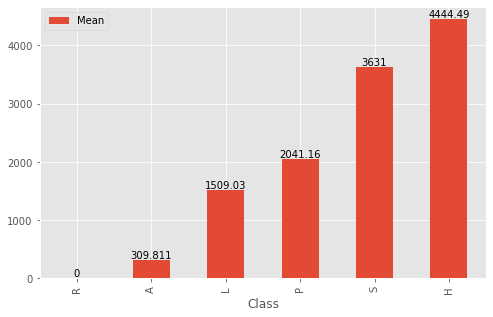

In [91]:
mean_errors_by_class = get_mean_error_by_feature_class_intersection(df_geocoded_hgat, False)
ax = pd.DataFrame(mean_errors_by_class.items(), columns=['Class', 'Mean']).sort_values(by=['Mean']).plot.bar(x="Class", y="Mean", figsize=(8,5))
ax.bar_label(ax.containers[0])
print(mean_errors_by_class)

#### CamCoder

In [92]:
df_geocoded_camcoder["toponyms_in"] = toponyms_in
df_metrics_geocoded = pd.DataFrame(df_geocoded_camcoder.apply(lambda row: metrics(row.geocoded, row.toponyms_in, False, 161), axis=1).tolist(), index=df_geocoded_camcoder.index, columns=['Geotag Precision', 'Geotag Recall', 'Geotag F1-Score', 'Geocode Mean Distance', ' Geocode Within Min Distance', '@161 km', 'AUC', 'Pct predicted'])
df_metrics_geocoded.describe()

,Geotag Precision,Geotag Recall,Geotag F1-Score,Geocode Mean Distance,Geocode Within Min Distance,@161 km,AUC,Pct predicted
count,118.0,118.0,118.0,118.000000,118.000000,118.000000,115.000000,118.0
mean,1.0,1.0,1.0,1140.507819,0.793848,0.792638,0.200976,1.0
std,0.0,0.0,0.0,1576.841230,0.240413,0.240452,0.198811,0.0
min,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,1.0
25%,1.0,1.0,1.0,0.796178,0.666667,0.666667,0.037715,1.0
50%,1.0,1.0,1.0,323.172682,0.857143,0.857143,0.149097,1.0
75%,1.0,1.0,1.0,1759.256469,1.000000,1.000000,0.302444,1.0
max,1.0,1.0,1.0,5865.009455,1.000000,1.000000,0.875977,1.0


{'A': 1131.817271529418, 'P': 1278.2149189636696, 'L': 973.9371037539529, 'S': 366.1526864142649, 'H': 3753.2344570330424, 'R': 0.0}


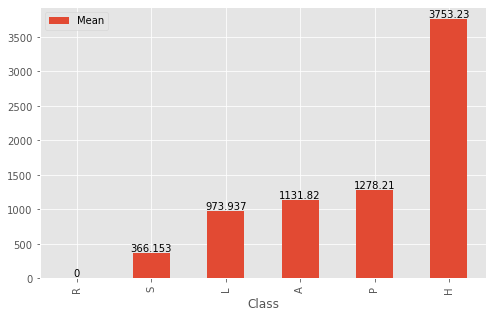

In [93]:
mean_errors_by_class = get_mean_error_by_feature_class_intersection(df_geocoded_camcoder, False)
ax = pd.DataFrame(mean_errors_by_class.items(), columns=['Class', 'Mean']).sort_values(by=['Mean']).plot.bar(x="Class", y="Mean", figsize=(8,5))
ax.bar_label(ax.containers[0])
print(mean_errors_by_class)

#### CamCoder vs HG-AT

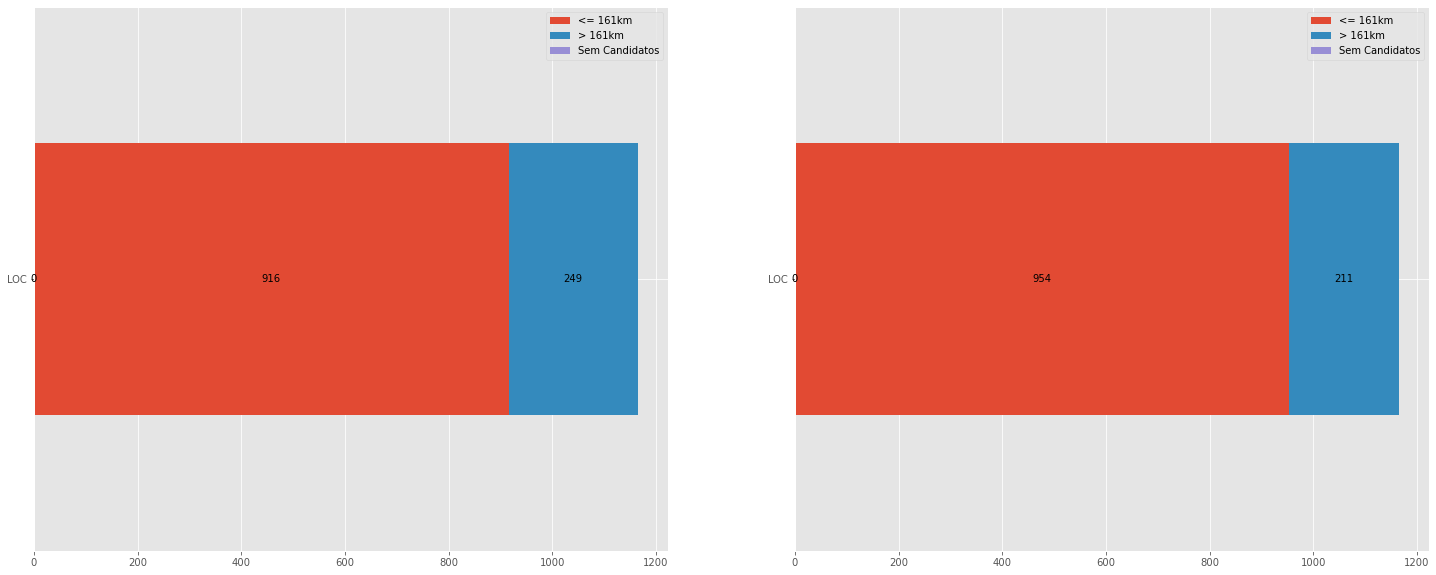

In [94]:
errors_by_type = count_errors_by_type_intersection(df_geocoded_hgat, classes=["LOC"])
df_errors_by_type_hgat_in = pd.DataFrame(
    {key: pd.Series(value) for key, value in errors_by_type.items()})

errors_by_type = count_errors_by_type_intersection(df_geocoded_camcoder, classes=["LOC"])
df_errors_by_type_camcoder_in = pd.DataFrame(
    {key: pd.Series(value) for key, value in errors_by_type.items()})

plot_bars_stacked_diff(df_errors_by_type_camcoder_in, df_errors_by_type_hgat_in)

<AxesSubplot:>

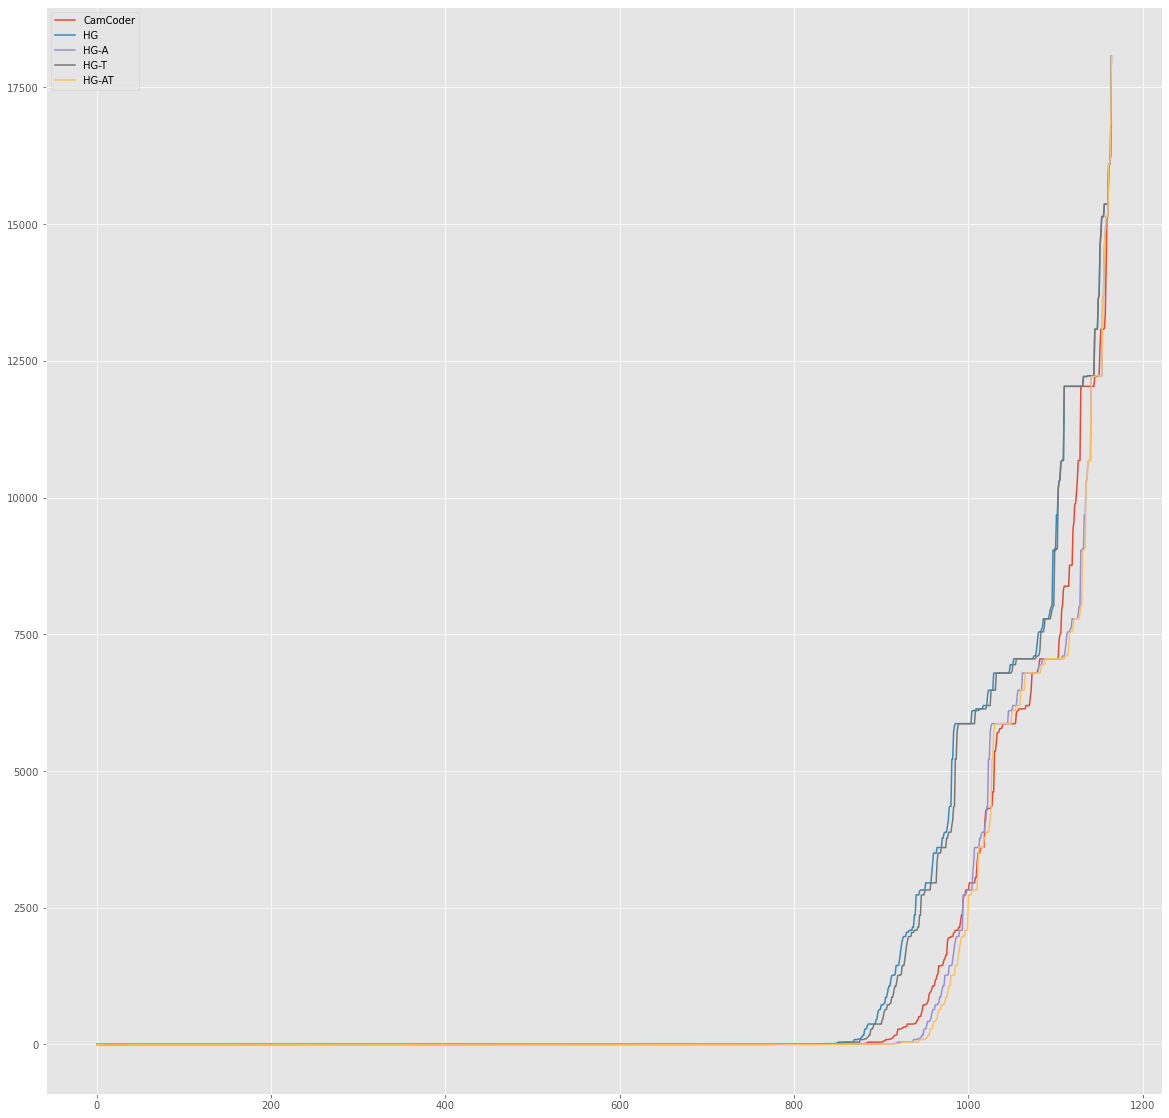

In [95]:
distances_camcoder = sorted([i for j in df_geocoded_camcoder.apply(lambda row: get_prediction_errors(row.geocoded, row.toponyms_in, False), axis=1).tolist() for i in j])
distances_hg = sorted([i for j in df_geocoded_hg.apply(lambda row: get_prediction_errors(row.geocoded, row.toponyms_in, False), axis=1).tolist() for i in j])
distances_hga = sorted([i for j in df_geocoded_hga.apply(lambda row: get_prediction_errors(row.geocoded, row.toponyms_in, False), axis=1).tolist() for i in j])
distances_hgt = sorted([i for j in df_geocoded_hgt.apply(lambda row: get_prediction_errors(row.geocoded, row.toponyms_in, False), axis=1).tolist() for i in j])
distances_hgat = sorted([i for j in df_geocoded_hgat.apply(lambda row: get_prediction_errors(row.geocoded, row.toponyms_in, False), axis=1).tolist() for i in j])
distances_dict = { "CamCoder": distances_camcoder, "HG": distances_hg, "HG-A": distances_hga, "HG-T": distances_hgt, "HG-AT": distances_hgat}
df_errors = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in distances_dict.items() ]))
df_errors[["CamCoder", "HG", "HG-A", "HG-T", "HG-AT"]].plot(figsize=(20,20))